# Multi species model

The [train-crown](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-crown.ipynb) notebook shows how to use the pre-trained tree crown detection of [DeepForest](https://deepforest.readthedocs.io/en/latest) [1] with our dataset, both for inference as well as how to fine-tune it.

In this notebook, we will show how to not only detect tree crowns but also classify them into different species/groups. Without loss of generality, we will first focus on distinguishing between deciduous and conifer trees (as introduced in the [train-test-split](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-test-split.ipynb) notebook and annotated accordingly).

In [ ]:
import json
import tempfile
from os import path

import deepforest_modal_app as dma
import matplotlib.pyplot as plt
import modal
import pandas as pd
import seaborn as sns

from swiss_urban_trees import deepforest_utils, plot

/home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
annot_dir = "../data/raw/sitg-multi-species-annot"
annot_ext = "gpkg"
tile_dir = "../data/raw/sitg-multi-species-tiles"
tile_ext = "tiff"

# model args
num_workers = 4
patch_overlap = 0.05
patch_sizes = [400, 600, 800, 1000, 1200]
iou_threshold = 0.15

# viz args
# annot_color = [0, 165, 255]
# pred_color = [0, 165, 255]
# _base_plot_kwargs = {"linewidth": 2, "facecolor": "none", "cmap": "tab10"}
# plot_annot_kwargs = dict({"column": "label"}, **_base_plot_kwargs)
# multi_plot_pred_kwargs = dict({"column": "label"}, **_base_plot_kwargs)
# crop_plot_pred_kwargs = dict({"column": "cropmodel_label"}, **_base_plot_kwargs)
plot_kwargs = {"column": "label", "linewidth": 2, "facecolor": "none", "cmap": "Set3"}
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

# train args
train_prop = 0.66
# epochs = 20
# gpus = None  # set to -1 to use all available GPUs

# for reproducibility
random_state = 0

## Read annotations

In [ ]:
annot_gdf = deepforest_utils.get_annot_gdf(
    annot_dir=annot_dir, img_dir=tile_dir, annot_ext=annot_ext, img_ext=tile_ext
)
# replace "Tree" label with genus
annot_gdf["label"] = annot_gdf["GENUS"]
# drop stale genus column
annot_gdf = annot_gdf.drop(columns="GENUS")
# select only top 5 most frequent genus and replace the rest of the labels for "other"
annot_gdf.loc[
    ~annot_gdf["label"].isin(["Platanus", "Tilia", "Acer", "Quercus", "Aesculus"]),
    "label",
] = "Other"
# show the data frame
annot_gdf.head()

geometry     label  \
0  POLYGON ((539.294 90.603, 680.582 92.931, 682....     Other   
1  POLYGON ((452.299 103.551, 452.299 68.604, 418...     Other   
2  POLYGON ((610.447 135.463, 611.46 73.947, 672....     Other   
3  POLYGON ((307.513 207.665, 307.513 104.328, 16...  Platanus   
4  POLYGON ((437.019 188.52, 437.019 154.301, 404...     Other   

                                     image_path        xmin        ymin  \
0  2500297.2_1116778.8_2500497.2_1116978.8.tiff  539.294008    0.000000   
1  2500297.2_1116778.8_2500497.2_1116978.8.tiff  418.501836   68.604138   
2  2500297.2_1116778.8_2500497.2_1116978.8.tiff  610.446630   73.947461   
3  2500297.2_1116778.8_2500497.2_1116978.8.tiff  163.969836  104.328138   
4  2500297.2_1116778.8_2500497.2_1116978.8.tiff  404.258836  154.301138   

         xmax        ymax  
0  682.113612   92.930791  
1  452.298836  103.551138  
2  672.546409  136.469613  
3  307.512836  207.665138  
4  437.018836  188.520138

## Multi-species model

In order to detect multiple tree species (or in this case, genuses), we will use the prebuilt model for tree crown detection and then apply a follow-up model to the predicted bounding boxes, i.e., a [crop model](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/03_cropmodels.html).

We will first use our annotated bounding boxes and tree species labels to extract the corresponding image. The cropped images and labels will then be used to train the crop model (i.e., an [image classification](https://paperswithcode.com/task/image-classification) model mapping each extracted image as a whole to the tree species label:

In [ ]:
img_filenames = pd.Series(annot_gdf["image_path"].unique())
remote_img_dir = path.basename(tile_dir)

train_df, test_df = deepforest_utils.train_test_split(
    annot_gdf.drop(columns="geometry"), train_size=train_prop, random_state=0
)

# run ephimeral app
with modal.enable_output():
    with dma.app.run():
        app = dma.DeepForestApp()

        # ensure images
        with tempfile.TemporaryDirectory() as tmp_dir:
            imgs_filepath = path.join(tmp_dir, "imgs.json")
            with open(imgs_filepath, "w") as dst:
                json.dump(list(img_filenames), dst)

            dma.ensure_imgs(imgs_filepath, tile_dir, remote_img_dir=remote_img_dir)

        # fine-tune pre-trained model
        fine_tuned_filename = "crown-fine-tune.pl"
        # ACHTUNG: here we need to reassign label as tree
        app.retrain_crown_model.remote(
            train_df.assign(**{"label": "Tree"}),
            remote_img_dir,
            test_df=test_df.assign(**{"label": "Tree"}),
            dst_filename=fine_tuned_filename,
        )

        # train crop model
        crop_filename = "crop.pl"
        app.train_crop_model.remote(
            train_df,
            remote_img_dir,
            test_df=test_df,
            dst_filename=crop_filename,
        )

        # TODO: how to let the app handle this?
        crop_model_num_classes = annot_gdf["label"].nunique()
        # inference with fine-tuned and crop model
        pred_gdf = pd.concat(
            [
                app.predict.remote(
                    img_filename,
                    remote_img_dir,
                    checkpoint_filename=fine_tuned_filename,
                    crop_model_filename=crop_filename,
                    crop_model_num_classes=crop_model_num_classes,
                    patch_size=patch_size,
                    patch_overlap=patch_overlap,
                    iou_threshold=iou_threshold,
                ).assign(**{"patch_size": patch_size})
                for img_filename in img_filenames
                for patch_size in patch_sizes
            ],
            ignore_index=True,
        )

Output()

✓ Initialized. View run at https://modal.com/apps/martibosch/main/ap-eVwFV9BRvKyehvd23tjh3K

Output()

✓ Created objects.
├── 🔨 Created mount PythonPackage:deepforest_modal_app
└── 🔨 Created function DeepForestApp.*.

Output()

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


/models/torch
/models/torch/hub
Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Checkpoint /models/deepforest/crown-fine-tune.pl already exists, skipping retraining. Use `retrain_if_exists=True` to overwrite.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /models/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


  9%|▊         | 8.50M/97.8M [00:00<00:01, 89.0MB/s]


 23%|██▎       | 22.8M/97.8M [00:00<00:00, 124MB/s] 


 38%|███▊      | 37.2M/97.8M [00:00<00:00, 137MB/s]


 53%|█████▎    | 51.6M/97.8M [00:00<00:00, 142MB/s]


 67%|██████▋   | 65.2M/97.8M [00:00<00:00, 140MB/s]


 81%|████████▏ | 79.5M/97.8M [00:00<00:00, 143MB/s]


 95%|█████████▌| 93.1M/97.8M [00:00<00:00, 140MB/s]100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name             | Type                | Params | Mode 
-----------------------------------------------------------------
0 | model            | ResNet              | 23.5 M | train
1 | accuracy         | MulticlassAccuracy  | 0      | train
2 | total_accuracy   | MulticlassAccuracy  | 0      | train
3 | precision_metric | MulticlassPrecision | 0      | train
4 | metrics          | MetricCollection    | 0      | train
-----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.081    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s]Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]                                                                           Training: |          | 0/? [00:00<?, ?it/s]Training:   0%|          | 0/70 [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s] Epoch 0:   1%|▏         | 1/70 [00:00<00:28,  2.41it/s]


Epoch 0:   1%|▏         | 1/70 [00:00<00:28,  2.41it/s, v_num=0]Epoch 0:   3%|▎         | 2/70 [00:00<00:15,  4.48it/s, v_num=0]


Epoch 0:   3%|▎         | 2/70 [00:00<00:15,  4.48it/s, v_num=0]Epoch 0:   4%|▍         | 3/70 [00:00<00:10,  6.45it/s, v_num=0]


Epoch 0:   4%|▍         | 3/70 [00:00<00:10,  6.45it/s, v_num=0]Epoch 0:   6%|▌         | 4/70 [00:00<00:07,  8.29it/s, v_num=0]


Epoch 0:   6%|▌         | 4/70 [00:00<00:07,  8.29it/s, v_num=0]Epoch 0:   7%|▋         | 5/70 [00:00<00:06, 10.03it/s, v_num=0]


Epoch 0:   7%|▋         | 5/70 [00:00<00:06, 10.02it/s, v_num=0]Epoch 0:   9%|▊         | 6/70 [00:00<00:05, 11.64it/s, v_num=0]


Epoch 0:   9%|▊         | 6/70 [00:00<00:05, 11.64it/s, v_num=0]Epoch 0:  10%|█         | 7/70 [00:00<00:04, 13.15it/s, v_num=0]


Epoch 0:  10%|█         | 7/70 [00:00<00:04, 13.15it/s, v_num=0]Epoch 0:  11%|█▏        | 8/70 [00:00<00:04, 14.58it/s, v_num=0]


Epoch 0:  11%|█▏        | 8/70 [00:00<00:04, 14.58it/s, v_num=0]Epoch 0:  13%|█▎        | 9/70 [00:00<00:03, 15.94it/s, v_num=0]


Epoch 0:  13%|█▎        | 9/70 [00:00<00:03, 15.93it/s, v_num=0]Epoch 0:  14%|█▍        | 10/70 [00:00<00:03, 17.17it/s, v_num=0]


Epoch 0:  14%|█▍        | 10/70 [00:00<00:03, 17.16it/s, v_num=0]Epoch 0:  16%|█▌        | 11/70 [00:00<00:03, 18.39it/s, v_num=0]


Epoch 0:  16%|█▌        | 11/70 [00:00<00:03, 18.38it/s, v_num=0]Epoch 0:  17%|█▋        | 12/70 [00:00<00:02, 19.52it/s, v_num=0]


Epoch 0:  17%|█▋        | 12/70 [00:00<00:02, 19.52it/s, v_num=0]Epoch 0:  19%|█▊        | 13/70 [00:00<00:02, 20.61it/s, v_num=0]


Epoch 0:  19%|█▊        | 13/70 [00:00<00:02, 20.61it/s, v_num=0]Epoch 0:  20%|██        | 14/70 [00:00<00:02, 21.65it/s, v_num=0]


Epoch 0:  20%|██        | 14/70 [00:00<00:02, 21.64it/s, v_num=0]Epoch 0:  21%|██▏       | 15/70 [00:00<00:02, 22.64it/s, v_num=0]


Epoch 0:  21%|██▏       | 15/70 [00:00<00:02, 22.63it/s, v_num=0]Epoch 0:  23%|██▎       | 16/70 [00:00<00:02, 23.58it/s, v_num=0]


Epoch 0:  23%|██▎       | 16/70 [00:00<00:02, 23.58it/s, v_num=0]Epoch 0:  24%|██▍       | 17/70 [00:00<00:02, 24.48it/s, v_num=0]


Epoch 0:  24%|██▍       | 17/70 [00:00<00:02, 24.47it/s, v_num=0]Epoch 0:  26%|██▌       | 18/70 [00:00<00:02, 25.34it/s, v_num=0]


Epoch 0:  26%|██▌       | 18/70 [00:00<00:02, 25.34it/s, v_num=0]Epoch 0:  27%|██▋       | 19/70 [00:00<00:01, 26.11it/s, v_num=0]


Epoch 0:  27%|██▋       | 19/70 [00:00<00:01, 26.10it/s, v_num=0]Epoch 0:  29%|██▊       | 20/70 [00:00<00:01, 26.88it/s, v_num=0]


Epoch 0:  29%|██▊       | 20/70 [00:00<00:01, 26.87it/s, v_num=0]Epoch 0:  30%|███       | 21/70 [00:00<00:01, 27.62it/s, v_num=0]


Epoch 0:  30%|███       | 21/70 [00:00<00:01, 27.61it/s, v_num=0]Epoch 0:  31%|███▏      | 22/70 [00:00<00:01, 28.35it/s, v_num=0]


Epoch 0:  31%|███▏      | 22/70 [00:00<00:01, 28.35it/s, v_num=0]Epoch 0:  33%|███▎      | 23/70 [00:00<00:01, 28.99it/s, v_num=0]


Epoch 0:  33%|███▎      | 23/70 [00:00<00:01, 28.98it/s, v_num=0]Epoch 0:  34%|███▍      | 24/70 [00:00<00:01, 29.65it/s, v_num=0]


Epoch 0:  34%|███▍      | 24/70 [00:00<00:01, 29.64it/s, v_num=0]Epoch 0:  36%|███▌      | 25/70 [00:00<00:01, 30.26it/s, v_num=0]


Epoch 0:  36%|███▌      | 25/70 [00:00<00:01, 30.26it/s, v_num=0]Epoch 0:  37%|███▋      | 26/70 [00:00<00:01, 30.84it/s, v_num=0]


Epoch 0:  37%|███▋      | 26/70 [00:00<00:01, 30.84it/s, v_num=0]Epoch 0:  39%|███▊      | 27/70 [00:00<00:01, 31.45it/s, v_num=0]


Epoch 0:  39%|███▊      | 27/70 [00:00<00:01, 31.44it/s, v_num=0]Epoch 0:  40%|████      | 28/70 [00:00<00:01, 31.99it/s, v_num=0]


Epoch 0:  40%|████      | 28/70 [00:00<00:01, 31.98it/s, v_num=0]Epoch 0:  41%|████▏     | 29/70 [00:00<00:01, 32.56it/s, v_num=0]


Epoch 0:  41%|████▏     | 29/70 [00:00<00:01, 32.55it/s, v_num=0]Epoch 0:  43%|████▎     | 30/70 [00:00<00:01, 33.07it/s, v_num=0]


Epoch 0:  43%|████▎     | 30/70 [00:00<00:01, 33.07it/s, v_num=0]Epoch 0:  44%|████▍     | 31/70 [00:00<00:01, 33.52it/s, v_num=0]


Epoch 0:  44%|████▍     | 31/70 [00:00<00:01, 33.52it/s, v_num=0]Epoch 0:  46%|████▌     | 32/70 [00:00<00:01, 33.97it/s, v_num=0]


Epoch 0:  46%|████▌     | 32/70 [00:00<00:01, 33.96it/s, v_num=0]Epoch 0:  47%|████▋     | 33/70 [00:00<00:01, 34.42it/s, v_num=0]


Epoch 0:  47%|████▋     | 33/70 [00:00<00:01, 34.41it/s, v_num=0]Epoch 0:  49%|████▊     | 34/70 [00:00<00:01, 34.88it/s, v_num=0]


Epoch 0:  49%|████▊     | 34/70 [00:00<00:01, 34.88it/s, v_num=0]Epoch 0:  50%|█████     | 35/70 [00:00<00:00, 35.31it/s, v_num=0]


Epoch 0:  50%|█████     | 35/70 [00:00<00:00, 35.30it/s, v_num=0]Epoch 0:  51%|█████▏    | 36/70 [00:01<00:00, 35.74it/s, v_num=0]


Epoch 0:  51%|█████▏    | 36/70 [00:01<00:00, 35.74it/s, v_num=0]Epoch 0:  53%|█████▎    | 37/70 [00:01<00:00, 36.15it/s, v_num=0]


Epoch 0:  53%|█████▎    | 37/70 [00:01<00:00, 36.15it/s, v_num=0]Epoch 0:  54%|█████▍    | 38/70 [00:01<00:00, 36.56it/s, v_num=0]


Epoch 0:  54%|█████▍    | 38/70 [00:01<00:00, 36.55it/s, v_num=0]Epoch 0:  56%|█████▌    | 39/70 [00:01<00:00, 36.96it/s, v_num=0]


Epoch 0:  56%|█████▌    | 39/70 [00:01<00:00, 36.95it/s, v_num=0]Epoch 0:  57%|█████▋    | 40/70 [00:01<00:00, 37.34it/s, v_num=0]


Epoch 0:  57%|█████▋    | 40/70 [00:01<00:00, 37.33it/s, v_num=0]Epoch 0:  59%|█████▊    | 41/70 [00:01<00:00, 37.73it/s, v_num=0]


Epoch 0:  59%|█████▊    | 41/70 [00:01<00:00, 37.72it/s, v_num=0]Epoch 0:  60%|██████    | 42/70 [00:01<00:00, 38.09it/s, v_num=0]


Epoch 0:  60%|██████    | 42/70 [00:01<00:00, 38.08it/s, v_num=0]Epoch 0:  61%|██████▏   | 43/70 [00:01<00:00, 38.42it/s, v_num=0]


Epoch 0:  61%|██████▏   | 43/70 [00:01<00:00, 38.42it/s, v_num=0]Epoch 0:  63%|██████▎   | 44/70 [00:01<00:00, 38.78it/s, v_num=0]


Epoch 0:  63%|██████▎   | 44/70 [00:01<00:00, 38.77it/s, v_num=0]Epoch 0:  64%|██████▍   | 45/70 [00:01<00:00, 39.11it/s, v_num=0]


Epoch 0:  64%|██████▍   | 45/70 [00:01<00:00, 39.11it/s, v_num=0]Epoch 0:  66%|██████▌   | 46/70 [00:01<00:00, 39.45it/s, v_num=0]


Epoch 0:  66%|██████▌   | 46/70 [00:01<00:00, 39.45it/s, v_num=0]Epoch 0:  67%|██████▋   | 47/70 [00:01<00:00, 39.76it/s, v_num=0]


Epoch 0:  67%|██████▋   | 47/70 [00:01<00:00, 39.75it/s, v_num=0]Epoch 0:  69%|██████▊   | 48/70 [00:01<00:00, 40.01it/s, v_num=0]


Epoch 0:  69%|██████▊   | 48/70 [00:01<00:00, 40.01it/s, v_num=0]Epoch 0:  70%|███████   | 49/70 [00:01<00:00, 40.31it/s, v_num=0]


Epoch 0:  70%|███████   | 49/70 [00:01<00:00, 40.30it/s, v_num=0]Epoch 0:  71%|███████▏  | 50/70 [00:01<00:00, 40.60it/s, v_num=0]


Epoch 0:  71%|███████▏  | 50/70 [00:01<00:00, 40.60it/s, v_num=0]Epoch 0:  73%|███████▎  | 51/70 [00:01<00:00, 40.81it/s, v_num=0]


Epoch 0:  73%|███████▎  | 51/70 [00:01<00:00, 40.81it/s, v_num=0]Epoch 0:  74%|███████▍  | 52/70 [00:01<00:00, 41.10it/s, v_num=0]


Epoch 0:  74%|███████▍  | 52/70 [00:01<00:00, 41.09it/s, v_num=0]Epoch 0:  76%|███████▌  | 53/70 [00:01<00:00, 41.36it/s, v_num=0]


Epoch 0:  76%|███████▌  | 53/70 [00:01<00:00, 41.35it/s, v_num=0]Epoch 0:  77%|███████▋  | 54/70 [00:01<00:00, 41.63it/s, v_num=0]


Epoch 0:  77%|███████▋  | 54/70 [00:01<00:00, 41.62it/s, v_num=0]Epoch 0:  79%|███████▊  | 55/70 [00:01<00:00, 41.88it/s, v_num=0]


Epoch 0:  79%|███████▊  | 55/70 [00:01<00:00, 41.87it/s, v_num=0]Epoch 0:  80%|████████  | 56/70 [00:01<00:00, 42.11it/s, v_num=0]


Epoch 0:  80%|████████  | 56/70 [00:01<00:00, 42.11it/s, v_num=0]Epoch 0:  81%|████████▏ | 57/70 [00:01<00:00, 42.35it/s, v_num=0]


Epoch 0:  81%|████████▏ | 57/70 [00:01<00:00, 42.34it/s, v_num=0]Epoch 0:  83%|████████▎ | 58/70 [00:01<00:00, 42.56it/s, v_num=0]


Epoch 0:  83%|████████▎ | 58/70 [00:01<00:00, 42.55it/s, v_num=0]Epoch 0:  84%|████████▍ | 59/70 [00:01<00:00, 42.78it/s, v_num=0]


Epoch 0:  84%|████████▍ | 59/70 [00:01<00:00, 42.78it/s, v_num=0]Epoch 0:  86%|████████▌ | 60/70 [00:01<00:00, 42.97it/s, v_num=0]


Epoch 0:  86%|████████▌ | 60/70 [00:01<00:00, 42.97it/s, v_num=0]Epoch 0:  87%|████████▋ | 61/70 [00:01<00:00, 43.16it/s, v_num=0]


Epoch 0:  87%|████████▋ | 61/70 [00:01<00:00, 43.16it/s, v_num=0]Epoch 0:  89%|████████▊ | 62/70 [00:01<00:00, 43.35it/s, v_num=0]


Epoch 0:  89%|████████▊ | 62/70 [00:01<00:00, 43.34it/s, v_num=0]Epoch 0:  90%|█████████ | 63/70 [00:01<00:00, 43.56it/s, v_num=0]


Epoch 0:  90%|█████████ | 63/70 [00:01<00:00, 43.56it/s, v_num=0]Epoch 0:  91%|█████████▏| 64/70 [00:01<00:00, 43.78it/s, v_num=0]


Epoch 0:  91%|█████████▏| 64/70 [00:01<00:00, 43.77it/s, v_num=0]Epoch 0:  93%|█████████▎| 65/70 [00:01<00:00, 43.95it/s, v_num=0]


Epoch 0:  93%|█████████▎| 65/70 [00:01<00:00, 43.95it/s, v_num=0]Epoch 0:  94%|█████████▍| 66/70 [00:01<00:00, 44.15it/s, v_num=0]


Epoch 0:  94%|█████████▍| 66/70 [00:01<00:00, 44.14it/s, v_num=0]Epoch 0:  96%|█████████▌| 67/70 [00:01<00:00, 44.35it/s, v_num=0]


Epoch 0:  96%|█████████▌| 67/70 [00:01<00:00, 44.34it/s, v_num=0]Epoch 0:  97%|█████████▋| 68/70 [00:01<00:00, 44.55it/s, v_num=0]


Epoch 0:  97%|█████████▋| 68/70 [00:01<00:00, 44.55it/s, v_num=0]Epoch 0:  99%|█████████▊| 69/70 [00:01<00:00, 44.73it/s, v_num=0]


Epoch 0:  99%|█████████▊| 69/70 [00:01<00:00, 44.73it/s, v_num=0]Epoch 0: 100%|██████████| 70/70 [00:01<00:00, 41.09it/s, v_num=0]Epoch 0: 100%|██████████| 70/70 [00:01<00:00, 41.09it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 78.62it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 62.72it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 62.75it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 62.57it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 61.91it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 62.35it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 62.76it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 62.74it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 62.71it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 62.92it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 63.16it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 63.28it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 63.34it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 63.24it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.33it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.13it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.23it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 63.19it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 63.27it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 63.30it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 63.08it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 63.09it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 63.21it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 63.23it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.35it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.37it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 63.49it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 63.45it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 63.21it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 63.07it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 62.87it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 62.82it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 62.60it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 62.57it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 62.53it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 62.42it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 62.42it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.38it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.41it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.43it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.44it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.38it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.38it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.43it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.50it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.50it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.59it/s]
                                                                        Epoch 0: 100%|██████████| 70/70 [00:02<00:00, 28.22it/s, v_num=0]


Epoch 0: 100%|██████████| 70/70 [00:02<00:00, 28.21it/s, v_num=0]Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 1:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 1:   1%|▏         | 1/70 [00:00<00:01, 41.69it/s, v_num=0]


Epoch 1:   1%|▏         | 1/70 [00:00<00:01, 41.32it/s, v_num=0]Epoch 1:   3%|▎         | 2/70 [00:00<00:01, 46.48it/s, v_num=0]


Epoch 1:   3%|▎         | 2/70 [00:00<00:01, 46.29it/s, v_num=0]Epoch 1:   4%|▍         | 3/70 [00:00<00:01, 50.78it/s, v_num=0]


Epoch 1:   4%|▍         | 3/70 [00:00<00:01, 50.64it/s, v_num=0]Epoch 1:   6%|▌         | 4/70 [00:00<00:01, 53.31it/s, v_num=0]


Epoch 1:   6%|▌         | 4/70 [00:00<00:01, 53.19it/s, v_num=0]Epoch 1:   7%|▋         | 5/70 [00:00<00:01, 54.00it/s, v_num=0]


Epoch 1:   7%|▋         | 5/70 [00:00<00:01, 53.91it/s, v_num=0]Epoch 1:   9%|▊         | 6/70 [00:00<00:01, 55.15it/s, v_num=0]


Epoch 1:   9%|▊         | 6/70 [00:00<00:01, 55.06it/s, v_num=0]Epoch 1:  10%|█         | 7/70 [00:00<00:01, 56.20it/s, v_num=0]


Epoch 1:  10%|█         | 7/70 [00:00<00:01, 56.13it/s, v_num=0]Epoch 1:  11%|█▏        | 8/70 [00:00<00:01, 57.01it/s, v_num=0]


Epoch 1:  11%|█▏        | 8/70 [00:00<00:01, 56.95it/s, v_num=0]Epoch 1:  13%|█▎        | 9/70 [00:00<00:01, 57.42it/s, v_num=0]


Epoch 1:  13%|█▎        | 9/70 [00:00<00:01, 57.36it/s, v_num=0]Epoch 1:  14%|█▍        | 10/70 [00:00<00:01, 57.87it/s, v_num=0]


Epoch 1:  14%|█▍        | 10/70 [00:00<00:01, 57.82it/s, v_num=0]Epoch 1:  16%|█▌        | 11/70 [00:00<00:01, 57.97it/s, v_num=0]


Epoch 1:  16%|█▌        | 11/70 [00:00<00:01, 57.92it/s, v_num=0]Epoch 1:  17%|█▋        | 12/70 [00:00<00:00, 58.01it/s, v_num=0]


Epoch 1:  17%|█▋        | 12/70 [00:00<00:01, 57.96it/s, v_num=0]Epoch 1:  19%|█▊        | 13/70 [00:00<00:00, 58.28it/s, v_num=0]


Epoch 1:  19%|█▊        | 13/70 [00:00<00:00, 58.23it/s, v_num=0]Epoch 1:  20%|██        | 14/70 [00:00<00:00, 58.54it/s, v_num=0]


Epoch 1:  20%|██        | 14/70 [00:00<00:00, 58.50it/s, v_num=0]Epoch 1:  21%|██▏       | 15/70 [00:00<00:00, 58.75it/s, v_num=0]


Epoch 1:  21%|██▏       | 15/70 [00:00<00:00, 58.71it/s, v_num=0]Epoch 1:  23%|██▎       | 16/70 [00:00<00:00, 58.82it/s, v_num=0]


Epoch 1:  23%|██▎       | 16/70 [00:00<00:00, 58.79it/s, v_num=0]Epoch 1:  24%|██▍       | 17/70 [00:00<00:00, 58.83it/s, v_num=0]


Epoch 1:  24%|██▍       | 17/70 [00:00<00:00, 58.79it/s, v_num=0]Epoch 1:  26%|██▌       | 18/70 [00:00<00:00, 59.00it/s, v_num=0]


Epoch 1:  26%|██▌       | 18/70 [00:00<00:00, 58.97it/s, v_num=0]Epoch 1:  27%|██▋       | 19/70 [00:00<00:00, 58.98it/s, v_num=0]


Epoch 1:  27%|██▋       | 19/70 [00:00<00:00, 58.95it/s, v_num=0]Epoch 1:  29%|██▊       | 20/70 [00:00<00:00, 59.00it/s, v_num=0]


Epoch 1:  29%|██▊       | 20/70 [00:00<00:00, 58.97it/s, v_num=0]Epoch 1:  30%|███       | 21/70 [00:00<00:00, 59.12it/s, v_num=0]


Epoch 1:  30%|███       | 21/70 [00:00<00:00, 59.10it/s, v_num=0]Epoch 1:  31%|███▏      | 22/70 [00:00<00:00, 59.27it/s, v_num=0]


Epoch 1:  31%|███▏      | 22/70 [00:00<00:00, 59.24it/s, v_num=0]Epoch 1:  33%|███▎      | 23/70 [00:00<00:00, 59.35it/s, v_num=0]


Epoch 1:  33%|███▎      | 23/70 [00:00<00:00, 59.32it/s, v_num=0]Epoch 1:  34%|███▍      | 24/70 [00:00<00:00, 59.43it/s, v_num=0]


Epoch 1:  34%|███▍      | 24/70 [00:00<00:00, 59.40it/s, v_num=0]Epoch 1:  36%|███▌      | 25/70 [00:00<00:00, 59.45it/s, v_num=0]


Epoch 1:  36%|███▌      | 25/70 [00:00<00:00, 59.43it/s, v_num=0]Epoch 1:  37%|███▋      | 26/70 [00:00<00:00, 59.51it/s, v_num=0]


Epoch 1:  37%|███▋      | 26/70 [00:00<00:00, 59.48it/s, v_num=0]Epoch 1:  39%|███▊      | 27/70 [00:00<00:00, 59.50it/s, v_num=0]


Epoch 1:  39%|███▊      | 27/70 [00:00<00:00, 59.48it/s, v_num=0]Epoch 1:  40%|████      | 28/70 [00:00<00:00, 59.60it/s, v_num=0]


Epoch 1:  40%|████      | 28/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 1:  41%|████▏     | 29/70 [00:00<00:00, 59.65it/s, v_num=0]


Epoch 1:  41%|████▏     | 29/70 [00:00<00:00, 59.63it/s, v_num=0]Epoch 1:  43%|████▎     | 30/70 [00:00<00:00, 59.66it/s, v_num=0]


Epoch 1:  43%|████▎     | 30/70 [00:00<00:00, 59.64it/s, v_num=0]Epoch 1:  44%|████▍     | 31/70 [00:00<00:00, 59.62it/s, v_num=0]


Epoch 1:  44%|████▍     | 31/70 [00:00<00:00, 59.60it/s, v_num=0]Epoch 1:  46%|████▌     | 32/70 [00:00<00:00, 59.51it/s, v_num=0]


Epoch 1:  46%|████▌     | 32/70 [00:00<00:00, 59.49it/s, v_num=0]Epoch 1:  47%|████▋     | 33/70 [00:00<00:00, 59.58it/s, v_num=0]


Epoch 1:  47%|████▋     | 33/70 [00:00<00:00, 59.56it/s, v_num=0]Epoch 1:  49%|████▊     | 34/70 [00:00<00:00, 59.68it/s, v_num=0]


Epoch 1:  49%|████▊     | 34/70 [00:00<00:00, 59.66it/s, v_num=0]Epoch 1:  50%|█████     | 35/70 [00:00<00:00, 59.73it/s, v_num=0]


Epoch 1:  50%|█████     | 35/70 [00:00<00:00, 59.72it/s, v_num=0]Epoch 1:  51%|█████▏    | 36/70 [00:00<00:00, 59.79it/s, v_num=0]


Epoch 1:  51%|█████▏    | 36/70 [00:00<00:00, 59.77it/s, v_num=0]Epoch 1:  53%|█████▎    | 37/70 [00:00<00:00, 59.79it/s, v_num=0]


Epoch 1:  53%|█████▎    | 37/70 [00:00<00:00, 59.77it/s, v_num=0]Epoch 1:  54%|█████▍    | 38/70 [00:00<00:00, 59.83it/s, v_num=0]


Epoch 1:  54%|█████▍    | 38/70 [00:00<00:00, 59.81it/s, v_num=0]Epoch 1:  56%|█████▌    | 39/70 [00:00<00:00, 59.89it/s, v_num=0]


Epoch 1:  56%|█████▌    | 39/70 [00:00<00:00, 59.88it/s, v_num=0]Epoch 1:  57%|█████▋    | 40/70 [00:00<00:00, 59.93it/s, v_num=0]


Epoch 1:  57%|█████▋    | 40/70 [00:00<00:00, 59.91it/s, v_num=0]Epoch 1:  59%|█████▊    | 41/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 1:  59%|█████▊    | 41/70 [00:00<00:00, 59.98it/s, v_num=0]Epoch 1:  60%|██████    | 42/70 [00:00<00:00, 59.98it/s, v_num=0]


Epoch 1:  60%|██████    | 42/70 [00:00<00:00, 59.97it/s, v_num=0]Epoch 1:  61%|██████▏   | 43/70 [00:00<00:00, 60.00it/s, v_num=0]


Epoch 1:  61%|██████▏   | 43/70 [00:00<00:00, 59.98it/s, v_num=0]Epoch 1:  63%|██████▎   | 44/70 [00:00<00:00, 60.05it/s, v_num=0]


Epoch 1:  63%|██████▎   | 44/70 [00:00<00:00, 60.03it/s, v_num=0]Epoch 1:  64%|██████▍   | 45/70 [00:00<00:00, 60.05it/s, v_num=0]


Epoch 1:  64%|██████▍   | 45/70 [00:00<00:00, 60.03it/s, v_num=0]Epoch 1:  66%|██████▌   | 46/70 [00:00<00:00, 59.95it/s, v_num=0]


Epoch 1:  66%|██████▌   | 46/70 [00:00<00:00, 59.94it/s, v_num=0]Epoch 1:  67%|██████▋   | 47/70 [00:00<00:00, 59.98it/s, v_num=0]


Epoch 1:  67%|██████▋   | 47/70 [00:00<00:00, 59.97it/s, v_num=0]Epoch 1:  69%|██████▊   | 48/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 1:  69%|██████▊   | 48/70 [00:00<00:00, 60.01it/s, v_num=0]Epoch 1:  70%|███████   | 49/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 1:  70%|███████   | 49/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 1:  71%|███████▏  | 50/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 1:  71%|███████▏  | 50/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 1:  73%|███████▎  | 51/70 [00:00<00:00, 60.04it/s, v_num=0]


Epoch 1:  73%|███████▎  | 51/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 1:  74%|███████▍  | 52/70 [00:00<00:00, 60.06it/s, v_num=0]


Epoch 1:  74%|███████▍  | 52/70 [00:00<00:00, 60.05it/s, v_num=0]Epoch 1:  76%|███████▌  | 53/70 [00:00<00:00, 60.07it/s, v_num=0]


Epoch 1:  76%|███████▌  | 53/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 1:  77%|███████▋  | 54/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 1:  77%|███████▋  | 54/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 1:  79%|███████▊  | 55/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 1:  79%|███████▊  | 55/70 [00:00<00:00, 60.01it/s, v_num=0]Epoch 1:  80%|████████  | 56/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 1:  80%|████████  | 56/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 1:  81%|████████▏ | 57/70 [00:00<00:00, 60.06it/s, v_num=0]


Epoch 1:  81%|████████▏ | 57/70 [00:00<00:00, 60.05it/s, v_num=0]Epoch 1:  83%|████████▎ | 58/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 1:  83%|████████▎ | 58/70 [00:00<00:00, 59.98it/s, v_num=0]Epoch 1:  84%|████████▍ | 59/70 [00:00<00:00, 59.96it/s, v_num=0]


Epoch 1:  84%|████████▍ | 59/70 [00:00<00:00, 59.95it/s, v_num=0]Epoch 1:  86%|████████▌ | 60/70 [00:01<00:00, 59.97it/s, v_num=0]


Epoch 1:  86%|████████▌ | 60/70 [00:01<00:00, 59.96it/s, v_num=0]Epoch 1:  87%|████████▋ | 61/70 [00:01<00:00, 60.00it/s, v_num=0]


Epoch 1:  87%|████████▋ | 61/70 [00:01<00:00, 59.99it/s, v_num=0]Epoch 1:  89%|████████▊ | 62/70 [00:01<00:00, 60.01it/s, v_num=0]


Epoch 1:  89%|████████▊ | 62/70 [00:01<00:00, 60.00it/s, v_num=0]Epoch 1:  90%|█████████ | 63/70 [00:01<00:00, 60.07it/s, v_num=0]


Epoch 1:  90%|█████████ | 63/70 [00:01<00:00, 60.06it/s, v_num=0]Epoch 1:  91%|█████████▏| 64/70 [00:01<00:00, 60.10it/s, v_num=0]


Epoch 1:  91%|█████████▏| 64/70 [00:01<00:00, 60.09it/s, v_num=0]Epoch 1:  93%|█████████▎| 65/70 [00:01<00:00, 60.12it/s, v_num=0]


Epoch 1:  93%|█████████▎| 65/70 [00:01<00:00, 60.11it/s, v_num=0]Epoch 1:  94%|█████████▍| 66/70 [00:01<00:00, 60.18it/s, v_num=0]


Epoch 1:  94%|█████████▍| 66/70 [00:01<00:00, 60.17it/s, v_num=0]Epoch 1:  96%|█████████▌| 67/70 [00:01<00:00, 60.22it/s, v_num=0]


Epoch 1:  96%|█████████▌| 67/70 [00:01<00:00, 60.22it/s, v_num=0]Epoch 1:  97%|█████████▋| 68/70 [00:01<00:00, 60.15it/s, v_num=0]


Epoch 1:  97%|█████████▋| 68/70 [00:01<00:00, 60.14it/s, v_num=0]Epoch 1:  99%|█████████▊| 69/70 [00:01<00:00, 60.18it/s, v_num=0]


Epoch 1:  99%|█████████▊| 69/70 [00:01<00:00, 60.17it/s, v_num=0]Epoch 1: 100%|██████████| 70/70 [00:01<00:00, 60.25it/s, v_num=0]Epoch 1: 100%|██████████| 70/70 [00:01<00:00, 60.24it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 85.00it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 71.97it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 68.38it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 67.97it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 67.39it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 66.69it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 66.71it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 66.28it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 66.34it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 66.17it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 65.67it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.31it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.20it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.37it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.42it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 65.49it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 65.35it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 65.23it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.66it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.44it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.16it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.06it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.16it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.08it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.06it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.89it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.90it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 63.64it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 63.67it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 63.63it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 63.44it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 63.47it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 63.47it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 63.51it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 63.56it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 63.26it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 63.27it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.25it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 63.36it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 63.31it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.10it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.15it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.17it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.25it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.24it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.25it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.26it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.34it/s]
                                                                        Epoch 1: 100%|██████████| 70/70 [00:01<00:00, 36.10it/s, v_num=0]


Epoch 1: 100%|██████████| 70/70 [00:01<00:00, 36.09it/s, v_num=0]Epoch 1:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 2:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 2:   1%|▏         | 1/70 [00:00<00:01, 48.39it/s, v_num=0]


Epoch 2:   1%|▏         | 1/70 [00:00<00:01, 47.90it/s, v_num=0]Epoch 2:   3%|▎         | 2/70 [00:00<00:01, 52.80it/s, v_num=0]


Epoch 2:   3%|▎         | 2/70 [00:00<00:01, 52.56it/s, v_num=0]Epoch 2:   4%|▍         | 3/70 [00:00<00:01, 54.98it/s, v_num=0]


Epoch 2:   4%|▍         | 3/70 [00:00<00:01, 54.82it/s, v_num=0]Epoch 2:   6%|▌         | 4/70 [00:00<00:01, 55.27it/s, v_num=0]


Epoch 2:   6%|▌         | 4/70 [00:00<00:01, 55.15it/s, v_num=0]Epoch 2:   7%|▋         | 5/70 [00:00<00:01, 55.65it/s, v_num=0]


Epoch 2:   7%|▋         | 5/70 [00:00<00:01, 55.55it/s, v_num=0]Epoch 2:   9%|▊         | 6/70 [00:00<00:01, 56.64it/s, v_num=0]


Epoch 2:   9%|▊         | 6/70 [00:00<00:01, 56.56it/s, v_num=0]Epoch 2:  10%|█         | 7/70 [00:00<00:01, 56.74it/s, v_num=0]


Epoch 2:  10%|█         | 7/70 [00:00<00:01, 56.67it/s, v_num=0]Epoch 2:  11%|█▏        | 8/70 [00:00<00:01, 57.32it/s, v_num=0]


Epoch 2:  11%|█▏        | 8/70 [00:00<00:01, 57.26it/s, v_num=0]Epoch 2:  13%|█▎        | 9/70 [00:00<00:01, 57.87it/s, v_num=0]


Epoch 2:  13%|█▎        | 9/70 [00:00<00:01, 57.81it/s, v_num=0]Epoch 2:  14%|█▍        | 10/70 [00:00<00:01, 58.01it/s, v_num=0]


Epoch 2:  14%|█▍        | 10/70 [00:00<00:01, 57.95it/s, v_num=0]Epoch 2:  16%|█▌        | 11/70 [00:00<00:01, 58.22it/s, v_num=0]


Epoch 2:  16%|█▌        | 11/70 [00:00<00:01, 58.17it/s, v_num=0]Epoch 2:  17%|█▋        | 12/70 [00:00<00:01, 57.92it/s, v_num=0]


Epoch 2:  17%|█▋        | 12/70 [00:00<00:01, 57.88it/s, v_num=0]Epoch 2:  19%|█▊        | 13/70 [00:00<00:00, 58.30it/s, v_num=0]


Epoch 2:  19%|█▊        | 13/70 [00:00<00:00, 58.25it/s, v_num=0]Epoch 2:  20%|██        | 14/70 [00:00<00:00, 58.57it/s, v_num=0]


Epoch 2:  20%|██        | 14/70 [00:00<00:00, 58.53it/s, v_num=0]Epoch 2:  21%|██▏       | 15/70 [00:00<00:00, 58.86it/s, v_num=0]


Epoch 2:  21%|██▏       | 15/70 [00:00<00:00, 58.82it/s, v_num=0]Epoch 2:  23%|██▎       | 16/70 [00:00<00:00, 59.04it/s, v_num=0]


Epoch 2:  23%|██▎       | 16/70 [00:00<00:00, 59.01it/s, v_num=0]Epoch 2:  24%|██▍       | 17/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 2:  24%|██▍       | 17/70 [00:00<00:00, 59.15it/s, v_num=0]Epoch 2:  26%|██▌       | 18/70 [00:00<00:00, 59.28it/s, v_num=0]


Epoch 2:  26%|██▌       | 18/70 [00:00<00:00, 59.24it/s, v_num=0]Epoch 2:  27%|██▋       | 19/70 [00:00<00:00, 59.19it/s, v_num=0]


Epoch 2:  27%|██▋       | 19/70 [00:00<00:00, 59.16it/s, v_num=0]Epoch 2:  29%|██▊       | 20/70 [00:00<00:00, 59.36it/s, v_num=0]


Epoch 2:  29%|██▊       | 20/70 [00:00<00:00, 59.33it/s, v_num=0]Epoch 2:  30%|███       | 21/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 2:  30%|███       | 21/70 [00:00<00:00, 59.37it/s, v_num=0]Epoch 2:  31%|███▏      | 22/70 [00:00<00:00, 59.52it/s, v_num=0]


Epoch 2:  31%|███▏      | 22/70 [00:00<00:00, 59.50it/s, v_num=0]Epoch 2:  33%|███▎      | 23/70 [00:00<00:00, 59.61it/s, v_num=0]


Epoch 2:  33%|███▎      | 23/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 2:  34%|███▍      | 24/70 [00:00<00:00, 59.53it/s, v_num=0]


Epoch 2:  34%|███▍      | 24/70 [00:00<00:00, 59.50it/s, v_num=0]Epoch 2:  36%|███▌      | 25/70 [00:00<00:00, 59.49it/s, v_num=0]


Epoch 2:  36%|███▌      | 25/70 [00:00<00:00, 59.47it/s, v_num=0]Epoch 2:  37%|███▋      | 26/70 [00:00<00:00, 59.54it/s, v_num=0]


Epoch 2:  37%|███▋      | 26/70 [00:00<00:00, 59.51it/s, v_num=0]Epoch 2:  39%|███▊      | 27/70 [00:00<00:00, 59.56it/s, v_num=0]


Epoch 2:  39%|███▊      | 27/70 [00:00<00:00, 59.54it/s, v_num=0]Epoch 2:  40%|████      | 28/70 [00:00<00:00, 59.63it/s, v_num=0]


Epoch 2:  40%|████      | 28/70 [00:00<00:00, 59.61it/s, v_num=0]Epoch 2:  41%|████▏     | 29/70 [00:00<00:00, 59.69it/s, v_num=0]


Epoch 2:  41%|████▏     | 29/70 [00:00<00:00, 59.67it/s, v_num=0]Epoch 2:  43%|████▎     | 30/70 [00:00<00:00, 59.69it/s, v_num=0]


Epoch 2:  43%|████▎     | 30/70 [00:00<00:00, 59.67it/s, v_num=0]Epoch 2:  44%|████▍     | 31/70 [00:00<00:00, 59.78it/s, v_num=0]


Epoch 2:  44%|████▍     | 31/70 [00:00<00:00, 59.76it/s, v_num=0]Epoch 2:  46%|████▌     | 32/70 [00:00<00:00, 58.70it/s, v_num=0]


Epoch 2:  46%|████▌     | 32/70 [00:00<00:00, 58.68it/s, v_num=0]Epoch 2:  47%|████▋     | 33/70 [00:00<00:00, 58.75it/s, v_num=0]


Epoch 2:  47%|████▋     | 33/70 [00:00<00:00, 58.73it/s, v_num=0]Epoch 2:  49%|████▊     | 34/70 [00:00<00:00, 58.82it/s, v_num=0]


Epoch 2:  49%|████▊     | 34/70 [00:00<00:00, 58.81it/s, v_num=0]Epoch 2:  50%|█████     | 35/70 [00:00<00:00, 58.84it/s, v_num=0]


Epoch 2:  50%|█████     | 35/70 [00:00<00:00, 58.83it/s, v_num=0]Epoch 2:  51%|█████▏    | 36/70 [00:00<00:00, 58.90it/s, v_num=0]


Epoch 2:  51%|█████▏    | 36/70 [00:00<00:00, 58.88it/s, v_num=0]Epoch 2:  53%|█████▎    | 37/70 [00:00<00:00, 58.94it/s, v_num=0]


Epoch 2:  53%|█████▎    | 37/70 [00:00<00:00, 58.92it/s, v_num=0]Epoch 2:  54%|█████▍    | 38/70 [00:00<00:00, 58.95it/s, v_num=0]


Epoch 2:  54%|█████▍    | 38/70 [00:00<00:00, 58.93it/s, v_num=0]Epoch 2:  56%|█████▌    | 39/70 [00:00<00:00, 59.01it/s, v_num=0]


Epoch 2:  56%|█████▌    | 39/70 [00:00<00:00, 59.00it/s, v_num=0]Epoch 2:  57%|█████▋    | 40/70 [00:00<00:00, 59.03it/s, v_num=0]


Epoch 2:  57%|█████▋    | 40/70 [00:00<00:00, 59.02it/s, v_num=0]Epoch 2:  59%|█████▊    | 41/70 [00:00<00:00, 59.11it/s, v_num=0]


Epoch 2:  59%|█████▊    | 41/70 [00:00<00:00, 59.10it/s, v_num=0]Epoch 2:  60%|██████    | 42/70 [00:00<00:00, 59.14it/s, v_num=0]


Epoch 2:  60%|██████    | 42/70 [00:00<00:00, 59.13it/s, v_num=0]Epoch 2:  61%|██████▏   | 43/70 [00:00<00:00, 59.15it/s, v_num=0]


Epoch 2:  61%|██████▏   | 43/70 [00:00<00:00, 59.13it/s, v_num=0]Epoch 2:  63%|██████▎   | 44/70 [00:00<00:00, 59.23it/s, v_num=0]


Epoch 2:  63%|██████▎   | 44/70 [00:00<00:00, 59.22it/s, v_num=0]Epoch 2:  64%|██████▍   | 45/70 [00:00<00:00, 59.31it/s, v_num=0]


Epoch 2:  64%|██████▍   | 45/70 [00:00<00:00, 59.30it/s, v_num=0]Epoch 2:  66%|██████▌   | 46/70 [00:00<00:00, 59.36it/s, v_num=0]


Epoch 2:  66%|██████▌   | 46/70 [00:00<00:00, 59.35it/s, v_num=0]Epoch 2:  67%|██████▋   | 47/70 [00:00<00:00, 59.42it/s, v_num=0]


Epoch 2:  67%|██████▋   | 47/70 [00:00<00:00, 59.41it/s, v_num=0]Epoch 2:  69%|██████▊   | 48/70 [00:00<00:00, 59.47it/s, v_num=0]


Epoch 2:  69%|██████▊   | 48/70 [00:00<00:00, 59.46it/s, v_num=0]Epoch 2:  70%|███████   | 49/70 [00:00<00:00, 59.55it/s, v_num=0]


Epoch 2:  70%|███████   | 49/70 [00:00<00:00, 59.53it/s, v_num=0]Epoch 2:  71%|███████▏  | 50/70 [00:00<00:00, 59.52it/s, v_num=0]


Epoch 2:  71%|███████▏  | 50/70 [00:00<00:00, 59.51it/s, v_num=0]Epoch 2:  73%|███████▎  | 51/70 [00:00<00:00, 59.60it/s, v_num=0]


Epoch 2:  73%|███████▎  | 51/70 [00:00<00:00, 59.59it/s, v_num=0]Epoch 2:  74%|███████▍  | 52/70 [00:00<00:00, 59.60it/s, v_num=0]


Epoch 2:  74%|███████▍  | 52/70 [00:00<00:00, 59.59it/s, v_num=0]Epoch 2:  76%|███████▌  | 53/70 [00:00<00:00, 59.66it/s, v_num=0]


Epoch 2:  76%|███████▌  | 53/70 [00:00<00:00, 59.65it/s, v_num=0]Epoch 2:  77%|███████▋  | 54/70 [00:00<00:00, 59.68it/s, v_num=0]


Epoch 2:  77%|███████▋  | 54/70 [00:00<00:00, 59.67it/s, v_num=0]Epoch 2:  79%|███████▊  | 55/70 [00:00<00:00, 59.74it/s, v_num=0]


Epoch 2:  79%|███████▊  | 55/70 [00:00<00:00, 59.73it/s, v_num=0]Epoch 2:  80%|████████  | 56/70 [00:00<00:00, 59.80it/s, v_num=0]


Epoch 2:  80%|████████  | 56/70 [00:00<00:00, 59.79it/s, v_num=0]Epoch 2:  81%|████████▏ | 57/70 [00:00<00:00, 59.84it/s, v_num=0]


Epoch 2:  81%|████████▏ | 57/70 [00:00<00:00, 59.83it/s, v_num=0]Epoch 2:  83%|████████▎ | 58/70 [00:00<00:00, 59.85it/s, v_num=0]


Epoch 2:  83%|████████▎ | 58/70 [00:00<00:00, 59.84it/s, v_num=0]Epoch 2:  84%|████████▍ | 59/70 [00:00<00:00, 59.85it/s, v_num=0]


Epoch 2:  84%|████████▍ | 59/70 [00:00<00:00, 59.84it/s, v_num=0]Epoch 2:  86%|████████▌ | 60/70 [00:01<00:00, 59.86it/s, v_num=0]


Epoch 2:  86%|████████▌ | 60/70 [00:01<00:00, 59.85it/s, v_num=0]Epoch 2:  87%|████████▋ | 61/70 [00:01<00:00, 59.84it/s, v_num=0]


Epoch 2:  87%|████████▋ | 61/70 [00:01<00:00, 59.83it/s, v_num=0]Epoch 2:  89%|████████▊ | 62/70 [00:01<00:00, 59.89it/s, v_num=0]


Epoch 2:  89%|████████▊ | 62/70 [00:01<00:00, 59.88it/s, v_num=0]Epoch 2:  90%|█████████ | 63/70 [00:01<00:00, 59.90it/s, v_num=0]


Epoch 2:  90%|█████████ | 63/70 [00:01<00:00, 59.89it/s, v_num=0]Epoch 2:  91%|█████████▏| 64/70 [00:01<00:00, 59.92it/s, v_num=0]


Epoch 2:  91%|█████████▏| 64/70 [00:01<00:00, 59.91it/s, v_num=0]Epoch 2:  93%|█████████▎| 65/70 [00:01<00:00, 59.95it/s, v_num=0]


Epoch 2:  93%|█████████▎| 65/70 [00:01<00:00, 59.94it/s, v_num=0]Epoch 2:  94%|█████████▍| 66/70 [00:01<00:00, 59.95it/s, v_num=0]


Epoch 2:  94%|█████████▍| 66/70 [00:01<00:00, 59.94it/s, v_num=0]Epoch 2:  96%|█████████▌| 67/70 [00:01<00:00, 59.92it/s, v_num=0]


Epoch 2:  96%|█████████▌| 67/70 [00:01<00:00, 59.91it/s, v_num=0]Epoch 2:  97%|█████████▋| 68/70 [00:01<00:00, 59.85it/s, v_num=0]


Epoch 2:  97%|█████████▋| 68/70 [00:01<00:00, 59.84it/s, v_num=0]Epoch 2:  99%|█████████▊| 69/70 [00:01<00:00, 59.81it/s, v_num=0]


Epoch 2:  99%|█████████▊| 69/70 [00:01<00:00, 59.80it/s, v_num=0]Epoch 2: 100%|██████████| 70/70 [00:01<00:00, 59.88it/s, v_num=0]Epoch 2: 100%|██████████| 70/70 [00:01<00:00, 59.87it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 83.81it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 70.02it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 67.03it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 66.40it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 65.05it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.24it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 64.78it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 64.96it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 64.43it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 64.29it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.48it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 64.69it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 64.68it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 64.83it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 64.89it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 64.69it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 64.80it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 64.38it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.49it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.10it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.12it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 63.70it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 63.82it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 63.91it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 63.98it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.97it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.86it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 63.89it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 63.83it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 63.86it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 63.70it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 63.80it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 63.72it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 63.68it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 63.47it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 63.52it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 63.49it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.46it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 63.41it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 63.48it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 63.48it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 63.41it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 63.47it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 63.52it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.59it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.61it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.69it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.66it/s]
                                                                        Epoch 2: 100%|██████████| 70/70 [00:01<00:00, 36.25it/s, v_num=0]


Epoch 2: 100%|██████████| 70/70 [00:01<00:00, 36.23it/s, v_num=0]Epoch 2:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 3:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 3:   1%|▏         | 1/70 [00:00<00:01, 50.47it/s, v_num=0]


Epoch 3:   1%|▏         | 1/70 [00:00<00:01, 49.97it/s, v_num=0]Epoch 3:   3%|▎         | 2/70 [00:00<00:01, 52.85it/s, v_num=0]


Epoch 3:   3%|▎         | 2/70 [00:00<00:01, 52.61it/s, v_num=0]Epoch 3:   4%|▍         | 3/70 [00:00<00:01, 54.77it/s, v_num=0]


Epoch 3:   4%|▍         | 3/70 [00:00<00:01, 54.61it/s, v_num=0]Epoch 3:   6%|▌         | 4/70 [00:00<00:01, 55.69it/s, v_num=0]


Epoch 3:   6%|▌         | 4/70 [00:00<00:01, 55.57it/s, v_num=0]Epoch 3:   7%|▋         | 5/70 [00:00<00:01, 57.12it/s, v_num=0]


Epoch 3:   7%|▋         | 5/70 [00:00<00:01, 57.02it/s, v_num=0]Epoch 3:   9%|▊         | 6/70 [00:00<00:01, 58.12it/s, v_num=0]


Epoch 3:   9%|▊         | 6/70 [00:00<00:01, 58.03it/s, v_num=0]Epoch 3:  10%|█         | 7/70 [00:00<00:01, 58.17it/s, v_num=0]


Epoch 3:  10%|█         | 7/70 [00:00<00:01, 58.09it/s, v_num=0]Epoch 3:  11%|█▏        | 8/70 [00:00<00:01, 58.85it/s, v_num=0]


Epoch 3:  11%|█▏        | 8/70 [00:00<00:01, 58.78it/s, v_num=0]Epoch 3:  13%|█▎        | 9/70 [00:00<00:01, 59.07it/s, v_num=0]


Epoch 3:  13%|█▎        | 9/70 [00:00<00:01, 59.01it/s, v_num=0]Epoch 3:  14%|█▍        | 10/70 [00:00<00:01, 59.02it/s, v_num=0]


Epoch 3:  14%|█▍        | 10/70 [00:00<00:01, 58.96it/s, v_num=0]Epoch 3:  16%|█▌        | 11/70 [00:00<00:00, 59.23it/s, v_num=0]


Epoch 3:  16%|█▌        | 11/70 [00:00<00:00, 59.18it/s, v_num=0]Epoch 3:  17%|█▋        | 12/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 3:  17%|█▋        | 12/70 [00:00<00:00, 59.35it/s, v_num=0]Epoch 3:  19%|█▊        | 13/70 [00:00<00:00, 59.67it/s, v_num=0]


Epoch 3:  19%|█▊        | 13/70 [00:00<00:00, 59.63it/s, v_num=0]Epoch 3:  20%|██        | 14/70 [00:00<00:00, 59.88it/s, v_num=0]


Epoch 3:  20%|██        | 14/70 [00:00<00:00, 59.84it/s, v_num=0]Epoch 3:  21%|██▏       | 15/70 [00:00<00:00, 59.88it/s, v_num=0]


Epoch 3:  21%|██▏       | 15/70 [00:00<00:00, 59.84it/s, v_num=0]Epoch 3:  23%|██▎       | 16/70 [00:00<00:00, 59.72it/s, v_num=0]


Epoch 3:  24%|██▍       | 17/70 [00:00<00:00, 59.79it/s, v_num=0]Epoch 3:  26%|██▌       | 18/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 3:  26%|██▌       | 18/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 3:  27%|██▋       | 19/70 [00:00<00:00, 60.16it/s, v_num=0]


Epoch 3:  27%|██▋       | 19/70 [00:00<00:00, 60.13it/s, v_num=0]Epoch 3:  29%|██▊       | 20/70 [00:00<00:00, 60.08it/s, v_num=0]


Epoch 3:  29%|██▊       | 20/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 3:  30%|███       | 21/70 [00:00<00:00, 60.19it/s, v_num=0]


Epoch 3:  30%|███       | 21/70 [00:00<00:00, 60.16it/s, v_num=0]Epoch 3:  31%|███▏      | 22/70 [00:00<00:00, 60.28it/s, v_num=0]


Epoch 3:  31%|███▏      | 22/70 [00:00<00:00, 60.26it/s, v_num=0]Epoch 3:  33%|███▎      | 23/70 [00:00<00:00, 60.40it/s, v_num=0]


Epoch 3:  33%|███▎      | 23/70 [00:00<00:00, 60.37it/s, v_num=0]Epoch 3:  34%|███▍      | 24/70 [00:00<00:00, 60.40it/s, v_num=0]


Epoch 3:  34%|███▍      | 24/70 [00:00<00:00, 60.38it/s, v_num=0]Epoch 3:  36%|███▌      | 25/70 [00:00<00:00, 60.47it/s, v_num=0]


Epoch 3:  36%|███▌      | 25/70 [00:00<00:00, 60.44it/s, v_num=0]Epoch 3:  37%|███▋      | 26/70 [00:00<00:00, 60.49it/s, v_num=0]


Epoch 3:  37%|███▋      | 26/70 [00:00<00:00, 60.47it/s, v_num=0]Epoch 3:  39%|███▊      | 27/70 [00:00<00:00, 60.49it/s, v_num=0]


Epoch 3:  39%|███▊      | 27/70 [00:00<00:00, 60.47it/s, v_num=0]Epoch 3:  40%|████      | 28/70 [00:00<00:00, 60.59it/s, v_num=0]


Epoch 3:  40%|████      | 28/70 [00:00<00:00, 60.57it/s, v_num=0]Epoch 3:  41%|████▏     | 29/70 [00:00<00:00, 60.66it/s, v_num=0]


Epoch 3:  41%|████▏     | 29/70 [00:00<00:00, 60.64it/s, v_num=0]Epoch 3:  43%|████▎     | 30/70 [00:00<00:00, 60.65it/s, v_num=0]


Epoch 3:  43%|████▎     | 30/70 [00:00<00:00, 60.63it/s, v_num=0]Epoch 3:  44%|████▍     | 31/70 [00:00<00:00, 60.68it/s, v_num=0]


Epoch 3:  44%|████▍     | 31/70 [00:00<00:00, 60.67it/s, v_num=0]Epoch 3:  46%|████▌     | 32/70 [00:00<00:00, 60.72it/s, v_num=0]


Epoch 3:  46%|████▌     | 32/70 [00:00<00:00, 60.70it/s, v_num=0]Epoch 3:  47%|████▋     | 33/70 [00:00<00:00, 60.79it/s, v_num=0]


Epoch 3:  47%|████▋     | 33/70 [00:00<00:00, 60.77it/s, v_num=0]Epoch 3:  49%|████▊     | 34/70 [00:00<00:00, 60.69it/s, v_num=0]


Epoch 3:  49%|████▊     | 34/70 [00:00<00:00, 60.67it/s, v_num=0]Epoch 3:  50%|█████     | 35/70 [00:00<00:00, 60.69it/s, v_num=0]


Epoch 3:  50%|█████     | 35/70 [00:00<00:00, 60.68it/s, v_num=0]Epoch 3:  51%|█████▏    | 36/70 [00:00<00:00, 60.68it/s, v_num=0]


Epoch 3:  51%|█████▏    | 36/70 [00:00<00:00, 60.67it/s, v_num=0]Epoch 3:  53%|█████▎    | 37/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 3:  53%|█████▎    | 37/70 [00:00<00:00, 60.72it/s, v_num=0]Epoch 3:  54%|█████▍    | 38/70 [00:00<00:00, 60.80it/s, v_num=0]


Epoch 3:  54%|█████▍    | 38/70 [00:00<00:00, 60.79it/s, v_num=0]Epoch 3:  56%|█████▌    | 39/70 [00:00<00:00, 60.79it/s, v_num=0]


Epoch 3:  56%|█████▌    | 39/70 [00:00<00:00, 60.78it/s, v_num=0]Epoch 3:  57%|█████▋    | 40/70 [00:00<00:00, 60.87it/s, v_num=0]


Epoch 3:  57%|█████▋    | 40/70 [00:00<00:00, 60.85it/s, v_num=0]Epoch 3:  59%|█████▊    | 41/70 [00:00<00:00, 60.85it/s, v_num=0]


Epoch 3:  59%|█████▊    | 41/70 [00:00<00:00, 60.83it/s, v_num=0]Epoch 3:  60%|██████    | 42/70 [00:00<00:00, 60.78it/s, v_num=0]


Epoch 3:  60%|██████    | 42/70 [00:00<00:00, 60.77it/s, v_num=0]Epoch 3:  61%|██████▏   | 43/70 [00:00<00:00, 60.75it/s, v_num=0]


Epoch 3:  61%|██████▏   | 43/70 [00:00<00:00, 60.74it/s, v_num=0]Epoch 3:  63%|██████▎   | 44/70 [00:00<00:00, 60.72it/s, v_num=0]


Epoch 3:  63%|██████▎   | 44/70 [00:00<00:00, 60.71it/s, v_num=0]Epoch 3:  64%|██████▍   | 45/70 [00:00<00:00, 60.65it/s, v_num=0]


Epoch 3:  64%|██████▍   | 45/70 [00:00<00:00, 60.64it/s, v_num=0]Epoch 3:  66%|██████▌   | 46/70 [00:00<00:00, 60.73it/s, v_num=0]


Epoch 3:  66%|██████▌   | 46/70 [00:00<00:00, 60.72it/s, v_num=0]Epoch 3:  67%|██████▋   | 47/70 [00:00<00:00, 60.79it/s, v_num=0]


Epoch 3:  67%|██████▋   | 47/70 [00:00<00:00, 60.77it/s, v_num=0]Epoch 3:  69%|██████▊   | 48/70 [00:00<00:00, 60.76it/s, v_num=0]


Epoch 3:  69%|██████▊   | 48/70 [00:00<00:00, 60.75it/s, v_num=0]Epoch 3:  70%|███████   | 49/70 [00:00<00:00, 60.80it/s, v_num=0]


Epoch 3:  70%|███████   | 49/70 [00:00<00:00, 60.79it/s, v_num=0]Epoch 3:  71%|███████▏  | 50/70 [00:00<00:00, 60.72it/s, v_num=0]


Epoch 3:  71%|███████▏  | 50/70 [00:00<00:00, 60.71it/s, v_num=0]Epoch 3:  73%|███████▎  | 51/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 3:  73%|███████▎  | 51/70 [00:00<00:00, 60.73it/s, v_num=0]Epoch 3:  74%|███████▍  | 52/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 3:  74%|███████▍  | 52/70 [00:00<00:00, 60.73it/s, v_num=0]Epoch 3:  76%|███████▌  | 53/70 [00:00<00:00, 60.65it/s, v_num=0]


Epoch 3:  76%|███████▌  | 53/70 [00:00<00:00, 60.63it/s, v_num=0]Epoch 3:  77%|███████▋  | 54/70 [00:00<00:00, 60.65it/s, v_num=0]


Epoch 3:  77%|███████▋  | 54/70 [00:00<00:00, 60.64it/s, v_num=0]Epoch 3:  79%|███████▊  | 55/70 [00:00<00:00, 60.67it/s, v_num=0]


Epoch 3:  79%|███████▊  | 55/70 [00:00<00:00, 60.66it/s, v_num=0]Epoch 3:  80%|████████  | 56/70 [00:00<00:00, 60.70it/s, v_num=0]


Epoch 3:  80%|████████  | 56/70 [00:00<00:00, 60.68it/s, v_num=0]

Epoch 3:  81%|████████▏ | 57/70 [00:00<00:00, 60.57it/s, v_num=0]


Epoch 3:  81%|████████▏ | 57/70 [00:00<00:00, 60.56it/s, v_num=0]Epoch 3:  83%|████████▎ | 58/70 [00:00<00:00, 60.48it/s, v_num=0]


Epoch 3:  83%|████████▎ | 58/70 [00:00<00:00, 60.47it/s, v_num=0]Epoch 3:  84%|████████▍ | 59/70 [00:00<00:00, 60.39it/s, v_num=0]


Epoch 3:  84%|████████▍ | 59/70 [00:00<00:00, 60.38it/s, v_num=0]Epoch 3:  86%|████████▌ | 60/70 [00:00<00:00, 60.37it/s, v_num=0]


Epoch 3:  86%|████████▌ | 60/70 [00:00<00:00, 60.36it/s, v_num=0]Epoch 3:  87%|████████▋ | 61/70 [00:01<00:00, 60.31it/s, v_num=0]


Epoch 3:  87%|████████▋ | 61/70 [00:01<00:00, 60.30it/s, v_num=0]Epoch 3:  89%|████████▊ | 62/70 [00:01<00:00, 60.19it/s, v_num=0]


Epoch 3:  89%|████████▊ | 62/70 [00:01<00:00, 60.18it/s, v_num=0]Epoch 3:  90%|█████████ | 63/70 [00:01<00:00, 60.07it/s, v_num=0]


Epoch 3:  90%|█████████ | 63/70 [00:01<00:00, 60.06it/s, v_num=0]Epoch 3:  91%|█████████▏| 64/70 [00:01<00:00, 60.00it/s, v_num=0]


Epoch 3:  91%|█████████▏| 64/70 [00:01<00:00, 59.99it/s, v_num=0]Epoch 3:  93%|█████████▎| 65/70 [00:01<00:00, 60.01it/s, v_num=0]


Epoch 3:  93%|█████████▎| 65/70 [00:01<00:00, 60.00it/s, v_num=0]Epoch 3:  94%|█████████▍| 66/70 [00:01<00:00, 60.01it/s, v_num=0]


Epoch 3:  94%|█████████▍| 66/70 [00:01<00:00, 60.00it/s, v_num=0]Epoch 3:  96%|█████████▌| 67/70 [00:01<00:00, 60.02it/s, v_num=0]


Epoch 3:  96%|█████████▌| 67/70 [00:01<00:00, 60.01it/s, v_num=0]Epoch 3:  97%|█████████▋| 68/70 [00:01<00:00, 60.03it/s, v_num=0]


Epoch 3:  97%|█████████▋| 68/70 [00:01<00:00, 60.02it/s, v_num=0]Epoch 3:  99%|█████████▊| 69/70 [00:01<00:00, 60.06it/s, v_num=0]


Epoch 3:  99%|█████████▊| 69/70 [00:01<00:00, 60.05it/s, v_num=0]Epoch 3: 100%|██████████| 70/70 [00:01<00:00, 60.04it/s, v_num=0]Epoch 3: 100%|██████████| 70/70 [00:01<00:00, 60.03it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.41it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 66.90it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 65.79it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 63.90it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 63.99it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 64.01it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 63.98it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 64.22it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 63.61it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 63.93it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 63.65it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 63.75it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 63.92it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 64.15it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 64.08it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 64.07it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.67it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.61it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 63.31it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 63.23it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 63.10it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 62.90it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 62.60it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 62.73it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 62.90it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.01it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.18it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 61.88it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 61.74it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 61.72it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 61.80it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 61.78it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 61.84it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 61.83it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 61.80it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 61.82it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 61.92it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 62.03it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.15it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.14it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 61.97it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.02it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.09it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.01it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.01it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.00it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.02it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.10it/s]
                                                                        Epoch 3: 100%|██████████| 70/70 [00:01<00:00, 35.98it/s, v_num=0]


Epoch 3: 100%|██████████| 70/70 [00:01<00:00, 35.96it/s, v_num=0]Epoch 3:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 4:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 4:   1%|▏         | 1/70 [00:00<00:01, 46.36it/s, v_num=0]


Epoch 4:   1%|▏         | 1/70 [00:00<00:01, 45.90it/s, v_num=0]Epoch 4:   3%|▎         | 2/70 [00:00<00:01, 48.97it/s, v_num=0]


Epoch 4:   3%|▎         | 2/70 [00:00<00:01, 48.73it/s, v_num=0]Epoch 4:   4%|▍         | 3/70 [00:00<00:01, 51.91it/s, v_num=0]


Epoch 4:   4%|▍         | 3/70 [00:00<00:01, 51.75it/s, v_num=0]Epoch 4:   6%|▌         | 4/70 [00:00<00:01, 53.84it/s, v_num=0]


Epoch 4:   6%|▌         | 4/70 [00:00<00:01, 53.72it/s, v_num=0]Epoch 4:   7%|▋         | 5/70 [00:00<00:01, 54.49it/s, v_num=0]


Epoch 4:   7%|▋         | 5/70 [00:00<00:01, 54.40it/s, v_num=0]Epoch 4:   9%|▊         | 6/70 [00:00<00:01, 55.50it/s, v_num=0]


Epoch 4:   9%|▊         | 6/70 [00:00<00:01, 55.42it/s, v_num=0]Epoch 4:  10%|█         | 7/70 [00:00<00:01, 55.89it/s, v_num=0]


Epoch 4:  10%|█         | 7/70 [00:00<00:01, 55.82it/s, v_num=0]Epoch 4:  11%|█▏        | 8/70 [00:00<00:01, 56.86it/s, v_num=0]


Epoch 4:  11%|█▏        | 8/70 [00:00<00:01, 56.79it/s, v_num=0]Epoch 4:  13%|█▎        | 9/70 [00:00<00:01, 57.47it/s, v_num=0]


Epoch 4:  13%|█▎        | 9/70 [00:00<00:01, 57.41it/s, v_num=0]Epoch 4:  14%|█▍        | 10/70 [00:00<00:01, 57.84it/s, v_num=0]


Epoch 4:  14%|█▍        | 10/70 [00:00<00:01, 57.79it/s, v_num=0]Epoch 4:  16%|█▌        | 11/70 [00:00<00:01, 58.42it/s, v_num=0]


Epoch 4:  16%|█▌        | 11/70 [00:00<00:01, 58.38it/s, v_num=0]Epoch 4:  17%|█▋        | 12/70 [00:00<00:00, 58.82it/s, v_num=0]


Epoch 4:  17%|█▋        | 12/70 [00:00<00:00, 58.78it/s, v_num=0]Epoch 4:  19%|█▊        | 13/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 4:  19%|█▊        | 13/70 [00:00<00:00, 59.26it/s, v_num=0]Epoch 4:  20%|██        | 14/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 4:  20%|██        | 14/70 [00:00<00:00, 59.26it/s, v_num=0]Epoch 4:  21%|██▏       | 15/70 [00:00<00:00, 58.92it/s, v_num=0]


Epoch 4:  21%|██▏       | 15/70 [00:00<00:00, 58.88it/s, v_num=0]Epoch 4:  23%|██▎       | 16/70 [00:00<00:00, 58.66it/s, v_num=0]


Epoch 4:  23%|██▎       | 16/70 [00:00<00:00, 58.63it/s, v_num=0]Epoch 4:  24%|██▍       | 17/70 [00:00<00:00, 58.70it/s, v_num=0]


Epoch 4:  24%|██▍       | 17/70 [00:00<00:00, 58.67it/s, v_num=0]Epoch 4:  26%|██▌       | 18/70 [00:00<00:00, 58.87it/s, v_num=0]


Epoch 4:  26%|██▌       | 18/70 [00:00<00:00, 58.84it/s, v_num=0]Epoch 4:  27%|██▋       | 19/70 [00:00<00:00, 59.01it/s, v_num=0]


Epoch 4:  27%|██▋       | 19/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 4:  29%|██▊       | 20/70 [00:00<00:00, 59.09it/s, v_num=0]


Epoch 4:  29%|██▊       | 20/70 [00:00<00:00, 59.06it/s, v_num=0]Epoch 4:  30%|███       | 21/70 [00:00<00:00, 59.21it/s, v_num=0]


Epoch 4:  30%|███       | 21/70 [00:00<00:00, 59.18it/s, v_num=0]Epoch 4:  31%|███▏      | 22/70 [00:00<00:00, 59.28it/s, v_num=0]


Epoch 4:  31%|███▏      | 22/70 [00:00<00:00, 59.25it/s, v_num=0]Epoch 4:  33%|███▎      | 23/70 [00:00<00:00, 59.28it/s, v_num=0]


Epoch 4:  33%|███▎      | 23/70 [00:00<00:00, 59.25it/s, v_num=0]Epoch 4:  34%|███▍      | 24/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 4:  34%|███▍      | 24/70 [00:00<00:00, 59.16it/s, v_num=0]Epoch 4:  36%|███▌      | 25/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 4:  36%|███▌      | 25/70 [00:00<00:00, 59.16it/s, v_num=0]Epoch 4:  37%|███▋      | 26/70 [00:00<00:00, 59.17it/s, v_num=0]


Epoch 4:  37%|███▋      | 26/70 [00:00<00:00, 59.15it/s, v_num=0]Epoch 4:  39%|███▊      | 27/70 [00:00<00:00, 59.21it/s, v_num=0]


Epoch 4:  39%|███▊      | 27/70 [00:00<00:00, 59.19it/s, v_num=0]Epoch 4:  40%|████      | 28/70 [00:00<00:00, 59.03it/s, v_num=0]


Epoch 4:  40%|████      | 28/70 [00:00<00:00, 59.01it/s, v_num=0]Epoch 4:  41%|████▏     | 29/70 [00:00<00:00, 58.94it/s, v_num=0]


Epoch 4:  41%|████▏     | 29/70 [00:00<00:00, 58.92it/s, v_num=0]Epoch 4:  43%|████▎     | 30/70 [00:00<00:00, 59.02it/s, v_num=0]


Epoch 4:  43%|████▎     | 30/70 [00:00<00:00, 59.00it/s, v_num=0]Epoch 4:  44%|████▍     | 31/70 [00:00<00:00, 59.11it/s, v_num=0]


Epoch 4:  44%|████▍     | 31/70 [00:00<00:00, 59.09it/s, v_num=0]Epoch 4:  46%|████▌     | 32/70 [00:00<00:00, 59.23it/s, v_num=0]


Epoch 4:  46%|████▌     | 32/70 [00:00<00:00, 59.21it/s, v_num=0]Epoch 4:  47%|████▋     | 33/70 [00:00<00:00, 59.32it/s, v_num=0]


Epoch 4:  47%|████▋     | 33/70 [00:00<00:00, 59.30it/s, v_num=0]Epoch 4:  49%|████▊     | 34/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 4:  49%|████▊     | 34/70 [00:00<00:00, 59.38it/s, v_num=0]Epoch 4:  50%|█████     | 35/70 [00:00<00:00, 59.46it/s, v_num=0]


Epoch 4:  50%|█████     | 35/70 [00:00<00:00, 59.44it/s, v_num=0]Epoch 4:  51%|█████▏    | 36/70 [00:00<00:00, 59.46it/s, v_num=0]


Epoch 4:  51%|█████▏    | 36/70 [00:00<00:00, 59.44it/s, v_num=0]Epoch 4:  53%|█████▎    | 37/70 [00:00<00:00, 59.53it/s, v_num=0]


Epoch 4:  53%|█████▎    | 37/70 [00:00<00:00, 59.52it/s, v_num=0]Epoch 4:  54%|█████▍    | 38/70 [00:00<00:00, 59.59it/s, v_num=0]


Epoch 4:  54%|█████▍    | 38/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 4:  56%|█████▌    | 39/70 [00:00<00:00, 59.63it/s, v_num=0]


Epoch 4:  56%|█████▌    | 39/70 [00:00<00:00, 59.61it/s, v_num=0]Epoch 4:  57%|█████▋    | 40/70 [00:00<00:00, 59.65it/s, v_num=0]


Epoch 4:  57%|█████▋    | 40/70 [00:00<00:00, 59.64it/s, v_num=0]Epoch 4:  59%|█████▊    | 41/70 [00:00<00:00, 58.65it/s, v_num=0]


Epoch 4:  59%|█████▊    | 41/70 [00:00<00:00, 58.64it/s, v_num=0]Epoch 4:  60%|██████    | 42/70 [00:00<00:00, 58.69it/s, v_num=0]


Epoch 4:  60%|██████    | 42/70 [00:00<00:00, 58.67it/s, v_num=0]Epoch 4:  61%|██████▏   | 43/70 [00:00<00:00, 58.75it/s, v_num=0]


Epoch 4:  61%|██████▏   | 43/70 [00:00<00:00, 58.73it/s, v_num=0]Epoch 4:  63%|██████▎   | 44/70 [00:00<00:00, 58.81it/s, v_num=0]


Epoch 4:  63%|██████▎   | 44/70 [00:00<00:00, 58.80it/s, v_num=0]Epoch 4:  64%|██████▍   | 45/70 [00:00<00:00, 58.81it/s, v_num=0]


Epoch 4:  64%|██████▍   | 45/70 [00:00<00:00, 58.80it/s, v_num=0]Epoch 4:  66%|██████▌   | 46/70 [00:00<00:00, 58.39it/s, v_num=0]


Epoch 4:  66%|██████▌   | 46/70 [00:00<00:00, 58.37it/s, v_num=0]Epoch 4:  67%|██████▋   | 47/70 [00:00<00:00, 58.28it/s, v_num=0]


Epoch 4:  67%|██████▋   | 47/70 [00:00<00:00, 58.26it/s, v_num=0]Epoch 4:  69%|██████▊   | 48/70 [00:00<00:00, 58.34it/s, v_num=0]


Epoch 4:  69%|██████▊   | 48/70 [00:00<00:00, 58.33it/s, v_num=0]Epoch 4:  70%|███████   | 49/70 [00:00<00:00, 58.41it/s, v_num=0]


Epoch 4:  70%|███████   | 49/70 [00:00<00:00, 58.40it/s, v_num=0]Epoch 4:  71%|███████▏  | 50/70 [00:00<00:00, 58.52it/s, v_num=0]


Epoch 4:  71%|███████▏  | 50/70 [00:00<00:00, 58.51it/s, v_num=0]Epoch 4:  73%|███████▎  | 51/70 [00:00<00:00, 58.55it/s, v_num=0]


Epoch 4:  73%|███████▎  | 51/70 [00:00<00:00, 58.54it/s, v_num=0]Epoch 4:  74%|███████▍  | 52/70 [00:00<00:00, 58.58it/s, v_num=0]


Epoch 4:  74%|███████▍  | 52/70 [00:00<00:00, 58.57it/s, v_num=0]Epoch 4:  76%|███████▌  | 53/70 [00:00<00:00, 58.59it/s, v_num=0]


Epoch 4:  76%|███████▌  | 53/70 [00:00<00:00, 58.57it/s, v_num=0]Epoch 4:  77%|███████▋  | 54/70 [00:00<00:00, 58.65it/s, v_num=0]


Epoch 4:  77%|███████▋  | 54/70 [00:00<00:00, 58.63it/s, v_num=0]Epoch 4:  79%|███████▊  | 55/70 [00:00<00:00, 58.67it/s, v_num=0]


Epoch 4:  79%|███████▊  | 55/70 [00:00<00:00, 58.66it/s, v_num=0]Epoch 4:  80%|████████  | 56/70 [00:00<00:00, 58.75it/s, v_num=0]


Epoch 4:  80%|████████  | 56/70 [00:00<00:00, 58.74it/s, v_num=0]Epoch 4:  81%|████████▏ | 57/70 [00:00<00:00, 58.80it/s, v_num=0]


Epoch 4:  81%|████████▏ | 57/70 [00:00<00:00, 58.79it/s, v_num=0]Epoch 4:  83%|████████▎ | 58/70 [00:00<00:00, 58.84it/s, v_num=0]


Epoch 4:  83%|████████▎ | 58/70 [00:00<00:00, 58.83it/s, v_num=0]Epoch 4:  84%|████████▍ | 59/70 [00:01<00:00, 58.85it/s, v_num=0]


Epoch 4:  84%|████████▍ | 59/70 [00:01<00:00, 58.84it/s, v_num=0]Epoch 4:  86%|████████▌ | 60/70 [00:01<00:00, 58.91it/s, v_num=0]


Epoch 4:  86%|████████▌ | 60/70 [00:01<00:00, 58.90it/s, v_num=0]Epoch 4:  87%|████████▋ | 61/70 [00:01<00:00, 58.91it/s, v_num=0]


Epoch 4:  87%|████████▋ | 61/70 [00:01<00:00, 58.90it/s, v_num=0]Epoch 4:  89%|████████▊ | 62/70 [00:01<00:00, 58.90it/s, v_num=0]


Epoch 4:  89%|████████▊ | 62/70 [00:01<00:00, 58.89it/s, v_num=0]Epoch 4:  90%|█████████ | 63/70 [00:01<00:00, 58.86it/s, v_num=0]


Epoch 4:  90%|█████████ | 63/70 [00:01<00:00, 58.85it/s, v_num=0]Epoch 4:  91%|█████████▏| 64/70 [00:01<00:00, 58.85it/s, v_num=0]


Epoch 4:  91%|█████████▏| 64/70 [00:01<00:00, 58.84it/s, v_num=0]Epoch 4:  93%|█████████▎| 65/70 [00:01<00:00, 58.82it/s, v_num=0]


Epoch 4:  93%|█████████▎| 65/70 [00:01<00:00, 58.81it/s, v_num=0]Epoch 4:  94%|█████████▍| 66/70 [00:01<00:00, 58.89it/s, v_num=0]


Epoch 4:  94%|█████████▍| 66/70 [00:01<00:00, 58.88it/s, v_num=0]Epoch 4:  96%|█████████▌| 67/70 [00:01<00:00, 58.94it/s, v_num=0]


Epoch 4:  96%|█████████▌| 67/70 [00:01<00:00, 58.93it/s, v_num=0]Epoch 4:  97%|█████████▋| 68/70 [00:01<00:00, 58.97it/s, v_num=0]


Epoch 4:  97%|█████████▋| 68/70 [00:01<00:00, 58.96it/s, v_num=0]Epoch 4:  99%|█████████▊| 69/70 [00:01<00:00, 59.03it/s, v_num=0]


Epoch 4:  99%|█████████▊| 69/70 [00:01<00:00, 59.02it/s, v_num=0]Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 58.68it/s, v_num=0]Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 58.67it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 82.11it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 67.18it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 63.72it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 64.15it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 64.45it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 64.52it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.00it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.26it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.35it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 65.50it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 65.00it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.03it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.29it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.47it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.46it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 65.30it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 65.33it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 65.52it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 65.30it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 65.05it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.93it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.75it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.54it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.65it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.68it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.73it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.71it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.86it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.79it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.77it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.88it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.92it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.88it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.82it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.76it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.73it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.50it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.48it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.58it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.58it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.50it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.46it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.46it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 64.38it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 64.51it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 64.44it/s]
                                                                        Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 35.96it/s, v_num=0]


Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 35.94it/s, v_num=0]Epoch 4:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 5:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 5:   1%|▏         | 1/70 [00:00<00:01, 52.43it/s, v_num=0]


Epoch 5:   1%|▏         | 1/70 [00:00<00:01, 51.93it/s, v_num=0]Epoch 5:   3%|▎         | 2/70 [00:00<00:01, 56.18it/s, v_num=0]


Epoch 5:   3%|▎         | 2/70 [00:00<00:01, 55.92it/s, v_num=0]Epoch 5:   4%|▍         | 3/70 [00:00<00:01, 57.95it/s, v_num=0]


Epoch 5:   4%|▍         | 3/70 [00:00<00:01, 57.77it/s, v_num=0]Epoch 5:   6%|▌         | 4/70 [00:00<00:01, 58.76it/s, v_num=0]


Epoch 5:   6%|▌         | 4/70 [00:00<00:01, 58.63it/s, v_num=0]Epoch 5:   7%|▋         | 5/70 [00:00<00:01, 59.22it/s, v_num=0]


Epoch 5:   7%|▋         | 5/70 [00:00<00:01, 59.11it/s, v_num=0]Epoch 5:   9%|▊         | 6/70 [00:00<00:01, 59.75it/s, v_num=0]


Epoch 5:   9%|▊         | 6/70 [00:00<00:01, 59.65it/s, v_num=0]Epoch 5:  10%|█         | 7/70 [00:00<00:01, 60.39it/s, v_num=0]


Epoch 5:  10%|█         | 7/70 [00:00<00:01, 60.31it/s, v_num=0]Epoch 5:  11%|█▏        | 8/70 [00:00<00:01, 60.78it/s, v_num=0]


Epoch 5:  11%|█▏        | 8/70 [00:00<00:01, 60.71it/s, v_num=0]Epoch 5:  13%|█▎        | 9/70 [00:00<00:01, 60.46it/s, v_num=0]


Epoch 5:  13%|█▎        | 9/70 [00:00<00:01, 60.40it/s, v_num=0]Epoch 5:  14%|█▍        | 10/70 [00:00<00:00, 60.48it/s, v_num=0]


Epoch 5:  14%|█▍        | 10/70 [00:00<00:00, 60.42it/s, v_num=0]Epoch 5:  16%|█▌        | 11/70 [00:00<00:00, 60.59it/s, v_num=0]


Epoch 5:  16%|█▌        | 11/70 [00:00<00:00, 60.54it/s, v_num=0]Epoch 5:  17%|█▋        | 12/70 [00:00<00:00, 60.88it/s, v_num=0]


Epoch 5:  17%|█▋        | 12/70 [00:00<00:00, 60.84it/s, v_num=0]Epoch 5:  19%|█▊        | 13/70 [00:00<00:00, 60.78it/s, v_num=0]


Epoch 5:  19%|█▊        | 13/70 [00:00<00:00, 60.73it/s, v_num=0]Epoch 5:  20%|██        | 14/70 [00:00<00:00, 60.72it/s, v_num=0]


Epoch 5:  20%|██        | 14/70 [00:00<00:00, 60.68it/s, v_num=0]Epoch 5:  21%|██▏       | 15/70 [00:00<00:00, 59.63it/s, v_num=0]


Epoch 5:  21%|██▏       | 15/70 [00:00<00:00, 59.55it/s, v_num=0]Epoch 5:  23%|██▎       | 16/70 [00:00<00:00, 58.52it/s, v_num=0]


Epoch 5:  23%|██▎       | 16/70 [00:00<00:00, 58.49it/s, v_num=0]Epoch 5:  24%|██▍       | 17/70 [00:00<00:00, 58.81it/s, v_num=0]


Epoch 5:  24%|██▍       | 17/70 [00:00<00:00, 58.78it/s, v_num=0]Epoch 5:  26%|██▌       | 18/70 [00:00<00:00, 59.08it/s, v_num=0]


Epoch 5:  26%|██▌       | 18/70 [00:00<00:00, 59.05it/s, v_num=0]Epoch 5:  27%|██▋       | 19/70 [00:00<00:00, 59.19it/s, v_num=0]


Epoch 5:  27%|██▋       | 19/70 [00:00<00:00, 59.16it/s, v_num=0]Epoch 5:  29%|██▊       | 20/70 [00:00<00:00, 59.26it/s, v_num=0]


Epoch 5:  29%|██▊       | 20/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 5:  30%|███       | 21/70 [00:00<00:00, 59.22it/s, v_num=0]


Epoch 5:  30%|███       | 21/70 [00:00<00:00, 59.19it/s, v_num=0]Epoch 5:  31%|███▏      | 22/70 [00:00<00:00, 59.33it/s, v_num=0]


Epoch 5:  31%|███▏      | 22/70 [00:00<00:00, 59.30it/s, v_num=0]Epoch 5:  33%|███▎      | 23/70 [00:00<00:00, 59.25it/s, v_num=0]


Epoch 5:  33%|███▎      | 23/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 5:  34%|███▍      | 24/70 [00:00<00:00, 59.26it/s, v_num=0]


Epoch 5:  34%|███▍      | 24/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 5:  36%|███▌      | 25/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 5:  36%|███▌      | 25/70 [00:00<00:00, 59.28it/s, v_num=0]Epoch 5:  37%|███▋      | 26/70 [00:00<00:00, 59.12it/s, v_num=0]


Epoch 5:  37%|███▋      | 26/70 [00:00<00:00, 59.10it/s, v_num=0]Epoch 5:  39%|███▊      | 27/70 [00:00<00:00, 58.10it/s, v_num=0]


Epoch 5:  39%|███▊      | 27/70 [00:00<00:00, 58.08it/s, v_num=0]Epoch 5:  40%|████      | 28/70 [00:00<00:00, 58.22it/s, v_num=0]


Epoch 5:  40%|████      | 28/70 [00:00<00:00, 58.20it/s, v_num=0]Epoch 5:  41%|████▏     | 29/70 [00:00<00:00, 58.39it/s, v_num=0]


Epoch 5:  41%|████▏     | 29/70 [00:00<00:00, 58.37it/s, v_num=0]Epoch 5:  43%|████▎     | 30/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 5:  43%|████▎     | 30/70 [00:00<00:00, 58.48it/s, v_num=0]Epoch 5:  44%|████▍     | 31/70 [00:00<00:00, 58.56it/s, v_num=0]


Epoch 5:  44%|████▍     | 31/70 [00:00<00:00, 58.55it/s, v_num=0]Epoch 5:  46%|████▌     | 32/70 [00:00<00:00, 58.65it/s, v_num=0]


Epoch 5:  46%|████▌     | 32/70 [00:00<00:00, 58.63it/s, v_num=0]Epoch 5:  47%|████▋     | 33/70 [00:00<00:00, 58.79it/s, v_num=0]


Epoch 5:  47%|████▋     | 33/70 [00:00<00:00, 58.77it/s, v_num=0]Epoch 5:  49%|████▊     | 34/70 [00:00<00:00, 58.82it/s, v_num=0]


Epoch 5:  49%|████▊     | 34/70 [00:00<00:00, 58.80it/s, v_num=0]Epoch 5:  50%|█████     | 35/70 [00:00<00:00, 58.95it/s, v_num=0]


Epoch 5:  50%|█████     | 35/70 [00:00<00:00, 58.93it/s, v_num=0]Epoch 5:  51%|█████▏    | 36/70 [00:00<00:00, 58.94it/s, v_num=0]


Epoch 5:  51%|█████▏    | 36/70 [00:00<00:00, 58.92it/s, v_num=0]Epoch 5:  53%|█████▎    | 37/70 [00:00<00:00, 58.83it/s, v_num=0]


Epoch 5:  53%|█████▎    | 37/70 [00:00<00:00, 58.82it/s, v_num=0]Epoch 5:  54%|█████▍    | 38/70 [00:00<00:00, 58.84it/s, v_num=0]


Epoch 5:  54%|█████▍    | 38/70 [00:00<00:00, 58.83it/s, v_num=0]Epoch 5:  56%|█████▌    | 39/70 [00:00<00:00, 58.88it/s, v_num=0]


Epoch 5:  56%|█████▌    | 39/70 [00:00<00:00, 58.87it/s, v_num=0]Epoch 5:  57%|█████▋    | 40/70 [00:00<00:00, 58.93it/s, v_num=0]


Epoch 5:  57%|█████▋    | 40/70 [00:00<00:00, 58.91it/s, v_num=0]Epoch 5:  59%|█████▊    | 41/70 [00:00<00:00, 59.00it/s, v_num=0]


Epoch 5:  59%|█████▊    | 41/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 5:  60%|██████    | 42/70 [00:00<00:00, 58.97it/s, v_num=0]


Epoch 5:  60%|██████    | 42/70 [00:00<00:00, 58.96it/s, v_num=0]Epoch 5:  61%|██████▏   | 43/70 [00:00<00:00, 59.00it/s, v_num=0]


Epoch 5:  61%|██████▏   | 43/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 5:  63%|██████▎   | 44/70 [00:00<00:00, 59.05it/s, v_num=0]


Epoch 5:  63%|██████▎   | 44/70 [00:00<00:00, 59.03it/s, v_num=0]Epoch 5:  64%|██████▍   | 45/70 [00:00<00:00, 59.12it/s, v_num=0]


Epoch 5:  64%|██████▍   | 45/70 [00:00<00:00, 59.11it/s, v_num=0]Epoch 5:  66%|██████▌   | 46/70 [00:00<00:00, 59.21it/s, v_num=0]


Epoch 5:  66%|██████▌   | 46/70 [00:00<00:00, 59.20it/s, v_num=0]Epoch 5:  67%|██████▋   | 47/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 5:  67%|██████▋   | 47/70 [00:00<00:00, 59.28it/s, v_num=0]Epoch 5:  69%|██████▊   | 48/70 [00:00<00:00, 59.34it/s, v_num=0]


Epoch 5:  69%|██████▊   | 48/70 [00:00<00:00, 59.33it/s, v_num=0]Epoch 5:  70%|███████   | 49/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 5:  70%|███████   | 49/70 [00:00<00:00, 59.39it/s, v_num=0]Epoch 5:  71%|███████▏  | 50/70 [00:00<00:00, 59.43it/s, v_num=0]


Epoch 5:  71%|███████▏  | 50/70 [00:00<00:00, 59.42it/s, v_num=0]Epoch 5:  73%|███████▎  | 51/70 [00:00<00:00, 59.51it/s, v_num=0]


Epoch 5:  73%|███████▎  | 51/70 [00:00<00:00, 59.50it/s, v_num=0]Epoch 5:  74%|███████▍  | 52/70 [00:00<00:00, 59.59it/s, v_num=0]


Epoch 5:  74%|███████▍  | 52/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 5:  76%|███████▌  | 53/70 [00:00<00:00, 59.60it/s, v_num=0]


Epoch 5:  76%|███████▌  | 53/70 [00:00<00:00, 59.59it/s, v_num=0]Epoch 5:  77%|███████▋  | 54/70 [00:00<00:00, 59.58it/s, v_num=0]


Epoch 5:  77%|███████▋  | 54/70 [00:00<00:00, 59.57it/s, v_num=0]Epoch 5:  79%|███████▊  | 55/70 [00:00<00:00, 59.59it/s, v_num=0]


Epoch 5:  79%|███████▊  | 55/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 5:  80%|████████  | 56/70 [00:00<00:00, 59.65it/s, v_num=0]


Epoch 5:  80%|████████  | 56/70 [00:00<00:00, 59.64it/s, v_num=0]Epoch 5:  81%|████████▏ | 57/70 [00:00<00:00, 59.66it/s, v_num=0]


Epoch 5:  81%|████████▏ | 57/70 [00:00<00:00, 59.65it/s, v_num=0]Epoch 5:  83%|████████▎ | 58/70 [00:00<00:00, 59.75it/s, v_num=0]


Epoch 5:  83%|████████▎ | 58/70 [00:00<00:00, 59.74it/s, v_num=0]Epoch 5:  84%|████████▍ | 59/70 [00:00<00:00, 59.77it/s, v_num=0]


Epoch 5:  84%|████████▍ | 59/70 [00:00<00:00, 59.76it/s, v_num=0]Epoch 5:  86%|████████▌ | 60/70 [00:01<00:00, 59.78it/s, v_num=0]


Epoch 5:  86%|████████▌ | 60/70 [00:01<00:00, 59.77it/s, v_num=0]Epoch 5:  87%|████████▋ | 61/70 [00:01<00:00, 59.82it/s, v_num=0]


Epoch 5:  87%|████████▋ | 61/70 [00:01<00:00, 59.81it/s, v_num=0]Epoch 5:  89%|████████▊ | 62/70 [00:01<00:00, 59.86it/s, v_num=0]


Epoch 5:  89%|████████▊ | 62/70 [00:01<00:00, 59.85it/s, v_num=0]Epoch 5:  90%|█████████ | 63/70 [00:01<00:00, 59.91it/s, v_num=0]


Epoch 5:  90%|█████████ | 63/70 [00:01<00:00, 59.90it/s, v_num=0]Epoch 5:  91%|█████████▏| 64/70 [00:01<00:00, 59.88it/s, v_num=0]


Epoch 5:  91%|█████████▏| 64/70 [00:01<00:00, 59.87it/s, v_num=0]Epoch 5:  93%|█████████▎| 65/70 [00:01<00:00, 59.86it/s, v_num=0]


Epoch 5:  93%|█████████▎| 65/70 [00:01<00:00, 59.85it/s, v_num=0]Epoch 5:  94%|█████████▍| 66/70 [00:01<00:00, 59.86it/s, v_num=0]


Epoch 5:  94%|█████████▍| 66/70 [00:01<00:00, 59.85it/s, v_num=0]Epoch 5:  96%|█████████▌| 67/70 [00:01<00:00, 59.88it/s, v_num=0]


Epoch 5:  96%|█████████▌| 67/70 [00:01<00:00, 59.87it/s, v_num=0]Epoch 5:  97%|█████████▋| 68/70 [00:01<00:00, 59.83it/s, v_num=0]


Epoch 5:  97%|█████████▋| 68/70 [00:01<00:00, 59.82it/s, v_num=0]Epoch 5:  99%|█████████▊| 69/70 [00:01<00:00, 59.88it/s, v_num=0]


Epoch 5:  99%|█████████▊| 69/70 [00:01<00:00, 59.87it/s, v_num=0]Epoch 5: 100%|██████████| 70/70 [00:01<00:00, 59.93it/s, v_num=0]Epoch 5: 100%|██████████| 70/70 [00:01<00:00, 59.92it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.76it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 70.25it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 68.01it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 65.82it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 65.86it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 64.49it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 64.61it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 64.72it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 63.82it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.14it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 64.37it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 64.37it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 64.56it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 64.65it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 64.54it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 64.70it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.62it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.66it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.72it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.68it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.63it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.75it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.57it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.31it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.32it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.41it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.42it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.34it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.43it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.51it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.48it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.48it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.52it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.50it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.51it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.49it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.49it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.48it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 64.53it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 64.53it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 64.56it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 64.61it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 64.58it/s]
                                                                        Epoch 5: 100%|██████████| 70/70 [00:01<00:00, 36.45it/s, v_num=0]


Epoch 5: 100%|██████████| 70/70 [00:01<00:00, 36.43it/s, v_num=0]Epoch 5:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 6:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 6:   1%|▏         | 1/70 [00:00<00:01, 40.62it/s, v_num=0]


Epoch 6:   1%|▏         | 1/70 [00:00<00:01, 40.30it/s, v_num=0]Epoch 6:   3%|▎         | 2/70 [00:00<00:01, 46.72it/s, v_num=0]


Epoch 6:   3%|▎         | 2/70 [00:00<00:01, 46.54it/s, v_num=0]Epoch 6:   4%|▍         | 3/70 [00:00<00:01, 50.17it/s, v_num=0]


Epoch 6:   4%|▍         | 3/70 [00:00<00:01, 50.03it/s, v_num=0]Epoch 6:   6%|▌         | 4/70 [00:00<00:01, 51.69it/s, v_num=0]


Epoch 6:   6%|▌         | 4/70 [00:00<00:01, 51.58it/s, v_num=0]Epoch 6:   7%|▋         | 5/70 [00:00<00:01, 53.33it/s, v_num=0]


Epoch 6:   7%|▋         | 5/70 [00:00<00:01, 53.24it/s, v_num=0]Epoch 6:   9%|▊         | 6/70 [00:00<00:01, 54.32it/s, v_num=0]


Epoch 6:   9%|▊         | 6/70 [00:00<00:01, 54.24it/s, v_num=0]Epoch 6:  10%|█         | 7/70 [00:00<00:01, 55.32it/s, v_num=0]


Epoch 6:  10%|█         | 7/70 [00:00<00:01, 55.25it/s, v_num=0]Epoch 6:  11%|█▏        | 8/70 [00:00<00:01, 55.75it/s, v_num=0]


Epoch 6:  11%|█▏        | 8/70 [00:00<00:01, 55.69it/s, v_num=0]Epoch 6:  13%|█▎        | 9/70 [00:00<00:01, 56.29it/s, v_num=0]


Epoch 6:  13%|█▎        | 9/70 [00:00<00:01, 56.23it/s, v_num=0]Epoch 6:  14%|█▍        | 10/70 [00:00<00:01, 56.72it/s, v_num=0]


Epoch 6:  14%|█▍        | 10/70 [00:00<00:01, 56.67it/s, v_num=0]Epoch 6:  16%|█▌        | 11/70 [00:00<00:01, 56.99it/s, v_num=0]


Epoch 6:  16%|█▌        | 11/70 [00:00<00:01, 56.94it/s, v_num=0]Epoch 6:  17%|█▋        | 12/70 [00:00<00:01, 57.38it/s, v_num=0]


Epoch 6:  17%|█▋        | 12/70 [00:00<00:01, 57.33it/s, v_num=0]Epoch 6:  19%|█▊        | 13/70 [00:00<00:00, 57.83it/s, v_num=0]


Epoch 6:  19%|█▊        | 13/70 [00:00<00:00, 57.79it/s, v_num=0]Epoch 6:  20%|██        | 14/70 [00:00<00:00, 58.12it/s, v_num=0]


Epoch 6:  20%|██        | 14/70 [00:00<00:00, 58.07it/s, v_num=0]Epoch 6:  21%|██▏       | 15/70 [00:00<00:00, 58.19it/s, v_num=0]


Epoch 6:  21%|██▏       | 15/70 [00:00<00:00, 58.15it/s, v_num=0]Epoch 6:  23%|██▎       | 16/70 [00:00<00:00, 58.19it/s, v_num=0]


Epoch 6:  23%|██▎       | 16/70 [00:00<00:00, 58.15it/s, v_num=0]Epoch 6:  24%|██▍       | 17/70 [00:00<00:00, 58.39it/s, v_num=0]


Epoch 6:  24%|██▍       | 17/70 [00:00<00:00, 58.35it/s, v_num=0]Epoch 6:  26%|██▌       | 18/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 6:  26%|██▌       | 18/70 [00:00<00:00, 58.47it/s, v_num=0]Epoch 6:  27%|██▋       | 19/70 [00:00<00:00, 58.51it/s, v_num=0]


Epoch 6:  27%|██▋       | 19/70 [00:00<00:00, 58.48it/s, v_num=0]Epoch 6:  29%|██▊       | 20/70 [00:00<00:00, 58.74it/s, v_num=0]


Epoch 6:  29%|██▊       | 20/70 [00:00<00:00, 58.71it/s, v_num=0]Epoch 6:  30%|███       | 21/70 [00:00<00:00, 58.87it/s, v_num=0]


Epoch 6:  30%|███       | 21/70 [00:00<00:00, 58.84it/s, v_num=0]Epoch 6:  31%|███▏      | 22/70 [00:00<00:00, 58.94it/s, v_num=0]


Epoch 6:  31%|███▏      | 22/70 [00:00<00:00, 58.91it/s, v_num=0]Epoch 6:  33%|███▎      | 23/70 [00:00<00:00, 58.87it/s, v_num=0]


Epoch 6:  33%|███▎      | 23/70 [00:00<00:00, 58.84it/s, v_num=0]Epoch 6:  34%|███▍      | 24/70 [00:00<00:00, 59.07it/s, v_num=0]


Epoch 6:  34%|███▍      | 24/70 [00:00<00:00, 59.04it/s, v_num=0]Epoch 6:  36%|███▌      | 25/70 [00:00<00:00, 59.13it/s, v_num=0]


Epoch 6:  36%|███▌      | 25/70 [00:00<00:00, 59.11it/s, v_num=0]Epoch 6:  37%|███▋      | 26/70 [00:00<00:00, 59.17it/s, v_num=0]


Epoch 6:  37%|███▋      | 26/70 [00:00<00:00, 59.15it/s, v_num=0]Epoch 6:  39%|███▊      | 27/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 6:  39%|███▊      | 27/70 [00:00<00:00, 59.16it/s, v_num=0]Epoch 6:  40%|████      | 28/70 [00:00<00:00, 59.25it/s, v_num=0]


Epoch 6:  40%|████      | 28/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 6:  41%|████▏     | 29/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 6:  41%|████▏     | 29/70 [00:00<00:00, 59.38it/s, v_num=0]Epoch 6:  43%|████▎     | 30/70 [00:00<00:00, 59.36it/s, v_num=0]


Epoch 6:  43%|████▎     | 30/70 [00:00<00:00, 59.34it/s, v_num=0]Epoch 6:  44%|████▍     | 31/70 [00:00<00:00, 59.37it/s, v_num=0]


Epoch 6:  44%|████▍     | 31/70 [00:00<00:00, 59.35it/s, v_num=0]Epoch 6:  46%|████▌     | 32/70 [00:00<00:00, 59.47it/s, v_num=0]


Epoch 6:  46%|████▌     | 32/70 [00:00<00:00, 59.45it/s, v_num=0]Epoch 6:  47%|████▋     | 33/70 [00:00<00:00, 59.60it/s, v_num=0]


Epoch 6:  47%|████▋     | 33/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 6:  49%|████▊     | 34/70 [00:00<00:00, 59.60it/s, v_num=0]


Epoch 6:  49%|████▊     | 34/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 6:  50%|█████     | 35/70 [00:00<00:00, 59.70it/s, v_num=0]


Epoch 6:  50%|█████     | 35/70 [00:00<00:00, 59.69it/s, v_num=0]Epoch 6:  51%|█████▏    | 36/70 [00:00<00:00, 59.68it/s, v_num=0]


Epoch 6:  51%|█████▏    | 36/70 [00:00<00:00, 59.66it/s, v_num=0]Epoch 6:  53%|█████▎    | 37/70 [00:00<00:00, 59.79it/s, v_num=0]


Epoch 6:  53%|█████▎    | 37/70 [00:00<00:00, 59.77it/s, v_num=0]Epoch 6:  54%|█████▍    | 38/70 [00:00<00:00, 59.77it/s, v_num=0]


Epoch 6:  54%|█████▍    | 38/70 [00:00<00:00, 59.76it/s, v_num=0]Epoch 6:  56%|█████▌    | 39/70 [00:00<00:00, 59.80it/s, v_num=0]


Epoch 6:  56%|█████▌    | 39/70 [00:00<00:00, 59.79it/s, v_num=0]Epoch 6:  57%|█████▋    | 40/70 [00:00<00:00, 59.87it/s, v_num=0]


Epoch 6:  57%|█████▋    | 40/70 [00:00<00:00, 59.86it/s, v_num=0]Epoch 6:  59%|█████▊    | 41/70 [00:00<00:00, 59.91it/s, v_num=0]


Epoch 6:  59%|█████▊    | 41/70 [00:00<00:00, 59.89it/s, v_num=0]Epoch 6:  60%|██████    | 42/70 [00:00<00:00, 59.82it/s, v_num=0]


Epoch 6:  60%|██████    | 42/70 [00:00<00:00, 59.81it/s, v_num=0]Epoch 6:  61%|██████▏   | 43/70 [00:00<00:00, 59.82it/s, v_num=0]


Epoch 6:  61%|██████▏   | 43/70 [00:00<00:00, 59.81it/s, v_num=0]Epoch 6:  63%|██████▎   | 44/70 [00:00<00:00, 59.93it/s, v_num=0]


Epoch 6:  63%|██████▎   | 44/70 [00:00<00:00, 59.92it/s, v_num=0]Epoch 6:  64%|██████▍   | 45/70 [00:00<00:00, 59.97it/s, v_num=0]


Epoch 6:  64%|██████▍   | 45/70 [00:00<00:00, 59.96it/s, v_num=0]Epoch 6:  66%|██████▌   | 46/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 6:  66%|██████▌   | 46/70 [00:00<00:00, 60.01it/s, v_num=0]Epoch 6:  67%|██████▋   | 47/70 [00:00<00:00, 60.05it/s, v_num=0]


Epoch 6:  67%|██████▋   | 47/70 [00:00<00:00, 60.04it/s, v_num=0]Epoch 6:  69%|██████▊   | 48/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 6:  69%|██████▊   | 48/70 [00:00<00:00, 59.97it/s, v_num=0]Epoch 6:  70%|███████   | 49/70 [00:00<00:00, 59.96it/s, v_num=0]


Epoch 6:  70%|███████   | 49/70 [00:00<00:00, 59.94it/s, v_num=0]Epoch 6:  71%|███████▏  | 50/70 [00:00<00:00, 59.95it/s, v_num=0]


Epoch 6:  71%|███████▏  | 50/70 [00:00<00:00, 59.94it/s, v_num=0]Epoch 6:  73%|███████▎  | 51/70 [00:00<00:00, 59.96it/s, v_num=0]


Epoch 6:  73%|███████▎  | 51/70 [00:00<00:00, 59.95it/s, v_num=0]Epoch 6:  74%|███████▍  | 52/70 [00:00<00:00, 59.92it/s, v_num=0]


Epoch 6:  74%|███████▍  | 52/70 [00:00<00:00, 59.91it/s, v_num=0]Epoch 6:  76%|███████▌  | 53/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 6:  76%|███████▌  | 53/70 [00:00<00:00, 59.98it/s, v_num=0]Epoch 6:  77%|███████▋  | 54/70 [00:00<00:00, 60.04it/s, v_num=0]


Epoch 6:  77%|███████▋  | 54/70 [00:00<00:00, 60.03it/s, v_num=0]Epoch 6:  79%|███████▊  | 55/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 6:  79%|███████▊  | 55/70 [00:00<00:00, 59.98it/s, v_num=0]Epoch 6:  80%|████████  | 56/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 6:  80%|████████  | 56/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 6:  81%|████████▏ | 57/70 [00:00<00:00, 60.07it/s, v_num=0]


Epoch 6:  81%|████████▏ | 57/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 6:  83%|████████▎ | 58/70 [00:00<00:00, 60.06it/s, v_num=0]


Epoch 6:  83%|████████▎ | 58/70 [00:00<00:00, 60.05it/s, v_num=0]Epoch 6:  84%|████████▍ | 59/70 [00:00<00:00, 60.07it/s, v_num=0]


Epoch 6:  84%|████████▍ | 59/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 6:  86%|████████▌ | 60/70 [00:01<00:00, 59.98it/s, v_num=0]


Epoch 6:  86%|████████▌ | 60/70 [00:01<00:00, 59.97it/s, v_num=0]Epoch 6:  87%|████████▋ | 61/70 [00:01<00:00, 60.01it/s, v_num=0]


Epoch 6:  87%|████████▋ | 61/70 [00:01<00:00, 60.01it/s, v_num=0]Epoch 6:  89%|████████▊ | 62/70 [00:01<00:00, 60.01it/s, v_num=0]


Epoch 6:  89%|████████▊ | 62/70 [00:01<00:00, 60.00it/s, v_num=0]Epoch 6:  90%|█████████ | 63/70 [00:01<00:00, 59.99it/s, v_num=0]


Epoch 6:  90%|█████████ | 63/70 [00:01<00:00, 59.98it/s, v_num=0]Epoch 6:  91%|█████████▏| 64/70 [00:01<00:00, 60.00it/s, v_num=0]


Epoch 6:  91%|█████████▏| 64/70 [00:01<00:00, 59.99it/s, v_num=0]Epoch 6:  93%|█████████▎| 65/70 [00:01<00:00, 59.97it/s, v_num=0]


Epoch 6:  93%|█████████▎| 65/70 [00:01<00:00, 59.96it/s, v_num=0]Epoch 6:  94%|█████████▍| 66/70 [00:01<00:00, 59.98it/s, v_num=0]


Epoch 6:  94%|█████████▍| 66/70 [00:01<00:00, 59.97it/s, v_num=0]Epoch 6:  96%|█████████▌| 67/70 [00:01<00:00, 60.01it/s, v_num=0]


Epoch 6:  96%|█████████▌| 67/70 [00:01<00:00, 60.00it/s, v_num=0]Epoch 6:  97%|█████████▋| 68/70 [00:01<00:00, 59.64it/s, v_num=0]


Epoch 6:  97%|█████████▋| 68/70 [00:01<00:00, 59.63it/s, v_num=0]Epoch 6:  99%|█████████▊| 69/70 [00:01<00:00, 59.61it/s, v_num=0]


Epoch 6:  99%|█████████▊| 69/70 [00:01<00:00, 59.60it/s, v_num=0]Epoch 6: 100%|██████████| 70/70 [00:01<00:00, 59.68it/s, v_num=0]Epoch 6: 100%|██████████| 70/70 [00:01<00:00, 59.67it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.98it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 70.66it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 68.67it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 68.05it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 67.18it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 66.34it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.93it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.94it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 66.03it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 61.03it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 61.02it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 61.06it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 61.38it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 61.59it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 61.72it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 61.89it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 61.70it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 61.71it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 61.85it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 61.98it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 62.15it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 62.25it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 62.40it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 62.41it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 62.37it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 62.37it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 62.39it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 62.31it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 62.48it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 62.57it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 62.71it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 62.73it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 62.85it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 62.98it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 63.08it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 63.06it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 63.11it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.16it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 63.18it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 63.16it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 63.18it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 63.23it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 63.27it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 63.28it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.26it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.97it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.90it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.97it/s]
                                                                        Epoch 6: 100%|██████████| 70/70 [00:01<00:00, 36.03it/s, v_num=0]


Epoch 6: 100%|██████████| 70/70 [00:01<00:00, 36.01it/s, v_num=0]Epoch 6:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 7:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 7:   1%|▏         | 1/70 [00:00<00:01, 40.48it/s, v_num=0]


Epoch 7:   1%|▏         | 1/70 [00:00<00:01, 40.17it/s, v_num=0]Epoch 7:   3%|▎         | 2/70 [00:00<00:01, 46.67it/s, v_num=0]


Epoch 7:   3%|▎         | 2/70 [00:00<00:01, 46.49it/s, v_num=0]Epoch 7:   4%|▍         | 3/70 [00:00<00:01, 50.44it/s, v_num=0]


Epoch 7:   4%|▍         | 3/70 [00:00<00:01, 50.30it/s, v_num=0]Epoch 7:   6%|▌         | 4/70 [00:00<00:01, 52.96it/s, v_num=0]


Epoch 7:   6%|▌         | 4/70 [00:00<00:01, 52.85it/s, v_num=0]Epoch 7:   7%|▋         | 5/70 [00:00<00:01, 54.59it/s, v_num=0]


Epoch 7:   7%|▋         | 5/70 [00:00<00:01, 54.49it/s, v_num=0]Epoch 7:   9%|▊         | 6/70 [00:00<00:01, 55.93it/s, v_num=0]


Epoch 7:   9%|▊         | 6/70 [00:00<00:01, 55.85it/s, v_num=0]Epoch 7:  10%|█         | 7/70 [00:00<00:01, 56.32it/s, v_num=0]


Epoch 7:  10%|█         | 7/70 [00:00<00:01, 56.24it/s, v_num=0]Epoch 7:  11%|█▏        | 8/70 [00:00<00:01, 56.60it/s, v_num=0]


Epoch 7:  11%|█▏        | 8/70 [00:00<00:01, 56.54it/s, v_num=0]Epoch 7:  13%|█▎        | 9/70 [00:00<00:01, 57.02it/s, v_num=0]


Epoch 7:  13%|█▎        | 9/70 [00:00<00:01, 56.96it/s, v_num=0]Epoch 7:  14%|█▍        | 10/70 [00:00<00:01, 57.41it/s, v_num=0]


Epoch 7:  14%|█▍        | 10/70 [00:00<00:01, 57.36it/s, v_num=0]Epoch 7:  16%|█▌        | 11/70 [00:00<00:01, 57.68it/s, v_num=0]


Epoch 7:  16%|█▌        | 11/70 [00:00<00:01, 57.63it/s, v_num=0]Epoch 7:  17%|█▋        | 12/70 [00:00<00:00, 58.16it/s, v_num=0]


Epoch 7:  17%|█▋        | 12/70 [00:00<00:00, 58.11it/s, v_num=0]Epoch 7:  19%|█▊        | 13/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 7:  19%|█▊        | 13/70 [00:00<00:00, 58.46it/s, v_num=0]Epoch 7:  20%|██        | 14/70 [00:00<00:00, 58.54it/s, v_num=0]


Epoch 7:  20%|██        | 14/70 [00:00<00:00, 58.50it/s, v_num=0]Epoch 7:  21%|██▏       | 15/70 [00:00<00:00, 58.60it/s, v_num=0]


Epoch 7:  21%|██▏       | 15/70 [00:00<00:00, 58.57it/s, v_num=0]Epoch 7:  23%|██▎       | 16/70 [00:00<00:00, 58.93it/s, v_num=0]


Epoch 7:  23%|██▎       | 16/70 [00:00<00:00, 58.90it/s, v_num=0]Epoch 7:  24%|██▍       | 17/70 [00:00<00:00, 59.12it/s, v_num=0]


Epoch 7:  24%|██▍       | 17/70 [00:00<00:00, 59.09it/s, v_num=0]Epoch 7:  26%|██▌       | 18/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 7:  26%|██▌       | 18/70 [00:00<00:00, 59.26it/s, v_num=0]Epoch 7:  27%|██▋       | 19/70 [00:00<00:00, 59.49it/s, v_num=0]


Epoch 7:  27%|██▋       | 19/70 [00:00<00:00, 59.46it/s, v_num=0]Epoch 7:  29%|██▊       | 20/70 [00:00<00:00, 59.61it/s, v_num=0]


Epoch 7:  29%|██▊       | 20/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 7:  30%|███       | 21/70 [00:00<00:00, 59.64it/s, v_num=0]


Epoch 7:  30%|███       | 21/70 [00:00<00:00, 59.62it/s, v_num=0]Epoch 7:  31%|███▏      | 22/70 [00:00<00:00, 59.68it/s, v_num=0]


Epoch 7:  31%|███▏      | 22/70 [00:00<00:00, 59.65it/s, v_num=0]Epoch 7:  33%|███▎      | 23/70 [00:00<00:00, 59.79it/s, v_num=0]


Epoch 7:  33%|███▎      | 23/70 [00:00<00:00, 59.77it/s, v_num=0]Epoch 7:  34%|███▍      | 24/70 [00:00<00:00, 59.71it/s, v_num=0]


Epoch 7:  34%|███▍      | 24/70 [00:00<00:00, 59.68it/s, v_num=0]Epoch 7:  36%|███▌      | 25/70 [00:00<00:00, 59.66it/s, v_num=0]


Epoch 7:  36%|███▌      | 25/70 [00:00<00:00, 59.64it/s, v_num=0]Epoch 7:  37%|███▋      | 26/70 [00:00<00:00, 59.84it/s, v_num=0]


Epoch 7:  37%|███▋      | 26/70 [00:00<00:00, 59.82it/s, v_num=0]Epoch 7:  39%|███▊      | 27/70 [00:00<00:00, 59.95it/s, v_num=0]


Epoch 7:  39%|███▊      | 27/70 [00:00<00:00, 59.93it/s, v_num=0]Epoch 7:  40%|████      | 28/70 [00:00<00:00, 59.84it/s, v_num=0]


Epoch 7:  40%|████      | 28/70 [00:00<00:00, 59.82it/s, v_num=0]Epoch 7:  41%|████▏     | 29/70 [00:00<00:00, 58.79it/s, v_num=0]


Epoch 7:  41%|████▏     | 29/70 [00:00<00:00, 58.77it/s, v_num=0]Epoch 7:  43%|████▎     | 30/70 [00:00<00:00, 58.68it/s, v_num=0]


Epoch 7:  43%|████▎     | 30/70 [00:00<00:00, 58.66it/s, v_num=0]Epoch 7:  44%|████▍     | 31/70 [00:00<00:00, 58.78it/s, v_num=0]


Epoch 7:  44%|████▍     | 31/70 [00:00<00:00, 58.76it/s, v_num=0]Epoch 7:  46%|████▌     | 32/70 [00:00<00:00, 58.95it/s, v_num=0]


Epoch 7:  46%|████▌     | 32/70 [00:00<00:00, 58.93it/s, v_num=0]Epoch 7:  47%|████▋     | 33/70 [00:00<00:00, 59.10it/s, v_num=0]


Epoch 7:  47%|████▋     | 33/70 [00:00<00:00, 59.08it/s, v_num=0]Epoch 7:  49%|████▊     | 34/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 7:  49%|████▊     | 34/70 [00:00<00:00, 59.17it/s, v_num=0]Epoch 7:  50%|█████     | 35/70 [00:00<00:00, 59.24it/s, v_num=0]


Epoch 7:  50%|█████     | 35/70 [00:00<00:00, 59.22it/s, v_num=0]Epoch 7:  51%|█████▏    | 36/70 [00:00<00:00, 59.34it/s, v_num=0]


Epoch 7:  51%|█████▏    | 36/70 [00:00<00:00, 59.33it/s, v_num=0]Epoch 7:  53%|█████▎    | 37/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 7:  53%|█████▎    | 37/70 [00:00<00:00, 59.29it/s, v_num=0]Epoch 7:  54%|█████▍    | 38/70 [00:00<00:00, 59.15it/s, v_num=0]


Epoch 7:  54%|█████▍    | 38/70 [00:00<00:00, 59.14it/s, v_num=0]Epoch 7:  56%|█████▌    | 39/70 [00:00<00:00, 59.15it/s, v_num=0]


Epoch 7:  56%|█████▌    | 39/70 [00:00<00:00, 59.13it/s, v_num=0]Epoch 7:  57%|█████▋    | 40/70 [00:00<00:00, 59.25it/s, v_num=0]


Epoch 7:  57%|█████▋    | 40/70 [00:00<00:00, 59.24it/s, v_num=0]Epoch 7:  59%|█████▊    | 41/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 7:  59%|█████▊    | 41/70 [00:00<00:00, 59.29it/s, v_num=0]Epoch 7:  60%|██████    | 42/70 [00:00<00:00, 59.26it/s, v_num=0]


Epoch 7:  60%|██████    | 42/70 [00:00<00:00, 59.24it/s, v_num=0]Epoch 7:  61%|██████▏   | 43/70 [00:00<00:00, 59.28it/s, v_num=0]


Epoch 7:  61%|██████▏   | 43/70 [00:00<00:00, 59.26it/s, v_num=0]Epoch 7:  63%|██████▎   | 44/70 [00:00<00:00, 59.24it/s, v_num=0]


Epoch 7:  63%|██████▎   | 44/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 7:  64%|██████▍   | 45/70 [00:00<00:00, 59.36it/s, v_num=0]


Epoch 7:  64%|██████▍   | 45/70 [00:00<00:00, 59.34it/s, v_num=0]Epoch 7:  66%|██████▌   | 46/70 [00:00<00:00, 59.42it/s, v_num=0]


Epoch 7:  66%|██████▌   | 46/70 [00:00<00:00, 59.41it/s, v_num=0]Epoch 7:  67%|██████▋   | 47/70 [00:00<00:00, 59.45it/s, v_num=0]


Epoch 7:  67%|██████▋   | 47/70 [00:00<00:00, 59.44it/s, v_num=0]Epoch 7:  69%|██████▊   | 48/70 [00:00<00:00, 59.55it/s, v_num=0]


Epoch 7:  69%|██████▊   | 48/70 [00:00<00:00, 59.54it/s, v_num=0]Epoch 7:  70%|███████   | 49/70 [00:00<00:00, 59.49it/s, v_num=0]


Epoch 7:  70%|███████   | 49/70 [00:00<00:00, 59.48it/s, v_num=0]Epoch 7:  71%|███████▏  | 50/70 [00:00<00:00, 59.57it/s, v_num=0]


Epoch 7:  71%|███████▏  | 50/70 [00:00<00:00, 59.56it/s, v_num=0]Epoch 7:  73%|███████▎  | 51/70 [00:00<00:00, 59.55it/s, v_num=0]


Epoch 7:  73%|███████▎  | 51/70 [00:00<00:00, 59.54it/s, v_num=0]Epoch 7:  74%|███████▍  | 52/70 [00:00<00:00, 59.61it/s, v_num=0]


Epoch 7:  74%|███████▍  | 52/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 7:  76%|███████▌  | 53/70 [00:00<00:00, 58.98it/s, v_num=0]


Epoch 7:  76%|███████▌  | 53/70 [00:00<00:00, 58.97it/s, v_num=0]Epoch 7:  77%|███████▋  | 54/70 [00:00<00:00, 58.98it/s, v_num=0]


Epoch 7:  77%|███████▋  | 54/70 [00:00<00:00, 58.97it/s, v_num=0]Epoch 7:  79%|███████▊  | 55/70 [00:00<00:00, 58.99it/s, v_num=0]


Epoch 7:  79%|███████▊  | 55/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 7:  80%|████████  | 56/70 [00:00<00:00, 59.02it/s, v_num=0]


Epoch 7:  80%|████████  | 56/70 [00:00<00:00, 59.01it/s, v_num=0]Epoch 7:  81%|████████▏ | 57/70 [00:00<00:00, 58.99it/s, v_num=0]


Epoch 7:  81%|████████▏ | 57/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 7:  83%|████████▎ | 58/70 [00:00<00:00, 58.98it/s, v_num=0]


Epoch 7:  83%|████████▎ | 58/70 [00:00<00:00, 58.97it/s, v_num=0]Epoch 7:  84%|████████▍ | 59/70 [00:00<00:00, 59.05it/s, v_num=0]


Epoch 7:  84%|████████▍ | 59/70 [00:00<00:00, 59.04it/s, v_num=0]Epoch 7:  86%|████████▌ | 60/70 [00:01<00:00, 59.13it/s, v_num=0]


Epoch 7:  86%|████████▌ | 60/70 [00:01<00:00, 59.12it/s, v_num=0]Epoch 7:  87%|████████▋ | 61/70 [00:01<00:00, 59.14it/s, v_num=0]


Epoch 7:  87%|████████▋ | 61/70 [00:01<00:00, 59.13it/s, v_num=0]Epoch 7:  89%|████████▊ | 62/70 [00:01<00:00, 59.19it/s, v_num=0]


Epoch 7:  89%|████████▊ | 62/70 [00:01<00:00, 59.18it/s, v_num=0]Epoch 7:  90%|█████████ | 63/70 [00:01<00:00, 59.26it/s, v_num=0]


Epoch 7:  90%|█████████ | 63/70 [00:01<00:00, 59.25it/s, v_num=0]Epoch 7:  91%|█████████▏| 64/70 [00:01<00:00, 59.30it/s, v_num=0]


Epoch 7:  91%|█████████▏| 64/70 [00:01<00:00, 59.29it/s, v_num=0]Epoch 7:  93%|█████████▎| 65/70 [00:01<00:00, 59.29it/s, v_num=0]


Epoch 7:  93%|█████████▎| 65/70 [00:01<00:00, 59.28it/s, v_num=0]Epoch 7:  94%|█████████▍| 66/70 [00:01<00:00, 59.31it/s, v_num=0]


Epoch 7:  94%|█████████▍| 66/70 [00:01<00:00, 59.30it/s, v_num=0]Epoch 7:  96%|█████████▌| 67/70 [00:01<00:00, 59.35it/s, v_num=0]


Epoch 7:  96%|█████████▌| 67/70 [00:01<00:00, 59.34it/s, v_num=0]Epoch 7:  97%|█████████▋| 68/70 [00:01<00:00, 59.33it/s, v_num=0]


Epoch 7:  97%|█████████▋| 68/70 [00:01<00:00, 59.32it/s, v_num=0]Epoch 7:  99%|█████████▊| 69/70 [00:01<00:00, 59.25it/s, v_num=0]


Epoch 7:  99%|█████████▊| 69/70 [00:01<00:00, 59.24it/s, v_num=0]Epoch 7: 100%|██████████| 70/70 [00:01<00:00, 59.31it/s, v_num=0]Epoch 7: 100%|██████████| 70/70 [00:01<00:00, 59.30it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 83.93it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 71.44it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 68.69it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 66.17it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 65.49it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.64it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.50it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.66it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 64.85it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 64.81it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.85it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 63.83it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 63.63it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 63.88it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 63.48it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.77it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.95it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 64.13it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.16it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.23it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.18it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.05it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.15it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.30it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.33it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.36it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.43it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.03it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.05it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 63.96it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 63.98it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.03it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.02it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.14it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.21it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.21it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.16it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.14it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 64.09it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 64.05it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.90it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.81it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.70it/s]
                                                                        Epoch 7: 100%|██████████| 70/70 [00:01<00:00, 36.08it/s, v_num=0]


Epoch 7: 100%|██████████| 70/70 [00:01<00:00, 36.06it/s, v_num=0]Epoch 7:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 8:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 8:   1%|▏         | 1/70 [00:00<00:01, 39.04it/s, v_num=0]


Epoch 8:   1%|▏         | 1/70 [00:00<00:01, 38.76it/s, v_num=0]Epoch 8:   3%|▎         | 2/70 [00:00<00:01, 47.39it/s, v_num=0]


Epoch 8:   3%|▎         | 2/70 [00:00<00:01, 47.21it/s, v_num=0]Epoch 8:   4%|▍         | 3/70 [00:00<00:01, 51.52it/s, v_num=0]


Epoch 8:   4%|▍         | 3/70 [00:00<00:01, 51.37it/s, v_num=0]Epoch 8:   6%|▌         | 4/70 [00:00<00:01, 53.88it/s, v_num=0]


Epoch 8:   6%|▌         | 4/70 [00:00<00:01, 53.76it/s, v_num=0]Epoch 8:   7%|▋         | 5/70 [00:00<00:01, 54.64it/s, v_num=0]


Epoch 8:   7%|▋         | 5/70 [00:00<00:01, 54.54it/s, v_num=0]Epoch 8:   9%|▊         | 6/70 [00:00<00:01, 54.69it/s, v_num=0]


Epoch 8:   9%|▊         | 6/70 [00:00<00:01, 54.61it/s, v_num=0]Epoch 8:  10%|█         | 7/70 [00:00<00:01, 55.64it/s, v_num=0]


Epoch 8:  10%|█         | 7/70 [00:00<00:01, 55.57it/s, v_num=0]Epoch 8:  11%|█▏        | 8/70 [00:00<00:01, 56.16it/s, v_num=0]


Epoch 8:  11%|█▏        | 8/70 [00:00<00:01, 56.10it/s, v_num=0]Epoch 8:  13%|█▎        | 9/70 [00:00<00:01, 56.95it/s, v_num=0]


Epoch 8:  13%|█▎        | 9/70 [00:00<00:01, 56.89it/s, v_num=0]Epoch 8:  14%|█▍        | 10/70 [00:00<00:01, 57.55it/s, v_num=0]


Epoch 8:  14%|█▍        | 10/70 [00:00<00:01, 57.50it/s, v_num=0]Epoch 8:  16%|█▌        | 11/70 [00:00<00:01, 58.06it/s, v_num=0]


Epoch 8:  16%|█▌        | 11/70 [00:00<00:01, 58.01it/s, v_num=0]Epoch 8:  17%|█▋        | 12/70 [00:00<00:00, 58.43it/s, v_num=0]


Epoch 8:  17%|█▋        | 12/70 [00:00<00:00, 58.39it/s, v_num=0]Epoch 8:  19%|█▊        | 13/70 [00:00<00:00, 58.72it/s, v_num=0]


Epoch 8:  19%|█▊        | 13/70 [00:00<00:00, 58.68it/s, v_num=0]Epoch 8:  20%|██        | 14/70 [00:00<00:00, 59.06it/s, v_num=0]


Epoch 8:  20%|██        | 14/70 [00:00<00:00, 59.02it/s, v_num=0]Epoch 8:  21%|██▏       | 15/70 [00:00<00:00, 59.07it/s, v_num=0]


Epoch 8:  21%|██▏       | 15/70 [00:00<00:00, 59.03it/s, v_num=0]Epoch 8:  23%|██▎       | 16/70 [00:00<00:00, 59.11it/s, v_num=0]


Epoch 8:  23%|██▎       | 16/70 [00:00<00:00, 59.08it/s, v_num=0]Epoch 8:  24%|██▍       | 17/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 8:  24%|██▍       | 17/70 [00:00<00:00, 59.15it/s, v_num=0]

Epoch 8:  26%|██▌       | 18/70 [00:00<00:00, 59.30it/s, v_num=0]


Epoch 8:  26%|██▌       | 18/70 [00:00<00:00, 59.27it/s, v_num=0]Epoch 8:  27%|██▋       | 19/70 [00:00<00:00, 59.29it/s, v_num=0]


Epoch 8:  27%|██▋       | 19/70 [00:00<00:00, 59.26it/s, v_num=0]Epoch 8:  29%|██▊       | 20/70 [00:00<00:00, 59.48it/s, v_num=0]


Epoch 8:  29%|██▊       | 20/70 [00:00<00:00, 59.45it/s, v_num=0]Epoch 8:  30%|███       | 21/70 [00:00<00:00, 59.62it/s, v_num=0]


Epoch 8:  30%|███       | 21/70 [00:00<00:00, 59.59it/s, v_num=0]Epoch 8:  31%|███▏      | 22/70 [00:00<00:00, 59.69it/s, v_num=0]


Epoch 8:  31%|███▏      | 22/70 [00:00<00:00, 59.67it/s, v_num=0]Epoch 8:  33%|███▎      | 23/70 [00:00<00:00, 59.73it/s, v_num=0]


Epoch 8:  33%|███▎      | 23/70 [00:00<00:00, 59.70it/s, v_num=0]Epoch 8:  34%|███▍      | 24/70 [00:00<00:00, 59.68it/s, v_num=0]


Epoch 8:  34%|███▍      | 24/70 [00:00<00:00, 59.66it/s, v_num=0]Epoch 8:  36%|███▌      | 25/70 [00:00<00:00, 59.85it/s, v_num=0]


Epoch 8:  36%|███▌      | 25/70 [00:00<00:00, 59.83it/s, v_num=0]Epoch 8:  37%|███▋      | 26/70 [00:00<00:00, 59.83it/s, v_num=0]


Epoch 8:  37%|███▋      | 26/70 [00:00<00:00, 59.81it/s, v_num=0]Epoch 8:  39%|███▊      | 27/70 [00:00<00:00, 59.88it/s, v_num=0]


Epoch 8:  39%|███▊      | 27/70 [00:00<00:00, 59.86it/s, v_num=0]Epoch 8:  40%|████      | 28/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 8:  40%|████      | 28/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 8:  41%|████▏     | 29/70 [00:00<00:00, 60.07it/s, v_num=0]


Epoch 8:  41%|████▏     | 29/70 [00:00<00:00, 60.05it/s, v_num=0]Epoch 8:  43%|████▎     | 30/70 [00:00<00:00, 60.12it/s, v_num=0]


Epoch 8:  43%|████▎     | 30/70 [00:00<00:00, 60.10it/s, v_num=0]Epoch 8:  44%|████▍     | 31/70 [00:00<00:00, 60.23it/s, v_num=0]


Epoch 8:  44%|████▍     | 31/70 [00:00<00:00, 60.21it/s, v_num=0]Epoch 8:  46%|████▌     | 32/70 [00:00<00:00, 60.24it/s, v_num=0]


Epoch 8:  46%|████▌     | 32/70 [00:00<00:00, 60.22it/s, v_num=0]Epoch 8:  47%|████▋     | 33/70 [00:00<00:00, 60.16it/s, v_num=0]


Epoch 8:  47%|████▋     | 33/70 [00:00<00:00, 60.14it/s, v_num=0]Epoch 8:  49%|████▊     | 34/70 [00:00<00:00, 60.19it/s, v_num=0]


Epoch 8:  49%|████▊     | 34/70 [00:00<00:00, 60.17it/s, v_num=0]Epoch 8:  50%|█████     | 35/70 [00:00<00:00, 60.20it/s, v_num=0]


Epoch 8:  50%|█████     | 35/70 [00:00<00:00, 60.19it/s, v_num=0]Epoch 8:  51%|█████▏    | 36/70 [00:00<00:00, 60.14it/s, v_num=0]


Epoch 8:  51%|█████▏    | 36/70 [00:00<00:00, 60.13it/s, v_num=0]Epoch 8:  53%|█████▎    | 37/70 [00:00<00:00, 60.14it/s, v_num=0]


Epoch 8:  53%|█████▎    | 37/70 [00:00<00:00, 60.13it/s, v_num=0]Epoch 8:  54%|█████▍    | 38/70 [00:00<00:00, 60.23it/s, v_num=0]


Epoch 8:  54%|█████▍    | 38/70 [00:00<00:00, 60.21it/s, v_num=0]Epoch 8:  56%|█████▌    | 39/70 [00:00<00:00, 60.27it/s, v_num=0]


Epoch 8:  56%|█████▌    | 39/70 [00:00<00:00, 60.26it/s, v_num=0]Epoch 8:  57%|█████▋    | 40/70 [00:00<00:00, 60.28it/s, v_num=0]


Epoch 8:  57%|█████▋    | 40/70 [00:00<00:00, 60.27it/s, v_num=0]Epoch 8:  59%|█████▊    | 41/70 [00:00<00:00, 60.29it/s, v_num=0]


Epoch 8:  59%|█████▊    | 41/70 [00:00<00:00, 60.28it/s, v_num=0]Epoch 8:  60%|██████    | 42/70 [00:00<00:00, 60.36it/s, v_num=0]


Epoch 8:  60%|██████    | 42/70 [00:00<00:00, 60.34it/s, v_num=0]Epoch 8:  61%|██████▏   | 43/70 [00:00<00:00, 60.45it/s, v_num=0]


Epoch 8:  61%|██████▏   | 43/70 [00:00<00:00, 60.43it/s, v_num=0]Epoch 8:  63%|██████▎   | 44/70 [00:00<00:00, 60.42it/s, v_num=0]


Epoch 8:  63%|██████▎   | 44/70 [00:00<00:00, 60.41it/s, v_num=0]Epoch 8:  64%|██████▍   | 45/70 [00:00<00:00, 60.36it/s, v_num=0]


Epoch 8:  64%|██████▍   | 45/70 [00:00<00:00, 60.35it/s, v_num=0]Epoch 8:  66%|██████▌   | 46/70 [00:00<00:00, 60.34it/s, v_num=0]


Epoch 8:  66%|██████▌   | 46/70 [00:00<00:00, 60.33it/s, v_num=0]Epoch 8:  67%|██████▋   | 47/70 [00:00<00:00, 60.35it/s, v_num=0]


Epoch 8:  67%|██████▋   | 47/70 [00:00<00:00, 60.34it/s, v_num=0]Epoch 8:  69%|██████▊   | 48/70 [00:00<00:00, 60.32it/s, v_num=0]


Epoch 8:  69%|██████▊   | 48/70 [00:00<00:00, 60.30it/s, v_num=0]Epoch 8:  70%|███████   | 49/70 [00:00<00:00, 60.28it/s, v_num=0]


Epoch 8:  71%|███████▏  | 50/70 [00:00<00:00, 60.15it/s, v_num=0]Epoch 8:  73%|███████▎  | 51/70 [00:00<00:00, 60.21it/s, v_num=0]


Epoch 8:  73%|███████▎  | 51/70 [00:00<00:00, 60.19it/s, v_num=0]Epoch 8:  74%|███████▍  | 52/70 [00:00<00:00, 60.27it/s, v_num=0]


Epoch 8:  74%|███████▍  | 52/70 [00:00<00:00, 60.25it/s, v_num=0]Epoch 8:  76%|███████▌  | 53/70 [00:00<00:00, 60.31it/s, v_num=0]


Epoch 8:  76%|███████▌  | 53/70 [00:00<00:00, 60.30it/s, v_num=0]Epoch 8:  77%|███████▋  | 54/70 [00:00<00:00, 60.35it/s, v_num=0]


Epoch 8:  77%|███████▋  | 54/70 [00:00<00:00, 60.34it/s, v_num=0]Epoch 8:  79%|███████▊  | 55/70 [00:00<00:00, 60.35it/s, v_num=0]


Epoch 8:  79%|███████▊  | 55/70 [00:00<00:00, 60.34it/s, v_num=0]Epoch 8:  80%|████████  | 56/70 [00:00<00:00, 60.40it/s, v_num=0]


Epoch 8:  80%|████████  | 56/70 [00:00<00:00, 60.39it/s, v_num=0]Epoch 8:  81%|████████▏ | 57/70 [00:00<00:00, 60.42it/s, v_num=0]


Epoch 8:  81%|████████▏ | 57/70 [00:00<00:00, 60.41it/s, v_num=0]Epoch 8:  83%|████████▎ | 58/70 [00:00<00:00, 60.45it/s, v_num=0]


Epoch 8:  83%|████████▎ | 58/70 [00:00<00:00, 60.44it/s, v_num=0]Epoch 8:  84%|████████▍ | 59/70 [00:00<00:00, 60.49it/s, v_num=0]


Epoch 8:  84%|████████▍ | 59/70 [00:00<00:00, 60.48it/s, v_num=0]Epoch 8:  86%|████████▌ | 60/70 [00:00<00:00, 60.53it/s, v_num=0]


Epoch 8:  86%|████████▌ | 60/70 [00:00<00:00, 60.52it/s, v_num=0]Epoch 8:  87%|████████▋ | 61/70 [00:01<00:00, 60.57it/s, v_num=0]


Epoch 8:  87%|████████▋ | 61/70 [00:01<00:00, 60.56it/s, v_num=0]Epoch 8:  89%|████████▊ | 62/70 [00:01<00:00, 60.57it/s, v_num=0]


Epoch 8:  89%|████████▊ | 62/70 [00:01<00:00, 60.56it/s, v_num=0]Epoch 8:  90%|█████████ | 63/70 [00:01<00:00, 60.60it/s, v_num=0]


Epoch 8:  90%|█████████ | 63/70 [00:01<00:00, 60.59it/s, v_num=0]Epoch 8:  91%|█████████▏| 64/70 [00:01<00:00, 60.50it/s, v_num=0]


Epoch 8:  91%|█████████▏| 64/70 [00:01<00:00, 60.49it/s, v_num=0]Epoch 8:  93%|█████████▎| 65/70 [00:01<00:00, 60.46it/s, v_num=0]


Epoch 8:  93%|█████████▎| 65/70 [00:01<00:00, 60.46it/s, v_num=0]Epoch 8:  94%|█████████▍| 66/70 [00:01<00:00, 60.49it/s, v_num=0]


Epoch 8:  94%|█████████▍| 66/70 [00:01<00:00, 60.48it/s, v_num=0]Epoch 8:  96%|█████████▌| 67/70 [00:01<00:00, 60.53it/s, v_num=0]


Epoch 8:  96%|█████████▌| 67/70 [00:01<00:00, 60.52it/s, v_num=0]Epoch 8:  97%|█████████▋| 68/70 [00:01<00:00, 60.48it/s, v_num=0]


Epoch 8:  97%|█████████▋| 68/70 [00:01<00:00, 60.47it/s, v_num=0]Epoch 8:  99%|█████████▊| 69/70 [00:01<00:00, 60.50it/s, v_num=0]


Epoch 8:  99%|█████████▊| 69/70 [00:01<00:00, 60.49it/s, v_num=0]Epoch 8: 100%|██████████| 70/70 [00:01<00:00, 60.53it/s, v_num=0]Epoch 8: 100%|██████████| 70/70 [00:01<00:00, 60.52it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.21it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 67.03it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 64.11it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 64.00it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 64.55it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 64.30it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 63.97it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 64.16it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 63.96it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 63.94it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 63.68it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 63.80it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 64.00it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 64.23it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 64.18it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 64.17it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.85it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.64it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 63.39it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 63.46it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 63.46it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 63.60it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 63.62it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 63.56it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 63.33it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.38it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.29it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 63.01it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 62.88it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 62.88it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 62.97it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 62.90it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 62.82it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 62.76it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 62.75it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 62.69it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 62.77it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 62.80it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.81it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.81it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.69it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.79it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.78it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.73it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.76it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.42it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 61.48it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 60.57it/s]
                                                                        Epoch 8: 100%|██████████| 70/70 [00:01<00:00, 35.78it/s, v_num=0]


Epoch 8: 100%|██████████| 70/70 [00:01<00:00, 35.75it/s, v_num=0]Epoch 8:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 9:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 9:   1%|▏         | 1/70 [00:00<00:01, 48.89it/s, v_num=0]


Epoch 9:   1%|▏         | 1/70 [00:00<00:01, 48.40it/s, v_num=0]Epoch 9:   3%|▎         | 2/70 [00:00<00:01, 51.11it/s, v_num=0]


Epoch 9:   3%|▎         | 2/70 [00:00<00:01, 50.86it/s, v_num=0]Epoch 9:   4%|▍         | 3/70 [00:00<00:01, 53.16it/s, v_num=0]


Epoch 9:   4%|▍         | 3/70 [00:00<00:01, 52.97it/s, v_num=0]Epoch 9:   6%|▌         | 4/70 [00:00<00:01, 54.05it/s, v_num=0]


Epoch 9:   6%|▌         | 4/70 [00:00<00:01, 53.92it/s, v_num=0]Epoch 9:   7%|▋         | 5/70 [00:00<00:01, 54.88it/s, v_num=0]


Epoch 9:   7%|▋         | 5/70 [00:00<00:01, 54.78it/s, v_num=0]Epoch 9:   9%|▊         | 6/70 [00:00<00:01, 55.22it/s, v_num=0]


Epoch 9:   9%|▊         | 6/70 [00:00<00:01, 55.12it/s, v_num=0]Epoch 9:  10%|█         | 7/70 [00:00<00:01, 55.53it/s, v_num=0]


Epoch 9:  10%|█         | 7/70 [00:00<00:01, 55.45it/s, v_num=0]Epoch 9:  11%|█▏        | 8/70 [00:00<00:01, 56.09it/s, v_num=0]


Epoch 9:  11%|█▏        | 8/70 [00:00<00:01, 56.03it/s, v_num=0]Epoch 9:  13%|█▎        | 9/70 [00:00<00:01, 56.18it/s, v_num=0]


Epoch 9:  13%|█▎        | 9/70 [00:00<00:01, 56.12it/s, v_num=0]Epoch 9:  14%|█▍        | 10/70 [00:00<00:01, 56.45it/s, v_num=0]


Epoch 9:  14%|█▍        | 10/70 [00:00<00:01, 56.39it/s, v_num=0]Epoch 9:  16%|█▌        | 11/70 [00:00<00:01, 56.60it/s, v_num=0]


Epoch 9:  16%|█▌        | 11/70 [00:00<00:01, 56.54it/s, v_num=0]Epoch 9:  17%|█▋        | 12/70 [00:00<00:01, 56.74it/s, v_num=0]


Epoch 9:  17%|█▋        | 12/70 [00:00<00:01, 56.69it/s, v_num=0]Epoch 9:  19%|█▊        | 13/70 [00:00<00:01, 56.64it/s, v_num=0]


Epoch 9:  19%|█▊        | 13/70 [00:00<00:01, 56.59it/s, v_num=0]Epoch 9:  20%|██        | 14/70 [00:00<00:00, 56.94it/s, v_num=0]


Epoch 9:  20%|██        | 14/70 [00:00<00:00, 56.90it/s, v_num=0]Epoch 9:  21%|██▏       | 15/70 [00:00<00:00, 56.97it/s, v_num=0]


Epoch 9:  21%|██▏       | 15/70 [00:00<00:00, 56.93it/s, v_num=0]Epoch 9:  23%|██▎       | 16/70 [00:00<00:00, 56.72it/s, v_num=0]


Epoch 9:  23%|██▎       | 16/70 [00:00<00:00, 56.69it/s, v_num=0]Epoch 9:  24%|██▍       | 17/70 [00:00<00:00, 56.83it/s, v_num=0]


Epoch 9:  24%|██▍       | 17/70 [00:00<00:00, 56.80it/s, v_num=0]Epoch 9:  26%|██▌       | 18/70 [00:00<00:00, 56.85it/s, v_num=0]


Epoch 9:  26%|██▌       | 18/70 [00:00<00:00, 56.82it/s, v_num=0]Epoch 9:  27%|██▋       | 19/70 [00:00<00:00, 57.01it/s, v_num=0]


Epoch 9:  27%|██▋       | 19/70 [00:00<00:00, 56.99it/s, v_num=0]Epoch 9:  29%|██▊       | 20/70 [00:00<00:00, 57.19it/s, v_num=0]


Epoch 9:  29%|██▊       | 20/70 [00:00<00:00, 57.17it/s, v_num=0]Epoch 9:  30%|███       | 21/70 [00:00<00:00, 57.34it/s, v_num=0]


Epoch 9:  30%|███       | 21/70 [00:00<00:00, 57.31it/s, v_num=0]Epoch 9:  31%|███▏      | 22/70 [00:00<00:00, 57.67it/s, v_num=0]


Epoch 9:  31%|███▏      | 22/70 [00:00<00:00, 57.65it/s, v_num=0]Epoch 9:  33%|███▎      | 23/70 [00:00<00:00, 57.80it/s, v_num=0]


Epoch 9:  33%|███▎      | 23/70 [00:00<00:00, 57.78it/s, v_num=0]Epoch 9:  34%|███▍      | 24/70 [00:00<00:00, 58.08it/s, v_num=0]


Epoch 9:  34%|███▍      | 24/70 [00:00<00:00, 58.06it/s, v_num=0]Epoch 9:  36%|███▌      | 25/70 [00:00<00:00, 58.30it/s, v_num=0]


Epoch 9:  36%|███▌      | 25/70 [00:00<00:00, 58.28it/s, v_num=0]Epoch 9:  37%|███▋      | 26/70 [00:00<00:00, 58.47it/s, v_num=0]


Epoch 9:  37%|███▋      | 26/70 [00:00<00:00, 58.45it/s, v_num=0]Epoch 9:  39%|███▊      | 27/70 [00:00<00:00, 58.45it/s, v_num=0]


Epoch 9:  39%|███▊      | 27/70 [00:00<00:00, 58.43it/s, v_num=0]Epoch 9:  40%|████      | 28/70 [00:00<00:00, 58.63it/s, v_num=0]


Epoch 9:  40%|████      | 28/70 [00:00<00:00, 58.61it/s, v_num=0]Epoch 9:  41%|████▏     | 29/70 [00:00<00:00, 58.75it/s, v_num=0]


Epoch 9:  41%|████▏     | 29/70 [00:00<00:00, 58.74it/s, v_num=0]Epoch 9:  43%|████▎     | 30/70 [00:00<00:00, 58.88it/s, v_num=0]


Epoch 9:  43%|████▎     | 30/70 [00:00<00:00, 58.86it/s, v_num=0]Epoch 9:  44%|████▍     | 31/70 [00:00<00:00, 59.05it/s, v_num=0]


Epoch 9:  44%|████▍     | 31/70 [00:00<00:00, 59.03it/s, v_num=0]Epoch 9:  46%|████▌     | 32/70 [00:00<00:00, 59.14it/s, v_num=0]


Epoch 9:  46%|████▌     | 32/70 [00:00<00:00, 59.12it/s, v_num=0]Epoch 9:  47%|████▋     | 33/70 [00:00<00:00, 59.06it/s, v_num=0]


Epoch 9:  47%|████▋     | 33/70 [00:00<00:00, 59.04it/s, v_num=0]Epoch 9:  49%|████▊     | 34/70 [00:00<00:00, 59.07it/s, v_num=0]


Epoch 9:  49%|████▊     | 34/70 [00:00<00:00, 59.05it/s, v_num=0]Epoch 9:  50%|█████     | 35/70 [00:00<00:00, 59.04it/s, v_num=0]


Epoch 9:  50%|█████     | 35/70 [00:00<00:00, 59.02it/s, v_num=0]Epoch 9:  51%|█████▏    | 36/70 [00:00<00:00, 58.96it/s, v_num=0]


Epoch 9:  51%|█████▏    | 36/70 [00:00<00:00, 58.94it/s, v_num=0]Epoch 9:  53%|█████▎    | 37/70 [00:00<00:00, 58.97it/s, v_num=0]


Epoch 9:  53%|█████▎    | 37/70 [00:00<00:00, 58.96it/s, v_num=0]Epoch 9:  54%|█████▍    | 38/70 [00:00<00:00, 58.99it/s, v_num=0]


Epoch 9:  54%|█████▍    | 38/70 [00:00<00:00, 58.97it/s, v_num=0]Epoch 9:  56%|█████▌    | 39/70 [00:00<00:00, 59.00it/s, v_num=0]


Epoch 9:  56%|█████▌    | 39/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 9:  57%|█████▋    | 40/70 [00:00<00:00, 59.02it/s, v_num=0]


Epoch 9:  57%|█████▋    | 40/70 [00:00<00:00, 59.01it/s, v_num=0]Epoch 9:  59%|█████▊    | 41/70 [00:00<00:00, 58.83it/s, v_num=0]


Epoch 9:  59%|█████▊    | 41/70 [00:00<00:00, 58.81it/s, v_num=0]Epoch 9:  60%|██████    | 42/70 [00:00<00:00, 58.78it/s, v_num=0]


Epoch 9:  60%|██████    | 42/70 [00:00<00:00, 58.76it/s, v_num=0]Epoch 9:  61%|██████▏   | 43/70 [00:00<00:00, 58.79it/s, v_num=0]


Epoch 9:  61%|██████▏   | 43/70 [00:00<00:00, 58.77it/s, v_num=0]Epoch 9:  63%|██████▎   | 44/70 [00:00<00:00, 58.86it/s, v_num=0]


Epoch 9:  63%|██████▎   | 44/70 [00:00<00:00, 58.85it/s, v_num=0]Epoch 9:  64%|██████▍   | 45/70 [00:00<00:00, 58.96it/s, v_num=0]


Epoch 9:  64%|██████▍   | 45/70 [00:00<00:00, 58.95it/s, v_num=0]Epoch 9:  66%|██████▌   | 46/70 [00:00<00:00, 59.03it/s, v_num=0]


Epoch 9:  66%|██████▌   | 46/70 [00:00<00:00, 59.02it/s, v_num=0]Epoch 9:  67%|██████▋   | 47/70 [00:00<00:00, 59.02it/s, v_num=0]


Epoch 9:  67%|██████▋   | 47/70 [00:00<00:00, 59.01it/s, v_num=0]Epoch 9:  69%|██████▊   | 48/70 [00:00<00:00, 59.09it/s, v_num=0]


Epoch 9:  69%|██████▊   | 48/70 [00:00<00:00, 59.08it/s, v_num=0]Epoch 9:  70%|███████   | 49/70 [00:00<00:00, 59.18it/s, v_num=0]


Epoch 9:  70%|███████   | 49/70 [00:00<00:00, 59.17it/s, v_num=0]Epoch 9:  71%|███████▏  | 50/70 [00:00<00:00, 59.24it/s, v_num=0]


Epoch 9:  71%|███████▏  | 50/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 9:  73%|███████▎  | 51/70 [00:00<00:00, 59.24it/s, v_num=0]


Epoch 9:  73%|███████▎  | 51/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 9:  74%|███████▍  | 52/70 [00:00<00:00, 59.29it/s, v_num=0]


Epoch 9:  74%|███████▍  | 52/70 [00:00<00:00, 59.27it/s, v_num=0]Epoch 9:  76%|███████▌  | 53/70 [00:00<00:00, 59.33it/s, v_num=0]


Epoch 9:  76%|███████▌  | 53/70 [00:00<00:00, 59.32it/s, v_num=0]Epoch 9:  77%|███████▋  | 54/70 [00:00<00:00, 59.37it/s, v_num=0]


Epoch 9:  77%|███████▋  | 54/70 [00:00<00:00, 59.36it/s, v_num=0]Epoch 9:  79%|███████▊  | 55/70 [00:00<00:00, 59.37it/s, v_num=0]


Epoch 9:  79%|███████▊  | 55/70 [00:00<00:00, 59.36it/s, v_num=0]Epoch 9:  80%|████████  | 56/70 [00:00<00:00, 59.39it/s, v_num=0]


Epoch 9:  80%|████████  | 56/70 [00:00<00:00, 59.38it/s, v_num=0]Epoch 9:  81%|████████▏ | 57/70 [00:00<00:00, 59.44it/s, v_num=0]


Epoch 9:  81%|████████▏ | 57/70 [00:00<00:00, 59.43it/s, v_num=0]Epoch 9:  83%|████████▎ | 58/70 [00:00<00:00, 59.51it/s, v_num=0]


Epoch 9:  83%|████████▎ | 58/70 [00:00<00:00, 59.50it/s, v_num=0]Epoch 9:  84%|████████▍ | 59/70 [00:00<00:00, 59.55it/s, v_num=0]


Epoch 9:  84%|████████▍ | 59/70 [00:00<00:00, 59.54it/s, v_num=0]Epoch 9:  86%|████████▌ | 60/70 [00:01<00:00, 59.51it/s, v_num=0]


Epoch 9:  86%|████████▌ | 60/70 [00:01<00:00, 59.50it/s, v_num=0]Epoch 9:  87%|████████▋ | 61/70 [00:01<00:00, 59.52it/s, v_num=0]


Epoch 9:  87%|████████▋ | 61/70 [00:01<00:00, 59.51it/s, v_num=0]Epoch 9:  89%|████████▊ | 62/70 [00:01<00:00, 59.58it/s, v_num=0]


Epoch 9:  89%|████████▊ | 62/70 [00:01<00:00, 59.57it/s, v_num=0]Epoch 9:  90%|█████████ | 63/70 [00:01<00:00, 59.58it/s, v_num=0]


Epoch 9:  90%|█████████ | 63/70 [00:01<00:00, 59.57it/s, v_num=0]Epoch 9:  91%|█████████▏| 64/70 [00:01<00:00, 59.62it/s, v_num=0]


Epoch 9:  91%|█████████▏| 64/70 [00:01<00:00, 59.61it/s, v_num=0]Epoch 9:  93%|█████████▎| 65/70 [00:01<00:00, 59.60it/s, v_num=0]


Epoch 9:  93%|█████████▎| 65/70 [00:01<00:00, 59.59it/s, v_num=0]Epoch 9:  94%|█████████▍| 66/70 [00:01<00:00, 59.61it/s, v_num=0]


Epoch 9:  94%|█████████▍| 66/70 [00:01<00:00, 59.60it/s, v_num=0]Epoch 9:  96%|█████████▌| 67/70 [00:01<00:00, 59.66it/s, v_num=0]


Epoch 9:  96%|█████████▌| 67/70 [00:01<00:00, 59.65it/s, v_num=0]Epoch 9:  97%|█████████▋| 68/70 [00:01<00:00, 59.72it/s, v_num=0]


Epoch 9:  97%|█████████▋| 68/70 [00:01<00:00, 59.71it/s, v_num=0]Epoch 9:  99%|█████████▊| 69/70 [00:01<00:00, 59.74it/s, v_num=0]


Epoch 9:  99%|█████████▊| 69/70 [00:01<00:00, 59.74it/s, v_num=0]Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 59.82it/s, v_num=0]Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 59.82it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 85.65it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 56.72it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 56.19it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 57.35it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 59.02it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 60.04it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 60.29it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 61.18it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 61.81it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 62.08it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 62.60it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 62.78it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 62.52it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 62.68it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 62.97it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.08it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.36it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.16it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 63.29it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 63.49it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 63.58it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 63.71it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 63.77it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 63.70it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 63.75it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.93it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.02it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.08it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 63.98it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 63.94it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 63.62it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 63.64it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 63.59it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 63.64it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 63.63it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 63.73it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 63.64it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.50it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 63.49it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 63.31it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 63.12it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.95it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.85it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.92it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.02it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.07it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.06it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.14it/s]
                                                                        Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 36.12it/s, v_num=0]


Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 36.10it/s, v_num=0]Epoch 9:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 10:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 10:   1%|▏         | 1/70 [00:00<00:01, 52.18it/s, v_num=0]


Epoch 10:   1%|▏         | 1/70 [00:00<00:01, 51.68it/s, v_num=0]Epoch 10:   3%|▎         | 2/70 [00:00<00:01, 55.29it/s, v_num=0]


Epoch 10:   3%|▎         | 2/70 [00:00<00:01, 55.04it/s, v_num=0]Epoch 10:   4%|▍         | 3/70 [00:00<00:01, 56.91it/s, v_num=0]


Epoch 10:   4%|▍         | 3/70 [00:00<00:01, 56.74it/s, v_num=0]Epoch 10:   6%|▌         | 4/70 [00:00<00:01, 58.43it/s, v_num=0]


Epoch 10:   6%|▌         | 4/70 [00:00<00:01, 58.29it/s, v_num=0]Epoch 10:   7%|▋         | 5/70 [00:00<00:01, 59.04it/s, v_num=0]


Epoch 10:   7%|▋         | 5/70 [00:00<00:01, 58.93it/s, v_num=0]Epoch 10:   9%|▊         | 6/70 [00:00<00:01, 59.68it/s, v_num=0]


Epoch 10:   9%|▊         | 6/70 [00:00<00:01, 59.59it/s, v_num=0]Epoch 10:  10%|█         | 7/70 [00:00<00:01, 59.64it/s, v_num=0]


Epoch 10:  10%|█         | 7/70 [00:00<00:01, 59.56it/s, v_num=0]Epoch 10:  11%|█▏        | 8/70 [00:00<00:01, 59.78it/s, v_num=0]


Epoch 10:  11%|█▏        | 8/70 [00:00<00:01, 59.71it/s, v_num=0]Epoch 10:  13%|█▎        | 9/70 [00:00<00:01, 59.80it/s, v_num=0]


Epoch 10:  13%|█▎        | 9/70 [00:00<00:01, 59.74it/s, v_num=0]Epoch 10:  14%|█▍        | 10/70 [00:00<00:00, 60.22it/s, v_num=0]


Epoch 10:  14%|█▍        | 10/70 [00:00<00:00, 60.17it/s, v_num=0]Epoch 10:  16%|█▌        | 11/70 [00:00<00:00, 60.25it/s, v_num=0]


Epoch 10:  16%|█▌        | 11/70 [00:00<00:00, 60.20it/s, v_num=0]Epoch 10:  17%|█▋        | 12/70 [00:00<00:00, 60.59it/s, v_num=0]


Epoch 10:  17%|█▋        | 12/70 [00:00<00:00, 60.55it/s, v_num=0]Epoch 10:  19%|█▊        | 13/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 10:  19%|█▊        | 13/70 [00:00<00:00, 60.69it/s, v_num=0]Epoch 10:  20%|██        | 14/70 [00:00<00:00, 60.70it/s, v_num=0]


Epoch 10:  20%|██        | 14/70 [00:00<00:00, 60.64it/s, v_num=0]Epoch 10:  21%|██▏       | 15/70 [00:00<00:00, 60.80it/s, v_num=0]


Epoch 10:  21%|██▏       | 15/70 [00:00<00:00, 60.76it/s, v_num=0]Epoch 10:  23%|██▎       | 16/70 [00:00<00:00, 60.80it/s, v_num=0]


Epoch 10:  23%|██▎       | 16/70 [00:00<00:00, 60.77it/s, v_num=0]Epoch 10:  24%|██▍       | 17/70 [00:00<00:00, 60.91it/s, v_num=0]


Epoch 10:  24%|██▍       | 17/70 [00:00<00:00, 60.87it/s, v_num=0]Epoch 10:  26%|██▌       | 18/70 [00:00<00:00, 61.01it/s, v_num=0]


Epoch 10:  26%|██▌       | 18/70 [00:00<00:00, 60.98it/s, v_num=0]Epoch 10:  27%|██▋       | 19/70 [00:00<00:00, 61.04it/s, v_num=0]


Epoch 10:  27%|██▋       | 19/70 [00:00<00:00, 61.01it/s, v_num=0]Epoch 10:  29%|██▊       | 20/70 [00:00<00:00, 60.82it/s, v_num=0]


Epoch 10:  29%|██▊       | 20/70 [00:00<00:00, 60.79it/s, v_num=0]Epoch 10:  30%|███       | 21/70 [00:00<00:00, 60.88it/s, v_num=0]


Epoch 10:  30%|███       | 21/70 [00:00<00:00, 60.85it/s, v_num=0]Epoch 10:  31%|███▏      | 22/70 [00:00<00:00, 60.89it/s, v_num=0]


Epoch 10:  31%|███▏      | 22/70 [00:00<00:00, 60.86it/s, v_num=0]Epoch 10:  33%|███▎      | 23/70 [00:00<00:00, 60.94it/s, v_num=0]


Epoch 10:  33%|███▎      | 23/70 [00:00<00:00, 60.92it/s, v_num=0]Epoch 10:  34%|███▍      | 24/70 [00:00<00:00, 60.84it/s, v_num=0]


Epoch 10:  34%|███▍      | 24/70 [00:00<00:00, 60.82it/s, v_num=0]Epoch 10:  36%|███▌      | 25/70 [00:00<00:00, 60.71it/s, v_num=0]


Epoch 10:  36%|███▌      | 25/70 [00:00<00:00, 60.68it/s, v_num=0]Epoch 10:  37%|███▋      | 26/70 [00:00<00:00, 60.81it/s, v_num=0]


Epoch 10:  37%|███▋      | 26/70 [00:00<00:00, 60.79it/s, v_num=0]Epoch 10:  39%|███▊      | 27/70 [00:00<00:00, 60.93it/s, v_num=0]


Epoch 10:  39%|███▊      | 27/70 [00:00<00:00, 60.91it/s, v_num=0]Epoch 10:  40%|████      | 28/70 [00:00<00:00, 60.92it/s, v_num=0]


Epoch 10:  40%|████      | 28/70 [00:00<00:00, 60.90it/s, v_num=0]Epoch 10:  41%|████▏     | 29/70 [00:00<00:00, 60.98it/s, v_num=0]


Epoch 10:  41%|████▏     | 29/70 [00:00<00:00, 60.96it/s, v_num=0]Epoch 10:  43%|████▎     | 30/70 [00:00<00:00, 61.04it/s, v_num=0]


Epoch 10:  43%|████▎     | 30/70 [00:00<00:00, 61.02it/s, v_num=0]Epoch 10:  44%|████▍     | 31/70 [00:00<00:00, 60.84it/s, v_num=0]


Epoch 10:  44%|████▍     | 31/70 [00:00<00:00, 60.82it/s, v_num=0]Epoch 10:  46%|████▌     | 32/70 [00:00<00:00, 60.88it/s, v_num=0]


Epoch 10:  46%|████▌     | 32/70 [00:00<00:00, 60.87it/s, v_num=0]Epoch 10:  47%|████▋     | 33/70 [00:00<00:00, 60.93it/s, v_num=0]


Epoch 10:  47%|████▋     | 33/70 [00:00<00:00, 60.91it/s, v_num=0]Epoch 10:  49%|████▊     | 34/70 [00:00<00:00, 60.90it/s, v_num=0]


Epoch 10:  49%|████▊     | 34/70 [00:00<00:00, 60.88it/s, v_num=0]Epoch 10:  50%|█████     | 35/70 [00:00<00:00, 60.97it/s, v_num=0]


Epoch 10:  50%|█████     | 35/70 [00:00<00:00, 60.95it/s, v_num=0]Epoch 10:  51%|█████▏    | 36/70 [00:00<00:00, 60.91it/s, v_num=0]


Epoch 10:  51%|█████▏    | 36/70 [00:00<00:00, 60.89it/s, v_num=0]Epoch 10:  53%|█████▎    | 37/70 [00:00<00:00, 60.94it/s, v_num=0]


Epoch 10:  53%|█████▎    | 37/70 [00:00<00:00, 60.93it/s, v_num=0]Epoch 10:  54%|█████▍    | 38/70 [00:00<00:00, 60.97it/s, v_num=0]


Epoch 10:  54%|█████▍    | 38/70 [00:00<00:00, 60.96it/s, v_num=0]Epoch 10:  56%|█████▌    | 39/70 [00:00<00:00, 61.00it/s, v_num=0]


Epoch 10:  56%|█████▌    | 39/70 [00:00<00:00, 60.98it/s, v_num=0]Epoch 10:  57%|█████▋    | 40/70 [00:00<00:00, 61.04it/s, v_num=0]


Epoch 10:  57%|█████▋    | 40/70 [00:00<00:00, 61.03it/s, v_num=0]Epoch 10:  59%|█████▊    | 41/70 [00:00<00:00, 61.05it/s, v_num=0]


Epoch 10:  59%|█████▊    | 41/70 [00:00<00:00, 61.03it/s, v_num=0]Epoch 10:  60%|██████    | 42/70 [00:00<00:00, 61.00it/s, v_num=0]


Epoch 10:  60%|██████    | 42/70 [00:00<00:00, 60.99it/s, v_num=0]Epoch 10:  61%|██████▏   | 43/70 [00:00<00:00, 60.90it/s, v_num=0]


Epoch 10:  61%|██████▏   | 43/70 [00:00<00:00, 60.89it/s, v_num=0]Epoch 10:  63%|██████▎   | 44/70 [00:00<00:00, 60.90it/s, v_num=0]


Epoch 10:  63%|██████▎   | 44/70 [00:00<00:00, 60.89it/s, v_num=0]Epoch 10:  64%|██████▍   | 45/70 [00:00<00:00, 60.88it/s, v_num=0]


Epoch 10:  64%|██████▍   | 45/70 [00:00<00:00, 60.87it/s, v_num=0]Epoch 10:  66%|██████▌   | 46/70 [00:00<00:00, 60.81it/s, v_num=0]


Epoch 10:  66%|██████▌   | 46/70 [00:00<00:00, 60.80it/s, v_num=0]Epoch 10:  67%|██████▋   | 47/70 [00:00<00:00, 60.83it/s, v_num=0]


Epoch 10:  67%|██████▋   | 47/70 [00:00<00:00, 60.81it/s, v_num=0]Epoch 10:  69%|██████▊   | 48/70 [00:00<00:00, 60.79it/s, v_num=0]


Epoch 10:  69%|██████▊   | 48/70 [00:00<00:00, 60.77it/s, v_num=0]Epoch 10:  70%|███████   | 49/70 [00:00<00:00, 60.65it/s, v_num=0]


Epoch 10:  70%|███████   | 49/70 [00:00<00:00, 60.63it/s, v_num=0]Epoch 10:  71%|███████▏  | 50/70 [00:00<00:00, 60.67it/s, v_num=0]


Epoch 10:  71%|███████▏  | 50/70 [00:00<00:00, 60.66it/s, v_num=0]Epoch 10:  73%|███████▎  | 51/70 [00:00<00:00, 60.65it/s, v_num=0]


Epoch 10:  73%|███████▎  | 51/70 [00:00<00:00, 60.64it/s, v_num=0]Epoch 10:  74%|███████▍  | 52/70 [00:00<00:00, 60.66it/s, v_num=0]


Epoch 10:  74%|███████▍  | 52/70 [00:00<00:00, 60.65it/s, v_num=0]Epoch 10:  76%|███████▌  | 53/70 [00:00<00:00, 60.70it/s, v_num=0]


Epoch 10:  76%|███████▌  | 53/70 [00:00<00:00, 60.69it/s, v_num=0]Epoch 10:  77%|███████▋  | 54/70 [00:00<00:00, 60.75it/s, v_num=0]


Epoch 10:  77%|███████▋  | 54/70 [00:00<00:00, 60.74it/s, v_num=0]Epoch 10:  79%|███████▊  | 55/70 [00:00<00:00, 60.76it/s, v_num=0]


Epoch 10:  79%|███████▊  | 55/70 [00:00<00:00, 60.75it/s, v_num=0]Epoch 10:  80%|████████  | 56/70 [00:00<00:00, 60.79it/s, v_num=0]


Epoch 10:  80%|████████  | 56/70 [00:00<00:00, 60.78it/s, v_num=0]Epoch 10:  81%|████████▏ | 57/70 [00:00<00:00, 60.82it/s, v_num=0]


Epoch 10:  81%|████████▏ | 57/70 [00:00<00:00, 60.81it/s, v_num=0]Epoch 10:  83%|████████▎ | 58/70 [00:00<00:00, 60.84it/s, v_num=0]


Epoch 10:  83%|████████▎ | 58/70 [00:00<00:00, 60.83it/s, v_num=0]Epoch 10:  84%|████████▍ | 59/70 [00:00<00:00, 60.84it/s, v_num=0]


Epoch 10:  84%|████████▍ | 59/70 [00:00<00:00, 60.83it/s, v_num=0]Epoch 10:  86%|████████▌ | 60/70 [00:00<00:00, 60.86it/s, v_num=0]


Epoch 10:  86%|████████▌ | 60/70 [00:00<00:00, 60.85it/s, v_num=0]Epoch 10:  87%|████████▋ | 61/70 [00:01<00:00, 60.89it/s, v_num=0]


Epoch 10:  87%|████████▋ | 61/70 [00:01<00:00, 60.88it/s, v_num=0]Epoch 10:  89%|████████▊ | 62/70 [00:01<00:00, 60.85it/s, v_num=0]


Epoch 10:  89%|████████▊ | 62/70 [00:01<00:00, 60.84it/s, v_num=0]Epoch 10:  90%|█████████ | 63/70 [00:01<00:00, 60.84it/s, v_num=0]


Epoch 10:  90%|█████████ | 63/70 [00:01<00:00, 60.83it/s, v_num=0]Epoch 10:  91%|█████████▏| 64/70 [00:01<00:00, 60.82it/s, v_num=0]


Epoch 10:  91%|█████████▏| 64/70 [00:01<00:00, 60.81it/s, v_num=0]Epoch 10:  93%|█████████▎| 65/70 [00:01<00:00, 60.85it/s, v_num=0]


Epoch 10:  93%|█████████▎| 65/70 [00:01<00:00, 60.84it/s, v_num=0]Epoch 10:  94%|█████████▍| 66/70 [00:01<00:00, 60.87it/s, v_num=0]


Epoch 10:  94%|█████████▍| 66/70 [00:01<00:00, 60.86it/s, v_num=0]Epoch 10:  96%|█████████▌| 67/70 [00:01<00:00, 60.80it/s, v_num=0]


Epoch 10:  96%|█████████▌| 67/70 [00:01<00:00, 60.80it/s, v_num=0]Epoch 10:  97%|█████████▋| 68/70 [00:01<00:00, 60.82it/s, v_num=0]


Epoch 10:  97%|█████████▋| 68/70 [00:01<00:00, 60.81it/s, v_num=0]Epoch 10:  99%|█████████▊| 69/70 [00:01<00:00, 60.79it/s, v_num=0]


Epoch 10:  99%|█████████▊| 69/70 [00:01<00:00, 60.78it/s, v_num=0]Epoch 10: 100%|██████████| 70/70 [00:01<00:00, 60.84it/s, v_num=0]Epoch 10: 100%|██████████| 70/70 [00:01<00:00, 60.83it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 83.88it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 70.08it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 68.64it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 66.32it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 66.29it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 66.11it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.71it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.30it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.12it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 65.27it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.93it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 64.11it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 63.96it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 64.01it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.58it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.53it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 62.74it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 62.81it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 62.89it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 63.04it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 63.07it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 63.22it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 63.26it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 63.23it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.09it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.22it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 63.23it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 63.34it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 63.25it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 63.08it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 63.22it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 63.01it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 63.03it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 63.03it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 63.00it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 63.09it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.11it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 63.19it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 63.24it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 63.27it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 63.30it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 63.28it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 63.29it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.29it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.24it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.26it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.29it/s]
                                                                        Epoch 10: 100%|██████████| 70/70 [00:01<00:00, 36.54it/s, v_num=0]


Epoch 10: 100%|██████████| 70/70 [00:01<00:00, 36.52it/s, v_num=0]Epoch 10:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 11:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 11:   1%|▏         | 1/70 [00:00<00:01, 44.91it/s, v_num=0]


Epoch 11:   1%|▏         | 1/70 [00:00<00:01, 44.50it/s, v_num=0]Epoch 11:   3%|▎         | 2/70 [00:00<00:01, 50.92it/s, v_num=0]


Epoch 11:   3%|▎         | 2/70 [00:00<00:01, 50.70it/s, v_num=0]Epoch 11:   4%|▍         | 3/70 [00:00<00:01, 53.25it/s, v_num=0]


Epoch 11:   4%|▍         | 3/70 [00:00<00:01, 53.09it/s, v_num=0]Epoch 11:   6%|▌         | 4/70 [00:00<00:01, 55.12it/s, v_num=0]


Epoch 11:   6%|▌         | 4/70 [00:00<00:01, 54.99it/s, v_num=0]Epoch 11:   7%|▋         | 5/70 [00:00<00:01, 56.32it/s, v_num=0]


Epoch 11:   7%|▋         | 5/70 [00:00<00:01, 56.21it/s, v_num=0]Epoch 11:   9%|▊         | 6/70 [00:00<00:01, 56.93it/s, v_num=0]


Epoch 11:   9%|▊         | 6/70 [00:00<00:01, 56.84it/s, v_num=0]Epoch 11:  10%|█         | 7/70 [00:00<00:01, 57.59it/s, v_num=0]


Epoch 11:  10%|█         | 7/70 [00:00<00:01, 57.51it/s, v_num=0]Epoch 11:  11%|█▏        | 8/70 [00:00<00:01, 58.01it/s, v_num=0]


Epoch 11:  11%|█▏        | 8/70 [00:00<00:01, 57.94it/s, v_num=0]Epoch 11:  13%|█▎        | 9/70 [00:00<00:01, 58.05it/s, v_num=0]


Epoch 11:  13%|█▎        | 9/70 [00:00<00:01, 57.99it/s, v_num=0]Epoch 11:  14%|█▍        | 10/70 [00:00<00:01, 58.39it/s, v_num=0]


Epoch 11:  14%|█▍        | 10/70 [00:00<00:01, 58.33it/s, v_num=0]Epoch 11:  16%|█▌        | 11/70 [00:00<00:01, 58.57it/s, v_num=0]


Epoch 11:  16%|█▌        | 11/70 [00:00<00:01, 58.51it/s, v_num=0]Epoch 11:  17%|█▋        | 12/70 [00:00<00:00, 58.81it/s, v_num=0]


Epoch 11:  17%|█▋        | 12/70 [00:00<00:00, 58.76it/s, v_num=0]Epoch 11:  19%|█▊        | 13/70 [00:00<00:00, 58.95it/s, v_num=0]


Epoch 11:  19%|█▊        | 13/70 [00:00<00:00, 58.91it/s, v_num=0]Epoch 11:  20%|██        | 14/70 [00:00<00:00, 58.65it/s, v_num=0]


Epoch 11:  20%|██        | 14/70 [00:00<00:00, 58.60it/s, v_num=0]Epoch 11:  21%|██▏       | 15/70 [00:00<00:00, 58.89it/s, v_num=0]


Epoch 11:  21%|██▏       | 15/70 [00:00<00:00, 58.85it/s, v_num=0]Epoch 11:  23%|██▎       | 16/70 [00:00<00:00, 58.64it/s, v_num=0]


Epoch 11:  23%|██▎       | 16/70 [00:00<00:00, 58.60it/s, v_num=0]Epoch 11:  24%|██▍       | 17/70 [00:00<00:00, 56.55it/s, v_num=0]


Epoch 11:  24%|██▍       | 17/70 [00:00<00:00, 56.51it/s, v_num=0]Epoch 11:  26%|██▌       | 18/70 [00:00<00:00, 56.62it/s, v_num=0]


Epoch 11:  26%|██▌       | 18/70 [00:00<00:00, 56.58it/s, v_num=0]Epoch 11:  27%|██▋       | 19/70 [00:00<00:00, 56.79it/s, v_num=0]


Epoch 11:  27%|██▋       | 19/70 [00:00<00:00, 56.76it/s, v_num=0]Epoch 11:  29%|██▊       | 20/70 [00:00<00:00, 56.82it/s, v_num=0]


Epoch 11:  29%|██▊       | 20/70 [00:00<00:00, 56.79it/s, v_num=0]Epoch 11:  30%|███       | 21/70 [00:00<00:00, 56.92it/s, v_num=0]


Epoch 11:  30%|███       | 21/70 [00:00<00:00, 56.89it/s, v_num=0]Epoch 11:  31%|███▏      | 22/70 [00:00<00:00, 57.01it/s, v_num=0]


Epoch 11:  31%|███▏      | 22/70 [00:00<00:00, 56.98it/s, v_num=0]Epoch 11:  33%|███▎      | 23/70 [00:00<00:00, 57.09it/s, v_num=0]


Epoch 11:  33%|███▎      | 23/70 [00:00<00:00, 57.07it/s, v_num=0]Epoch 11:  34%|███▍      | 24/70 [00:00<00:00, 57.23it/s, v_num=0]


Epoch 11:  34%|███▍      | 24/70 [00:00<00:00, 57.21it/s, v_num=0]Epoch 11:  36%|███▌      | 25/70 [00:00<00:00, 57.30it/s, v_num=0]


Epoch 11:  36%|███▌      | 25/70 [00:00<00:00, 57.28it/s, v_num=0]Epoch 11:  37%|███▋      | 26/70 [00:00<00:00, 56.91it/s, v_num=0]


Epoch 11:  37%|███▋      | 26/70 [00:00<00:00, 56.89it/s, v_num=0]Epoch 11:  39%|███▊      | 27/70 [00:00<00:00, 56.93it/s, v_num=0]


Epoch 11:  39%|███▊      | 27/70 [00:00<00:00, 56.91it/s, v_num=0]Epoch 11:  40%|████      | 28/70 [00:00<00:00, 57.11it/s, v_num=0]


Epoch 11:  40%|████      | 28/70 [00:00<00:00, 57.09it/s, v_num=0]Epoch 11:  41%|████▏     | 29/70 [00:00<00:00, 57.15it/s, v_num=0]


Epoch 11:  41%|████▏     | 29/70 [00:00<00:00, 57.13it/s, v_num=0]Epoch 11:  43%|████▎     | 30/70 [00:00<00:00, 57.25it/s, v_num=0]


Epoch 11:  43%|████▎     | 30/70 [00:00<00:00, 57.23it/s, v_num=0]Epoch 11:  44%|████▍     | 31/70 [00:00<00:00, 57.20it/s, v_num=0]


Epoch 11:  44%|████▍     | 31/70 [00:00<00:00, 57.18it/s, v_num=0]Epoch 11:  46%|████▌     | 32/70 [00:00<00:00, 57.20it/s, v_num=0]


Epoch 11:  46%|████▌     | 32/70 [00:00<00:00, 57.18it/s, v_num=0]Epoch 11:  47%|████▋     | 33/70 [00:00<00:00, 57.18it/s, v_num=0]


Epoch 11:  47%|████▋     | 33/70 [00:00<00:00, 57.16it/s, v_num=0]Epoch 11:  49%|████▊     | 34/70 [00:00<00:00, 57.29it/s, v_num=0]


Epoch 11:  49%|████▊     | 34/70 [00:00<00:00, 57.27it/s, v_num=0]Epoch 11:  50%|█████     | 35/70 [00:00<00:00, 57.27it/s, v_num=0]


Epoch 11:  50%|█████     | 35/70 [00:00<00:00, 57.25it/s, v_num=0]Epoch 11:  51%|█████▏    | 36/70 [00:00<00:00, 57.36it/s, v_num=0]


Epoch 11:  51%|█████▏    | 36/70 [00:00<00:00, 57.35it/s, v_num=0]Epoch 11:  53%|█████▎    | 37/70 [00:00<00:00, 57.52it/s, v_num=0]


Epoch 11:  53%|█████▎    | 37/70 [00:00<00:00, 57.50it/s, v_num=0]Epoch 11:  54%|█████▍    | 38/70 [00:00<00:00, 57.58it/s, v_num=0]


Epoch 11:  54%|█████▍    | 38/70 [00:00<00:00, 57.57it/s, v_num=0]Epoch 11:  56%|█████▌    | 39/70 [00:00<00:00, 57.64it/s, v_num=0]


Epoch 11:  56%|█████▌    | 39/70 [00:00<00:00, 57.62it/s, v_num=0]Epoch 11:  57%|█████▋    | 40/70 [00:00<00:00, 57.67it/s, v_num=0]


Epoch 11:  57%|█████▋    | 40/70 [00:00<00:00, 57.66it/s, v_num=0]Epoch 11:  59%|█████▊    | 41/70 [00:00<00:00, 57.77it/s, v_num=0]


Epoch 11:  59%|█████▊    | 41/70 [00:00<00:00, 57.76it/s, v_num=0]Epoch 11:  60%|██████    | 42/70 [00:00<00:00, 57.84it/s, v_num=0]


Epoch 11:  60%|██████    | 42/70 [00:00<00:00, 57.83it/s, v_num=0]Epoch 11:  61%|██████▏   | 43/70 [00:00<00:00, 57.89it/s, v_num=0]


Epoch 11:  61%|██████▏   | 43/70 [00:00<00:00, 57.88it/s, v_num=0]Epoch 11:  63%|██████▎   | 44/70 [00:00<00:00, 57.99it/s, v_num=0]


Epoch 11:  63%|██████▎   | 44/70 [00:00<00:00, 57.98it/s, v_num=0]Epoch 11:  64%|██████▍   | 45/70 [00:00<00:00, 58.00it/s, v_num=0]


Epoch 11:  64%|██████▍   | 45/70 [00:00<00:00, 57.99it/s, v_num=0]Epoch 11:  66%|██████▌   | 46/70 [00:00<00:00, 57.98it/s, v_num=0]


Epoch 11:  66%|██████▌   | 46/70 [00:00<00:00, 57.97it/s, v_num=0]Epoch 11:  67%|██████▋   | 47/70 [00:00<00:00, 58.07it/s, v_num=0]


Epoch 11:  67%|██████▋   | 47/70 [00:00<00:00, 58.06it/s, v_num=0]Epoch 11:  69%|██████▊   | 48/70 [00:00<00:00, 58.17it/s, v_num=0]


Epoch 11:  69%|██████▊   | 48/70 [00:00<00:00, 58.16it/s, v_num=0]Epoch 11:  70%|███████   | 49/70 [00:00<00:00, 58.22it/s, v_num=0]


Epoch 11:  70%|███████   | 49/70 [00:00<00:00, 58.21it/s, v_num=0]Epoch 11:  71%|███████▏  | 50/70 [00:00<00:00, 58.30it/s, v_num=0]


Epoch 11:  71%|███████▏  | 50/70 [00:00<00:00, 58.29it/s, v_num=0]Epoch 11:  73%|███████▎  | 51/70 [00:00<00:00, 58.36it/s, v_num=0]


Epoch 11:  73%|███████▎  | 51/70 [00:00<00:00, 58.35it/s, v_num=0]Epoch 11:  74%|███████▍  | 52/70 [00:00<00:00, 58.44it/s, v_num=0]


Epoch 11:  74%|███████▍  | 52/70 [00:00<00:00, 58.43it/s, v_num=0]Epoch 11:  76%|███████▌  | 53/70 [00:00<00:00, 58.48it/s, v_num=0]


Epoch 11:  76%|███████▌  | 53/70 [00:00<00:00, 58.47it/s, v_num=0]Epoch 11:  77%|███████▋  | 54/70 [00:00<00:00, 58.54it/s, v_num=0]


Epoch 11:  77%|███████▋  | 54/70 [00:00<00:00, 58.53it/s, v_num=0]Epoch 11:  79%|███████▊  | 55/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 11:  79%|███████▊  | 55/70 [00:00<00:00, 58.49it/s, v_num=0]Epoch 11:  80%|████████  | 56/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 11:  80%|████████  | 56/70 [00:00<00:00, 58.49it/s, v_num=0]Epoch 11:  81%|████████▏ | 57/70 [00:00<00:00, 58.52it/s, v_num=0]


Epoch 11:  81%|████████▏ | 57/70 [00:00<00:00, 58.51it/s, v_num=0]Epoch 11:  83%|████████▎ | 58/70 [00:00<00:00, 58.56it/s, v_num=0]


Epoch 11:  83%|████████▎ | 58/70 [00:00<00:00, 58.55it/s, v_num=0]Epoch 11:  84%|████████▍ | 59/70 [00:01<00:00, 58.60it/s, v_num=0]


Epoch 11:  84%|████████▍ | 59/70 [00:01<00:00, 58.59it/s, v_num=0]Epoch 11:  86%|████████▌ | 60/70 [00:01<00:00, 58.68it/s, v_num=0]


Epoch 11:  86%|████████▌ | 60/70 [00:01<00:00, 58.67it/s, v_num=0]Epoch 11:  87%|████████▋ | 61/70 [00:01<00:00, 58.76it/s, v_num=0]


Epoch 11:  87%|████████▋ | 61/70 [00:01<00:00, 58.75it/s, v_num=0]Epoch 11:  89%|████████▊ | 62/70 [00:01<00:00, 58.82it/s, v_num=0]


Epoch 11:  89%|████████▊ | 62/70 [00:01<00:00, 58.81it/s, v_num=0]Epoch 11:  90%|█████████ | 63/70 [00:01<00:00, 58.80it/s, v_num=0]


Epoch 11:  90%|█████████ | 63/70 [00:01<00:00, 58.79it/s, v_num=0]Epoch 11:  91%|█████████▏| 64/70 [00:01<00:00, 58.88it/s, v_num=0]


Epoch 11:  91%|█████████▏| 64/70 [00:01<00:00, 58.87it/s, v_num=0]Epoch 11:  93%|█████████▎| 65/70 [00:01<00:00, 58.92it/s, v_num=0]


Epoch 11:  93%|█████████▎| 65/70 [00:01<00:00, 58.92it/s, v_num=0]Epoch 11:  94%|█████████▍| 66/70 [00:01<00:00, 58.93it/s, v_num=0]


Epoch 11:  94%|█████████▍| 66/70 [00:01<00:00, 58.92it/s, v_num=0]Epoch 11:  96%|█████████▌| 67/70 [00:01<00:00, 59.00it/s, v_num=0]


Epoch 11:  96%|█████████▌| 67/70 [00:01<00:00, 58.99it/s, v_num=0]Epoch 11:  97%|█████████▋| 68/70 [00:01<00:00, 59.05it/s, v_num=0]


Epoch 11:  97%|█████████▋| 68/70 [00:01<00:00, 59.04it/s, v_num=0]Epoch 11:  99%|█████████▊| 69/70 [00:01<00:00, 59.08it/s, v_num=0]


Epoch 11:  99%|█████████▊| 69/70 [00:01<00:00, 59.08it/s, v_num=0]Epoch 11: 100%|██████████| 70/70 [00:01<00:00, 59.16it/s, v_num=0]Epoch 11: 100%|██████████| 70/70 [00:01<00:00, 59.15it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.74it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 73.92it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 70.43it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 68.96it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 68.29it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.75it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.91it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.94it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.99it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 66.06it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 65.82it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.69it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.08it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.04it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.10it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 65.06it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 64.85it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 64.56it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.55it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.62it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.73it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.81it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.52it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.57it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.52it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.56it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.49it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.51it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.26it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.21it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.32it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.32it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.25it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.34it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.70it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.92it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.80it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.76it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.85it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.88it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.92it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.92it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.00it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.99it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.01it/s]
                                                                        Epoch 11: 100%|██████████| 70/70 [00:01<00:00, 35.84it/s, v_num=0]


Epoch 11: 100%|██████████| 70/70 [00:01<00:00, 35.82it/s, v_num=0]Epoch 11:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 12:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 12:   1%|▏         | 1/70 [00:00<00:01, 46.70it/s, v_num=0]


Epoch 12:   1%|▏         | 1/70 [00:00<00:01, 46.27it/s, v_num=0]Epoch 12:   3%|▎         | 2/70 [00:00<00:01, 50.14it/s, v_num=0]


Epoch 12:   3%|▎         | 2/70 [00:00<00:01, 49.92it/s, v_num=0]Epoch 12:   4%|▍         | 3/70 [00:00<00:01, 53.30it/s, v_num=0]


Epoch 12:   4%|▍         | 3/70 [00:00<00:01, 53.15it/s, v_num=0]Epoch 12:   6%|▌         | 4/70 [00:00<00:01, 55.50it/s, v_num=0]


Epoch 12:   6%|▌         | 4/70 [00:00<00:01, 55.38it/s, v_num=0]Epoch 12:   7%|▋         | 5/70 [00:00<00:01, 56.45it/s, v_num=0]


Epoch 12:   7%|▋         | 5/70 [00:00<00:01, 56.35it/s, v_num=0]Epoch 12:   9%|▊         | 6/70 [00:00<00:01, 57.15it/s, v_num=0]


Epoch 12:   9%|▊         | 6/70 [00:00<00:01, 57.06it/s, v_num=0]Epoch 12:  10%|█         | 7/70 [00:00<00:01, 57.85it/s, v_num=0]


Epoch 12:  10%|█         | 7/70 [00:00<00:01, 57.78it/s, v_num=0]Epoch 12:  11%|█▏        | 8/70 [00:00<00:01, 57.58it/s, v_num=0]


Epoch 12:  11%|█▏        | 8/70 [00:00<00:01, 57.51it/s, v_num=0]Epoch 12:  13%|█▎        | 9/70 [00:00<00:01, 57.65it/s, v_num=0]


Epoch 12:  13%|█▎        | 9/70 [00:00<00:01, 57.59it/s, v_num=0]Epoch 12:  14%|█▍        | 10/70 [00:00<00:01, 57.94it/s, v_num=0]


Epoch 12:  14%|█▍        | 10/70 [00:00<00:01, 57.89it/s, v_num=0]Epoch 12:  16%|█▌        | 11/70 [00:00<00:01, 58.21it/s, v_num=0]


Epoch 12:  16%|█▌        | 11/70 [00:00<00:01, 58.16it/s, v_num=0]Epoch 12:  17%|█▋        | 12/70 [00:00<00:00, 58.26it/s, v_num=0]


Epoch 12:  17%|█▋        | 12/70 [00:00<00:00, 58.22it/s, v_num=0]Epoch 12:  19%|█▊        | 13/70 [00:00<00:00, 58.57it/s, v_num=0]


Epoch 12:  19%|█▊        | 13/70 [00:00<00:00, 58.53it/s, v_num=0]Epoch 12:  20%|██        | 14/70 [00:00<00:00, 58.62it/s, v_num=0]


Epoch 12:  20%|██        | 14/70 [00:00<00:00, 58.58it/s, v_num=0]Epoch 12:  21%|██▏       | 15/70 [00:00<00:00, 58.68it/s, v_num=0]


Epoch 12:  21%|██▏       | 15/70 [00:00<00:00, 58.64it/s, v_num=0]Epoch 12:  23%|██▎       | 16/70 [00:00<00:00, 58.70it/s, v_num=0]


Epoch 12:  23%|██▎       | 16/70 [00:00<00:00, 58.66it/s, v_num=0]Epoch 12:  24%|██▍       | 17/70 [00:00<00:00, 58.72it/s, v_num=0]


Epoch 12:  24%|██▍       | 17/70 [00:00<00:00, 58.68it/s, v_num=0]Epoch 12:  26%|██▌       | 18/70 [00:00<00:00, 58.85it/s, v_num=0]


Epoch 12:  26%|██▌       | 18/70 [00:00<00:00, 58.81it/s, v_num=0]Epoch 12:  27%|██▋       | 19/70 [00:00<00:00, 58.97it/s, v_num=0]


Epoch 12:  27%|██▋       | 19/70 [00:00<00:00, 58.93it/s, v_num=0]Epoch 12:  29%|██▊       | 20/70 [00:00<00:00, 59.08it/s, v_num=0]


Epoch 12:  29%|██▊       | 20/70 [00:00<00:00, 59.05it/s, v_num=0]Epoch 12:  30%|███       | 21/70 [00:00<00:00, 58.90it/s, v_num=0]


Epoch 12:  30%|███       | 21/70 [00:00<00:00, 58.88it/s, v_num=0]Epoch 12:  31%|███▏      | 22/70 [00:00<00:00, 59.01it/s, v_num=0]


Epoch 12:  31%|███▏      | 22/70 [00:00<00:00, 58.98it/s, v_num=0]Epoch 12:  33%|███▎      | 23/70 [00:00<00:00, 59.13it/s, v_num=0]


Epoch 12:  33%|███▎      | 23/70 [00:00<00:00, 59.11it/s, v_num=0]Epoch 12:  34%|███▍      | 24/70 [00:00<00:00, 59.27it/s, v_num=0]


Epoch 12:  34%|███▍      | 24/70 [00:00<00:00, 59.25it/s, v_num=0]Epoch 12:  36%|███▌      | 25/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 12:  36%|███▌      | 25/70 [00:00<00:00, 59.38it/s, v_num=0]Epoch 12:  37%|███▋      | 26/70 [00:00<00:00, 59.51it/s, v_num=0]


Epoch 12:  37%|███▋      | 26/70 [00:00<00:00, 59.49it/s, v_num=0]Epoch 12:  39%|███▊      | 27/70 [00:00<00:00, 59.63it/s, v_num=0]


Epoch 12:  39%|███▊      | 27/70 [00:00<00:00, 59.61it/s, v_num=0]Epoch 12:  40%|████      | 28/70 [00:00<00:00, 59.62it/s, v_num=0]


Epoch 12:  40%|████      | 28/70 [00:00<00:00, 59.60it/s, v_num=0]Epoch 12:  41%|████▏     | 29/70 [00:00<00:00, 59.72it/s, v_num=0]


Epoch 12:  41%|████▏     | 29/70 [00:00<00:00, 59.70it/s, v_num=0]Epoch 12:  43%|████▎     | 30/70 [00:00<00:00, 59.76it/s, v_num=0]


Epoch 12:  43%|████▎     | 30/70 [00:00<00:00, 59.74it/s, v_num=0]Epoch 12:  44%|████▍     | 31/70 [00:00<00:00, 59.68it/s, v_num=0]


Epoch 12:  44%|████▍     | 31/70 [00:00<00:00, 59.66it/s, v_num=0]Epoch 12:  46%|████▌     | 32/70 [00:00<00:00, 59.74it/s, v_num=0]


Epoch 12:  46%|████▌     | 32/70 [00:00<00:00, 59.72it/s, v_num=0]Epoch 12:  47%|████▋     | 33/70 [00:00<00:00, 59.74it/s, v_num=0]


Epoch 12:  47%|████▋     | 33/70 [00:00<00:00, 59.73it/s, v_num=0]Epoch 12:  49%|████▊     | 34/70 [00:00<00:00, 59.84it/s, v_num=0]


Epoch 12:  49%|████▊     | 34/70 [00:00<00:00, 59.82it/s, v_num=0]Epoch 12:  50%|█████     | 35/70 [00:00<00:00, 59.89it/s, v_num=0]


Epoch 12:  50%|█████     | 35/70 [00:00<00:00, 59.87it/s, v_num=0]Epoch 12:  51%|█████▏    | 36/70 [00:00<00:00, 60.00it/s, v_num=0]


Epoch 12:  51%|█████▏    | 36/70 [00:00<00:00, 59.99it/s, v_num=0]Epoch 12:  53%|█████▎    | 37/70 [00:00<00:00, 60.06it/s, v_num=0]


Epoch 12:  53%|█████▎    | 37/70 [00:00<00:00, 60.04it/s, v_num=0]Epoch 12:  54%|█████▍    | 38/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 12:  54%|█████▍    | 38/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 12:  56%|█████▌    | 39/70 [00:00<00:00, 60.05it/s, v_num=0]


Epoch 12:  56%|█████▌    | 39/70 [00:00<00:00, 60.04it/s, v_num=0]Epoch 12:  57%|█████▋    | 40/70 [00:00<00:00, 60.04it/s, v_num=0]


Epoch 12:  57%|█████▋    | 40/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 12:  59%|█████▊    | 41/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 12:  59%|█████▊    | 41/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 12:  60%|██████    | 42/70 [00:00<00:00, 60.07it/s, v_num=0]


Epoch 12:  60%|██████    | 42/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 12:  61%|██████▏   | 43/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 12:  61%|██████▏   | 43/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 12:  63%|██████▎   | 44/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 12:  63%|██████▎   | 44/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 12:  64%|██████▍   | 45/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 12:  64%|██████▍   | 45/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 12:  66%|██████▌   | 46/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 12:  66%|██████▌   | 46/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 12:  67%|██████▋   | 47/70 [00:00<00:00, 60.13it/s, v_num=0]


Epoch 12:  67%|██████▋   | 47/70 [00:00<00:00, 60.11it/s, v_num=0]Epoch 12:  69%|██████▊   | 48/70 [00:00<00:00, 60.10it/s, v_num=0]


Epoch 12:  69%|██████▊   | 48/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 12:  70%|███████   | 49/70 [00:00<00:00, 60.10it/s, v_num=0]


Epoch 12:  70%|███████   | 49/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 12:  71%|███████▏  | 50/70 [00:00<00:00, 60.15it/s, v_num=0]


Epoch 12:  71%|███████▏  | 50/70 [00:00<00:00, 60.14it/s, v_num=0]Epoch 12:  73%|███████▎  | 51/70 [00:00<00:00, 60.19it/s, v_num=0]


Epoch 12:  73%|███████▎  | 51/70 [00:00<00:00, 60.18it/s, v_num=0]Epoch 12:  74%|███████▍  | 52/70 [00:00<00:00, 60.24it/s, v_num=0]


Epoch 12:  74%|███████▍  | 52/70 [00:00<00:00, 60.23it/s, v_num=0]Epoch 12:  76%|███████▌  | 53/70 [00:00<00:00, 60.28it/s, v_num=0]


Epoch 12:  76%|███████▌  | 53/70 [00:00<00:00, 60.27it/s, v_num=0]Epoch 12:  77%|███████▋  | 54/70 [00:00<00:00, 60.29it/s, v_num=0]


Epoch 12:  77%|███████▋  | 54/70 [00:00<00:00, 60.28it/s, v_num=0]Epoch 12:  79%|███████▊  | 55/70 [00:00<00:00, 60.33it/s, v_num=0]


Epoch 12:  79%|███████▊  | 55/70 [00:00<00:00, 60.32it/s, v_num=0]Epoch 12:  80%|████████  | 56/70 [00:00<00:00, 60.29it/s, v_num=0]


Epoch 12:  80%|████████  | 56/70 [00:00<00:00, 60.28it/s, v_num=0]Epoch 12:  81%|████████▏ | 57/70 [00:00<00:00, 60.29it/s, v_num=0]


Epoch 12:  81%|████████▏ | 57/70 [00:00<00:00, 60.28it/s, v_num=0]Epoch 12:  83%|████████▎ | 58/70 [00:00<00:00, 60.31it/s, v_num=0]


Epoch 12:  83%|████████▎ | 58/70 [00:00<00:00, 60.30it/s, v_num=0]Epoch 12:  84%|████████▍ | 59/70 [00:00<00:00, 60.24it/s, v_num=0]


Epoch 12:  84%|████████▍ | 59/70 [00:00<00:00, 60.23it/s, v_num=0]Epoch 12:  86%|████████▌ | 60/70 [00:00<00:00, 60.26it/s, v_num=0]


Epoch 12:  86%|████████▌ | 60/70 [00:00<00:00, 60.25it/s, v_num=0]Epoch 12:  87%|████████▋ | 61/70 [00:01<00:00, 60.18it/s, v_num=0]


Epoch 12:  87%|████████▋ | 61/70 [00:01<00:00, 60.17it/s, v_num=0]Epoch 12:  89%|████████▊ | 62/70 [00:01<00:00, 60.17it/s, v_num=0]


Epoch 12:  89%|████████▊ | 62/70 [00:01<00:00, 60.16it/s, v_num=0]Epoch 12:  90%|█████████ | 63/70 [00:01<00:00, 60.16it/s, v_num=0]


Epoch 12:  90%|█████████ | 63/70 [00:01<00:00, 60.15it/s, v_num=0]Epoch 12:  91%|█████████▏| 64/70 [00:01<00:00, 60.17it/s, v_num=0]


Epoch 12:  91%|█████████▏| 64/70 [00:01<00:00, 60.16it/s, v_num=0]Epoch 12:  93%|█████████▎| 65/70 [00:01<00:00, 60.20it/s, v_num=0]


Epoch 12:  93%|█████████▎| 65/70 [00:01<00:00, 60.19it/s, v_num=0]Epoch 12:  94%|█████████▍| 66/70 [00:01<00:00, 60.22it/s, v_num=0]


Epoch 12:  94%|█████████▍| 66/70 [00:01<00:00, 60.21it/s, v_num=0]Epoch 12:  96%|█████████▌| 67/70 [00:01<00:00, 60.25it/s, v_num=0]


Epoch 12:  96%|█████████▌| 67/70 [00:01<00:00, 60.24it/s, v_num=0]Epoch 12:  97%|█████████▋| 68/70 [00:01<00:00, 60.25it/s, v_num=0]


Epoch 12:  97%|█████████▋| 68/70 [00:01<00:00, 60.24it/s, v_num=0]Epoch 12:  99%|█████████▊| 69/70 [00:01<00:00, 60.29it/s, v_num=0]


Epoch 12:  99%|█████████▊| 69/70 [00:01<00:00, 60.28it/s, v_num=0]Epoch 12: 100%|██████████| 70/70 [00:01<00:00, 60.34it/s, v_num=0]Epoch 12: 100%|██████████| 70/70 [00:01<00:00, 60.33it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.30it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 68.54it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 66.63it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 65.36it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 64.85it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.42it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 64.65it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 64.43it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 64.60it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 64.54it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.38it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 63.93it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 63.39it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 63.41it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 63.65it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.50it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.64it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.59it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 60.98it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 61.22it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 61.29it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 61.45it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 61.50it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 61.61it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 61.82it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 61.93it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 61.91it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 61.85it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 61.82it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 61.88it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 62.03it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 61.97it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 62.06it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 62.17it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 62.30it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 62.34it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 62.34it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 62.44it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.47it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.46it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.55it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.65it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.61it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.66it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.68it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.69it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.81it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.91it/s]
                                                                        Epoch 12: 100%|██████████| 70/70 [00:01<00:00, 36.27it/s, v_num=0]


Epoch 12: 100%|██████████| 70/70 [00:01<00:00, 36.26it/s, v_num=0]

Epoch 12:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]         


Epoch 13:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 13:   1%|▏         | 1/70 [00:00<00:01, 48.82it/s, v_num=0]


Epoch 13:   1%|▏         | 1/70 [00:00<00:01, 48.38it/s, v_num=0]Epoch 13:   3%|▎         | 2/70 [00:00<00:01, 54.47it/s, v_num=0]


Epoch 13:   3%|▎         | 2/70 [00:00<00:01, 54.21it/s, v_num=0]Epoch 13:   4%|▍         | 3/70 [00:00<00:01, 55.86it/s, v_num=0]


Epoch 13:   4%|▍         | 3/70 [00:00<00:01, 55.68it/s, v_num=0]Epoch 13:   6%|▌         | 4/70 [00:00<00:01, 57.51it/s, v_num=0]


Epoch 13:   6%|▌         | 4/70 [00:00<00:01, 57.37it/s, v_num=0]Epoch 13:   7%|▋         | 5/70 [00:00<00:01, 58.36it/s, v_num=0]


Epoch 13:   7%|▋         | 5/70 [00:00<00:01, 58.25it/s, v_num=0]Epoch 13:   9%|▊         | 6/70 [00:00<00:01, 58.70it/s, v_num=0]


Epoch 13:   9%|▊         | 6/70 [00:00<00:01, 58.61it/s, v_num=0]Epoch 13:  10%|█         | 7/70 [00:00<00:01, 59.04it/s, v_num=0]


Epoch 13:  10%|█         | 7/70 [00:00<00:01, 58.96it/s, v_num=0]Epoch 13:  11%|█▏        | 8/70 [00:00<00:01, 59.25it/s, v_num=0]


Epoch 13:  11%|█▏        | 8/70 [00:00<00:01, 59.18it/s, v_num=0]Epoch 13:  13%|█▎        | 9/70 [00:00<00:01, 59.32it/s, v_num=0]


Epoch 13:  13%|█▎        | 9/70 [00:00<00:01, 59.26it/s, v_num=0]Epoch 13:  14%|█▍        | 10/70 [00:00<00:01, 59.74it/s, v_num=0]


Epoch 13:  14%|█▍        | 10/70 [00:00<00:01, 59.68it/s, v_num=0]Epoch 13:  16%|█▌        | 11/70 [00:00<00:00, 60.00it/s, v_num=0]


Epoch 13:  16%|█▌        | 11/70 [00:00<00:00, 59.95it/s, v_num=0]Epoch 13:  17%|█▋        | 12/70 [00:00<00:00, 59.81it/s, v_num=0]


Epoch 13:  17%|█▋        | 12/70 [00:00<00:00, 59.76it/s, v_num=0]Epoch 13:  19%|█▊        | 13/70 [00:00<00:00, 59.88it/s, v_num=0]


Epoch 13:  19%|█▊        | 13/70 [00:00<00:00, 59.83it/s, v_num=0]Epoch 13:  20%|██        | 14/70 [00:00<00:00, 59.93it/s, v_num=0]


Epoch 13:  20%|██        | 14/70 [00:00<00:00, 59.89it/s, v_num=0]Epoch 13:  21%|██▏       | 15/70 [00:00<00:00, 59.90it/s, v_num=0]


Epoch 13:  21%|██▏       | 15/70 [00:00<00:00, 59.86it/s, v_num=0]Epoch 13:  23%|██▎       | 16/70 [00:00<00:00, 59.97it/s, v_num=0]


Epoch 13:  23%|██▎       | 16/70 [00:00<00:00, 59.94it/s, v_num=0]Epoch 13:  24%|██▍       | 17/70 [00:00<00:00, 60.20it/s, v_num=0]


Epoch 13:  24%|██▍       | 17/70 [00:00<00:00, 60.17it/s, v_num=0]Epoch 13:  26%|██▌       | 18/70 [00:00<00:00, 60.36it/s, v_num=0]


Epoch 13:  26%|██▌       | 18/70 [00:00<00:00, 60.33it/s, v_num=0]Epoch 13:  27%|██▋       | 19/70 [00:00<00:00, 60.51it/s, v_num=0]


Epoch 13:  27%|██▋       | 19/70 [00:00<00:00, 60.48it/s, v_num=0]Epoch 13:  29%|██▊       | 20/70 [00:00<00:00, 60.55it/s, v_num=0]


Epoch 13:  29%|██▊       | 20/70 [00:00<00:00, 60.52it/s, v_num=0]Epoch 13:  30%|███       | 21/70 [00:00<00:00, 60.51it/s, v_num=0]


Epoch 13:  30%|███       | 21/70 [00:00<00:00, 60.49it/s, v_num=0]Epoch 13:  31%|███▏      | 22/70 [00:00<00:00, 60.51it/s, v_num=0]


Epoch 13:  31%|███▏      | 22/70 [00:00<00:00, 60.48it/s, v_num=0]Epoch 13:  33%|███▎      | 23/70 [00:00<00:00, 60.63it/s, v_num=0]


Epoch 13:  33%|███▎      | 23/70 [00:00<00:00, 60.61it/s, v_num=0]Epoch 13:  34%|███▍      | 24/70 [00:00<00:00, 60.62it/s, v_num=0]


Epoch 13:  34%|███▍      | 24/70 [00:00<00:00, 60.60it/s, v_num=0]Epoch 13:  36%|███▌      | 25/70 [00:00<00:00, 60.60it/s, v_num=0]


Epoch 13:  36%|███▌      | 25/70 [00:00<00:00, 60.58it/s, v_num=0]Epoch 13:  37%|███▋      | 26/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 13:  37%|███▋      | 26/70 [00:00<00:00, 60.71it/s, v_num=0]Epoch 13:  39%|███▊      | 27/70 [00:00<00:00, 60.72it/s, v_num=0]


Epoch 13:  39%|███▊      | 27/70 [00:00<00:00, 60.70it/s, v_num=0]Epoch 13:  40%|████      | 28/70 [00:00<00:00, 60.84it/s, v_num=0]


Epoch 13:  40%|████      | 28/70 [00:00<00:00, 60.82it/s, v_num=0]Epoch 13:  41%|████▏     | 29/70 [00:00<00:00, 60.66it/s, v_num=0]


Epoch 13:  41%|████▏     | 29/70 [00:00<00:00, 60.64it/s, v_num=0]Epoch 13:  43%|████▎     | 30/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 13:  43%|████▎     | 30/70 [00:00<00:00, 60.72it/s, v_num=0]Epoch 13:  44%|████▍     | 31/70 [00:00<00:00, 60.74it/s, v_num=0]


Epoch 13:  44%|████▍     | 31/70 [00:00<00:00, 60.72it/s, v_num=0]Epoch 13:  46%|████▌     | 32/70 [00:00<00:00, 60.80it/s, v_num=0]


Epoch 13:  46%|████▌     | 32/70 [00:00<00:00, 60.78it/s, v_num=0]Epoch 13:  47%|████▋     | 33/70 [00:00<00:00, 60.93it/s, v_num=0]


Epoch 13:  47%|████▋     | 33/70 [00:00<00:00, 60.91it/s, v_num=0]Epoch 13:  49%|████▊     | 34/70 [00:00<00:00, 60.78it/s, v_num=0]


Epoch 13:  49%|████▊     | 34/70 [00:00<00:00, 60.76it/s, v_num=0]Epoch 13:  50%|█████     | 35/70 [00:00<00:00, 60.85it/s, v_num=0]


Epoch 13:  50%|█████     | 35/70 [00:00<00:00, 60.83it/s, v_num=0]Epoch 13:  51%|█████▏    | 36/70 [00:00<00:00, 60.91it/s, v_num=0]


Epoch 13:  51%|█████▏    | 36/70 [00:00<00:00, 60.89it/s, v_num=0]Epoch 13:  53%|█████▎    | 37/70 [00:00<00:00, 60.91it/s, v_num=0]


Epoch 13:  53%|█████▎    | 37/70 [00:00<00:00, 60.90it/s, v_num=0]Epoch 13:  54%|█████▍    | 38/70 [00:00<00:00, 60.99it/s, v_num=0]


Epoch 13:  54%|█████▍    | 38/70 [00:00<00:00, 60.97it/s, v_num=0]Epoch 13:  56%|█████▌    | 39/70 [00:00<00:00, 61.08it/s, v_num=0]


Epoch 13:  56%|█████▌    | 39/70 [00:00<00:00, 61.06it/s, v_num=0]Epoch 13:  57%|█████▋    | 40/70 [00:00<00:00, 61.02it/s, v_num=0]


Epoch 13:  57%|█████▋    | 40/70 [00:00<00:00, 61.01it/s, v_num=0]Epoch 13:  59%|█████▊    | 41/70 [00:00<00:00, 60.83it/s, v_num=0]


Epoch 13:  59%|█████▊    | 41/70 [00:00<00:00, 60.81it/s, v_num=0]Epoch 13:  60%|██████    | 42/70 [00:00<00:00, 60.83it/s, v_num=0]


Epoch 13:  60%|██████    | 42/70 [00:00<00:00, 60.81it/s, v_num=0]Epoch 13:  61%|██████▏   | 43/70 [00:00<00:00, 60.86it/s, v_num=0]


Epoch 13:  61%|██████▏   | 43/70 [00:00<00:00, 60.85it/s, v_num=0]Epoch 13:  63%|██████▎   | 44/70 [00:00<00:00, 60.87it/s, v_num=0]


Epoch 13:  63%|██████▎   | 44/70 [00:00<00:00, 60.86it/s, v_num=0]Epoch 13:  64%|██████▍   | 45/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 13:  64%|██████▍   | 45/70 [00:00<00:00, 60.10it/s, v_num=0]Epoch 13:  66%|██████▌   | 46/70 [00:00<00:00, 60.12it/s, v_num=0]


Epoch 13:  66%|██████▌   | 46/70 [00:00<00:00, 60.10it/s, v_num=0]Epoch 13:  67%|██████▋   | 47/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 13:  67%|██████▋   | 47/70 [00:00<00:00, 60.02it/s, v_num=0]Epoch 13:  69%|██████▊   | 48/70 [00:00<00:00, 60.10it/s, v_num=0]


Epoch 13:  69%|██████▊   | 48/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 13:  70%|███████   | 49/70 [00:00<00:00, 60.05it/s, v_num=0]


Epoch 13:  70%|███████   | 49/70 [00:00<00:00, 60.04it/s, v_num=0]Epoch 13:  71%|███████▏  | 50/70 [00:00<00:00, 60.06it/s, v_num=0]


Epoch 13:  71%|███████▏  | 50/70 [00:00<00:00, 60.04it/s, v_num=0]Epoch 13:  73%|███████▎  | 51/70 [00:00<00:00, 60.12it/s, v_num=0]


Epoch 13:  73%|███████▎  | 51/70 [00:00<00:00, 60.11it/s, v_num=0]Epoch 13:  74%|███████▍  | 52/70 [00:00<00:00, 60.17it/s, v_num=0]


Epoch 13:  74%|███████▍  | 52/70 [00:00<00:00, 60.16it/s, v_num=0]Epoch 13:  76%|███████▌  | 53/70 [00:00<00:00, 60.16it/s, v_num=0]


Epoch 13:  76%|███████▌  | 53/70 [00:00<00:00, 60.15it/s, v_num=0]Epoch 13:  77%|███████▋  | 54/70 [00:00<00:00, 60.20it/s, v_num=0]


Epoch 13:  77%|███████▋  | 54/70 [00:00<00:00, 60.19it/s, v_num=0]Epoch 13:  79%|███████▊  | 55/70 [00:00<00:00, 60.23it/s, v_num=0]


Epoch 13:  79%|███████▊  | 55/70 [00:00<00:00, 60.22it/s, v_num=0]Epoch 13:  80%|████████  | 56/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 13:  80%|████████  | 56/70 [00:00<00:00, 59.97it/s, v_num=0]Epoch 13:  81%|████████▏ | 57/70 [00:00<00:00, 59.56it/s, v_num=0]


Epoch 13:  81%|████████▏ | 57/70 [00:00<00:00, 59.55it/s, v_num=0]Epoch 13:  83%|████████▎ | 58/70 [00:00<00:00, 59.56it/s, v_num=0]


Epoch 13:  83%|████████▎ | 58/70 [00:00<00:00, 59.55it/s, v_num=0]Epoch 13:  84%|████████▍ | 59/70 [00:00<00:00, 59.58it/s, v_num=0]


Epoch 13:  84%|████████▍ | 59/70 [00:00<00:00, 59.57it/s, v_num=0]Epoch 13:  86%|████████▌ | 60/70 [00:01<00:00, 59.58it/s, v_num=0]


Epoch 13:  86%|████████▌ | 60/70 [00:01<00:00, 59.57it/s, v_num=0]Epoch 13:  87%|████████▋ | 61/70 [00:01<00:00, 59.59it/s, v_num=0]


Epoch 13:  87%|████████▋ | 61/70 [00:01<00:00, 59.58it/s, v_num=0]Epoch 13:  89%|████████▊ | 62/70 [00:01<00:00, 59.56it/s, v_num=0]


Epoch 13:  89%|████████▊ | 62/70 [00:01<00:00, 59.55it/s, v_num=0]Epoch 13:  90%|█████████ | 63/70 [00:01<00:00, 59.61it/s, v_num=0]


Epoch 13:  90%|█████████ | 63/70 [00:01<00:00, 59.60it/s, v_num=0]Epoch 13:  91%|█████████▏| 64/70 [00:01<00:00, 59.67it/s, v_num=0]


Epoch 13:  91%|█████████▏| 64/70 [00:01<00:00, 59.66it/s, v_num=0]Epoch 13:  93%|█████████▎| 65/70 [00:01<00:00, 59.62it/s, v_num=0]


Epoch 13:  93%|█████████▎| 65/70 [00:01<00:00, 59.61it/s, v_num=0]Epoch 13:  94%|█████████▍| 66/70 [00:01<00:00, 59.67it/s, v_num=0]


Epoch 13:  94%|█████████▍| 66/70 [00:01<00:00, 59.66it/s, v_num=0]Epoch 13:  96%|█████████▌| 67/70 [00:01<00:00, 59.68it/s, v_num=0]


Epoch 13:  96%|█████████▌| 67/70 [00:01<00:00, 59.67it/s, v_num=0]Epoch 13:  97%|█████████▋| 68/70 [00:01<00:00, 59.66it/s, v_num=0]


Epoch 13:  97%|█████████▋| 68/70 [00:01<00:00, 59.65it/s, v_num=0]Epoch 13:  99%|█████████▊| 69/70 [00:01<00:00, 59.66it/s, v_num=0]


Epoch 13:  99%|█████████▊| 69/70 [00:01<00:00, 59.65it/s, v_num=0]Epoch 13: 100%|██████████| 70/70 [00:01<00:00, 59.75it/s, v_num=0]Epoch 13: 100%|██████████| 70/70 [00:01<00:00, 59.74it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.56it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 72.77it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 70.20it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 68.84it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 68.55it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 67.75it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.56it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.54it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 64.74it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 64.44it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.34it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 64.42it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 64.55it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 64.40it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 64.62it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 64.50it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.32it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.33it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.08it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.12it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.09it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.09it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.06it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.11it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.13it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.28it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.38it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.44it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.36it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.28it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.22it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.23it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.11it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.04it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.01it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 63.85it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.86it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.85it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.84it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.72it/s]
                                                                        Epoch 13: 100%|██████████| 70/70 [00:01<00:00, 36.24it/s, v_num=0]


Epoch 13: 100%|██████████| 70/70 [00:01<00:00, 36.23it/s, v_num=0]Epoch 13:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 14:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 14:   1%|▏         | 1/70 [00:00<00:02, 33.06it/s, v_num=0]


Epoch 14:   1%|▏         | 1/70 [00:00<00:02, 32.83it/s, v_num=0]Epoch 14:   3%|▎         | 2/70 [00:00<00:01, 42.31it/s, v_num=0]


Epoch 14:   3%|▎         | 2/70 [00:00<00:01, 42.17it/s, v_num=0]Epoch 14:   4%|▍         | 3/70 [00:00<00:01, 47.21it/s, v_num=0]


Epoch 14:   4%|▍         | 3/70 [00:00<00:01, 47.09it/s, v_num=0]Epoch 14:   6%|▌         | 4/70 [00:00<00:01, 50.26it/s, v_num=0]


Epoch 14:   6%|▌         | 4/70 [00:00<00:01, 50.15it/s, v_num=0]Epoch 14:   7%|▋         | 5/70 [00:00<00:01, 52.40it/s, v_num=0]


Epoch 14:   7%|▋         | 5/70 [00:00<00:01, 52.31it/s, v_num=0]Epoch 14:   9%|▊         | 6/70 [00:00<00:01, 53.55it/s, v_num=0]


Epoch 14:   9%|▊         | 6/70 [00:00<00:01, 53.47it/s, v_num=0]Epoch 14:  10%|█         | 7/70 [00:00<00:01, 54.59it/s, v_num=0]


Epoch 14:  10%|█         | 7/70 [00:00<00:01, 54.53it/s, v_num=0]Epoch 14:  11%|█▏        | 8/70 [00:00<00:01, 55.12it/s, v_num=0]


Epoch 14:  11%|█▏        | 8/70 [00:00<00:01, 55.06it/s, v_num=0]Epoch 14:  13%|█▎        | 9/70 [00:00<00:01, 55.88it/s, v_num=0]


Epoch 14:  13%|█▎        | 9/70 [00:00<00:01, 55.82it/s, v_num=0]Epoch 14:  14%|█▍        | 10/70 [00:00<00:01, 56.25it/s, v_num=0]


Epoch 14:  14%|█▍        | 10/70 [00:00<00:01, 56.20it/s, v_num=0]Epoch 14:  16%|█▌        | 11/70 [00:00<00:01, 56.82it/s, v_num=0]


Epoch 14:  16%|█▌        | 11/70 [00:00<00:01, 56.77it/s, v_num=0]Epoch 14:  17%|█▋        | 12/70 [00:00<00:01, 55.30it/s, v_num=0]


Epoch 14:  17%|█▋        | 12/70 [00:00<00:01, 55.23it/s, v_num=0]Epoch 14:  19%|█▊        | 13/70 [00:00<00:01, 54.86it/s, v_num=0]


Epoch 14:  19%|█▊        | 13/70 [00:00<00:01, 54.82it/s, v_num=0]Epoch 14:  20%|██        | 14/70 [00:00<00:01, 55.36it/s, v_num=0]


Epoch 14:  20%|██        | 14/70 [00:00<00:01, 55.32it/s, v_num=0]Epoch 14:  21%|██▏       | 15/70 [00:00<00:00, 55.27it/s, v_num=0]


Epoch 14:  21%|██▏       | 15/70 [00:00<00:00, 55.24it/s, v_num=0]Epoch 14:  23%|██▎       | 16/70 [00:00<00:00, 55.56it/s, v_num=0]


Epoch 14:  23%|██▎       | 16/70 [00:00<00:00, 55.53it/s, v_num=0]Epoch 14:  24%|██▍       | 17/70 [00:00<00:00, 55.95it/s, v_num=0]


Epoch 14:  24%|██▍       | 17/70 [00:00<00:00, 55.92it/s, v_num=0]Epoch 14:  26%|██▌       | 18/70 [00:00<00:00, 56.09it/s, v_num=0]


Epoch 14:  26%|██▌       | 18/70 [00:00<00:00, 56.06it/s, v_num=0]Epoch 14:  27%|██▋       | 19/70 [00:00<00:00, 54.71it/s, v_num=0]


Epoch 14:  27%|██▋       | 19/70 [00:00<00:00, 54.68it/s, v_num=0]Epoch 14:  29%|██▊       | 20/70 [00:00<00:00, 54.87it/s, v_num=0]


Epoch 14:  29%|██▊       | 20/70 [00:00<00:00, 54.84it/s, v_num=0]Epoch 14:  30%|███       | 21/70 [00:00<00:00, 54.99it/s, v_num=0]


Epoch 14:  30%|███       | 21/70 [00:00<00:00, 54.97it/s, v_num=0]Epoch 14:  31%|███▏      | 22/70 [00:00<00:00, 55.26it/s, v_num=0]


Epoch 14:  31%|███▏      | 22/70 [00:00<00:00, 55.23it/s, v_num=0]Epoch 14:  33%|███▎      | 23/70 [00:00<00:00, 55.46it/s, v_num=0]


Epoch 14:  33%|███▎      | 23/70 [00:00<00:00, 55.44it/s, v_num=0]Epoch 14:  34%|███▍      | 24/70 [00:00<00:00, 55.64it/s, v_num=0]


Epoch 14:  34%|███▍      | 24/70 [00:00<00:00, 55.62it/s, v_num=0]Epoch 14:  36%|███▌      | 25/70 [00:00<00:00, 55.81it/s, v_num=0]


Epoch 14:  36%|███▌      | 25/70 [00:00<00:00, 55.79it/s, v_num=0]Epoch 14:  37%|███▋      | 26/70 [00:00<00:00, 56.03it/s, v_num=0]


Epoch 14:  37%|███▋      | 26/70 [00:00<00:00, 56.02it/s, v_num=0]Epoch 14:  39%|███▊      | 27/70 [00:00<00:00, 56.07it/s, v_num=0]


Epoch 14:  39%|███▊      | 27/70 [00:00<00:00, 56.05it/s, v_num=0]Epoch 14:  40%|████      | 28/70 [00:00<00:00, 56.28it/s, v_num=0]


Epoch 14:  40%|████      | 28/70 [00:00<00:00, 56.26it/s, v_num=0]Epoch 14:  41%|████▏     | 29/70 [00:00<00:00, 56.45it/s, v_num=0]


Epoch 14:  41%|████▏     | 29/70 [00:00<00:00, 56.44it/s, v_num=0]Epoch 14:  43%|████▎     | 30/70 [00:00<00:00, 56.47it/s, v_num=0]


Epoch 14:  43%|████▎     | 30/70 [00:00<00:00, 56.45it/s, v_num=0]Epoch 14:  44%|████▍     | 31/70 [00:00<00:00, 56.58it/s, v_num=0]


Epoch 14:  44%|████▍     | 31/70 [00:00<00:00, 56.56it/s, v_num=0]Epoch 14:  46%|████▌     | 32/70 [00:00<00:00, 56.73it/s, v_num=0]


Epoch 14:  46%|████▌     | 32/70 [00:00<00:00, 56.72it/s, v_num=0]Epoch 14:  47%|████▋     | 33/70 [00:00<00:00, 56.86it/s, v_num=0]


Epoch 14:  47%|████▋     | 33/70 [00:00<00:00, 56.84it/s, v_num=0]Epoch 14:  49%|████▊     | 34/70 [00:00<00:00, 56.91it/s, v_num=0]


Epoch 14:  49%|████▊     | 34/70 [00:00<00:00, 56.89it/s, v_num=0]Epoch 14:  50%|█████     | 35/70 [00:00<00:00, 56.84it/s, v_num=0]


Epoch 14:  50%|█████     | 35/70 [00:00<00:00, 56.83it/s, v_num=0]Epoch 14:  51%|█████▏    | 36/70 [00:00<00:00, 57.00it/s, v_num=0]


Epoch 14:  51%|█████▏    | 36/70 [00:00<00:00, 56.98it/s, v_num=0]Epoch 14:  53%|█████▎    | 37/70 [00:00<00:00, 57.10it/s, v_num=0]


Epoch 14:  53%|█████▎    | 37/70 [00:00<00:00, 57.09it/s, v_num=0]Epoch 14:  54%|█████▍    | 38/70 [00:00<00:00, 57.21it/s, v_num=0]


Epoch 14:  54%|█████▍    | 38/70 [00:00<00:00, 57.20it/s, v_num=0]Epoch 14:  56%|█████▌    | 39/70 [00:00<00:00, 57.32it/s, v_num=0]


Epoch 14:  56%|█████▌    | 39/70 [00:00<00:00, 57.30it/s, v_num=0]Epoch 14:  57%|█████▋    | 40/70 [00:00<00:00, 57.38it/s, v_num=0]


Epoch 14:  57%|█████▋    | 40/70 [00:00<00:00, 57.37it/s, v_num=0]Epoch 14:  59%|█████▊    | 41/70 [00:00<00:00, 57.49it/s, v_num=0]


Epoch 14:  59%|█████▊    | 41/70 [00:00<00:00, 57.48it/s, v_num=0]Epoch 14:  60%|██████    | 42/70 [00:00<00:00, 57.60it/s, v_num=0]


Epoch 14:  60%|██████    | 42/70 [00:00<00:00, 57.58it/s, v_num=0]Epoch 14:  61%|██████▏   | 43/70 [00:00<00:00, 57.68it/s, v_num=0]


Epoch 14:  61%|██████▏   | 43/70 [00:00<00:00, 57.67it/s, v_num=0]Epoch 14:  63%|██████▎   | 44/70 [00:00<00:00, 57.78it/s, v_num=0]


Epoch 14:  63%|██████▎   | 44/70 [00:00<00:00, 57.76it/s, v_num=0]Epoch 14:  64%|██████▍   | 45/70 [00:00<00:00, 57.83it/s, v_num=0]


Epoch 14:  64%|██████▍   | 45/70 [00:00<00:00, 57.81it/s, v_num=0]Epoch 14:  66%|██████▌   | 46/70 [00:00<00:00, 57.92it/s, v_num=0]


Epoch 14:  66%|██████▌   | 46/70 [00:00<00:00, 57.91it/s, v_num=0]Epoch 14:  67%|██████▋   | 47/70 [00:00<00:00, 58.03it/s, v_num=0]


Epoch 14:  67%|██████▋   | 47/70 [00:00<00:00, 58.01it/s, v_num=0]Epoch 14:  69%|██████▊   | 48/70 [00:00<00:00, 58.10it/s, v_num=0]


Epoch 14:  69%|██████▊   | 48/70 [00:00<00:00, 58.09it/s, v_num=0]Epoch 14:  70%|███████   | 49/70 [00:00<00:00, 58.23it/s, v_num=0]


Epoch 14:  70%|███████   | 49/70 [00:00<00:00, 58.22it/s, v_num=0]Epoch 14:  71%|███████▏  | 50/70 [00:00<00:00, 58.32it/s, v_num=0]


Epoch 14:  71%|███████▏  | 50/70 [00:00<00:00, 58.31it/s, v_num=0]Epoch 14:  73%|███████▎  | 51/70 [00:00<00:00, 58.41it/s, v_num=0]


Epoch 14:  73%|███████▎  | 51/70 [00:00<00:00, 58.40it/s, v_num=0]Epoch 14:  74%|███████▍  | 52/70 [00:00<00:00, 58.43it/s, v_num=0]


Epoch 14:  74%|███████▍  | 52/70 [00:00<00:00, 58.42it/s, v_num=0]Epoch 14:  76%|███████▌  | 53/70 [00:00<00:00, 58.40it/s, v_num=0]


Epoch 14:  76%|███████▌  | 53/70 [00:00<00:00, 58.38it/s, v_num=0]Epoch 14:  77%|███████▋  | 54/70 [00:00<00:00, 58.39it/s, v_num=0]


Epoch 14:  77%|███████▋  | 54/70 [00:00<00:00, 58.38it/s, v_num=0]Epoch 14:  79%|███████▊  | 55/70 [00:00<00:00, 58.43it/s, v_num=0]


Epoch 14:  79%|███████▊  | 55/70 [00:00<00:00, 58.42it/s, v_num=0]Epoch 14:  80%|████████  | 56/70 [00:00<00:00, 58.40it/s, v_num=0]


Epoch 14:  80%|████████  | 56/70 [00:00<00:00, 58.39it/s, v_num=0]Epoch 14:  81%|████████▏ | 57/70 [00:00<00:00, 58.47it/s, v_num=0]


Epoch 14:  81%|████████▏ | 57/70 [00:00<00:00, 58.46it/s, v_num=0]Epoch 14:  83%|████████▎ | 58/70 [00:00<00:00, 58.49it/s, v_num=0]


Epoch 14:  83%|████████▎ | 58/70 [00:00<00:00, 58.48it/s, v_num=0]Epoch 14:  84%|████████▍ | 59/70 [00:01<00:00, 58.54it/s, v_num=0]


Epoch 14:  84%|████████▍ | 59/70 [00:01<00:00, 58.53it/s, v_num=0]Epoch 14:  86%|████████▌ | 60/70 [00:01<00:00, 58.61it/s, v_num=0]


Epoch 14:  86%|████████▌ | 60/70 [00:01<00:00, 58.60it/s, v_num=0]Epoch 14:  87%|████████▋ | 61/70 [00:01<00:00, 58.59it/s, v_num=0]


Epoch 14:  87%|████████▋ | 61/70 [00:01<00:00, 58.58it/s, v_num=0]Epoch 14:  89%|████████▊ | 62/70 [00:01<00:00, 58.65it/s, v_num=0]


Epoch 14:  89%|████████▊ | 62/70 [00:01<00:00, 58.64it/s, v_num=0]Epoch 14:  90%|█████████ | 63/70 [00:01<00:00, 58.62it/s, v_num=0]


Epoch 14:  90%|█████████ | 63/70 [00:01<00:00, 58.61it/s, v_num=0]Epoch 14:  91%|█████████▏| 64/70 [00:01<00:00, 58.56it/s, v_num=0]


Epoch 14:  91%|█████████▏| 64/70 [00:01<00:00, 58.55it/s, v_num=0]Epoch 14:  93%|█████████▎| 65/70 [00:01<00:00, 58.55it/s, v_num=0]


Epoch 14:  93%|█████████▎| 65/70 [00:01<00:00, 58.54it/s, v_num=0]Epoch 14:  94%|█████████▍| 66/70 [00:01<00:00, 58.61it/s, v_num=0]


Epoch 14:  94%|█████████▍| 66/70 [00:01<00:00, 58.60it/s, v_num=0]Epoch 14:  96%|█████████▌| 67/70 [00:01<00:00, 58.63it/s, v_num=0]


Epoch 14:  96%|█████████▌| 67/70 [00:01<00:00, 58.63it/s, v_num=0]Epoch 14:  97%|█████████▋| 68/70 [00:01<00:00, 58.68it/s, v_num=0]


Epoch 14:  97%|█████████▋| 68/70 [00:01<00:00, 58.67it/s, v_num=0]Epoch 14:  99%|█████████▊| 69/70 [00:01<00:00, 58.63it/s, v_num=0]


Epoch 14:  99%|█████████▊| 69/70 [00:01<00:00, 58.62it/s, v_num=0]Epoch 14: 100%|██████████| 70/70 [00:01<00:00, 58.71it/s, v_num=0]Epoch 14: 100%|██████████| 70/70 [00:01<00:00, 58.71it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 83.88it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 74.57it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 71.68it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 67.80it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 66.42it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 66.37it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.89it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.77it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.25it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 65.28it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 64.85it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 64.64it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 64.63it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 64.26it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 63.85it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.94it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 64.07it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.81it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 63.96it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.00it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.14it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.18it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.03it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.08it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.05it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.11it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 62.44it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 62.46it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 62.43it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 62.55it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 62.45it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 62.33it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 62.44it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 62.46it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 62.51it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 62.58it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 62.63it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 62.66it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.65it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.67it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.74it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.75it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.83it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.84it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.87it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.95it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.96it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.84it/s]
                                                                        Epoch 14: 100%|██████████| 70/70 [00:01<00:00, 35.65it/s, v_num=0]


Epoch 14: 100%|██████████| 70/70 [00:01<00:00, 35.63it/s, v_num=0]Epoch 14:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 15:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 15:   1%|▏         | 1/70 [00:00<00:01, 46.25it/s, v_num=0]


Epoch 15:   1%|▏         | 1/70 [00:00<00:01, 45.81it/s, v_num=0]Epoch 15:   3%|▎         | 2/70 [00:00<00:01, 52.12it/s, v_num=0]


Epoch 15:   3%|▎         | 2/70 [00:00<00:01, 51.89it/s, v_num=0]Epoch 15:   4%|▍         | 3/70 [00:00<00:01, 54.04it/s, v_num=0]


Epoch 15:   4%|▍         | 3/70 [00:00<00:01, 53.87it/s, v_num=0]Epoch 15:   6%|▌         | 4/70 [00:00<00:01, 55.32it/s, v_num=0]


Epoch 15:   6%|▌         | 4/70 [00:00<00:01, 55.20it/s, v_num=0]Epoch 15:   7%|▋         | 5/70 [00:00<00:01, 55.95it/s, v_num=0]


Epoch 15:   7%|▋         | 5/70 [00:00<00:01, 55.85it/s, v_num=0]Epoch 15:   9%|▊         | 6/70 [00:00<00:01, 56.97it/s, v_num=0]


Epoch 15:   9%|▊         | 6/70 [00:00<00:01, 56.88it/s, v_num=0]Epoch 15:  10%|█         | 7/70 [00:00<00:01, 57.24it/s, v_num=0]


Epoch 15:  10%|█         | 7/70 [00:00<00:01, 57.16it/s, v_num=0]Epoch 15:  11%|█▏        | 8/70 [00:00<00:01, 57.67it/s, v_num=0]


Epoch 15:  11%|█▏        | 8/70 [00:00<00:01, 57.60it/s, v_num=0]Epoch 15:  13%|█▎        | 9/70 [00:00<00:01, 58.07it/s, v_num=0]


Epoch 15:  13%|█▎        | 9/70 [00:00<00:01, 58.01it/s, v_num=0]Epoch 15:  14%|█▍        | 10/70 [00:00<00:01, 58.58it/s, v_num=0]


Epoch 15:  14%|█▍        | 10/70 [00:00<00:01, 58.52it/s, v_num=0]Epoch 15:  16%|█▌        | 11/70 [00:00<00:01, 58.81it/s, v_num=0]


Epoch 15:  16%|█▌        | 11/70 [00:00<00:01, 58.76it/s, v_num=0]Epoch 15:  17%|█▋        | 12/70 [00:00<00:00, 58.88it/s, v_num=0]


Epoch 15:  17%|█▋        | 12/70 [00:00<00:00, 58.83it/s, v_num=0]Epoch 15:  19%|█▊        | 13/70 [00:00<00:00, 58.90it/s, v_num=0]


Epoch 15:  19%|█▊        | 13/70 [00:00<00:00, 58.86it/s, v_num=0]Epoch 15:  20%|██        | 14/70 [00:00<00:00, 59.14it/s, v_num=0]


Epoch 15:  20%|██        | 14/70 [00:00<00:00, 59.10it/s, v_num=0]Epoch 15:  21%|██▏       | 15/70 [00:00<00:00, 59.43it/s, v_num=0]


Epoch 15:  21%|██▏       | 15/70 [00:00<00:00, 59.39it/s, v_num=0]Epoch 15:  23%|██▎       | 16/70 [00:00<00:00, 59.28it/s, v_num=0]


Epoch 15:  23%|██▎       | 16/70 [00:00<00:00, 59.25it/s, v_num=0]Epoch 15:  24%|██▍       | 17/70 [00:00<00:00, 59.03it/s, v_num=0]


Epoch 15:  24%|██▍       | 17/70 [00:00<00:00, 58.99it/s, v_num=0]Epoch 15:  26%|██▌       | 18/70 [00:00<00:00, 59.06it/s, v_num=0]


Epoch 15:  26%|██▌       | 18/70 [00:00<00:00, 59.03it/s, v_num=0]Epoch 15:  27%|██▋       | 19/70 [00:00<00:00, 59.23it/s, v_num=0]


Epoch 15:  27%|██▋       | 19/70 [00:00<00:00, 59.20it/s, v_num=0]Epoch 15:  29%|██▊       | 20/70 [00:00<00:00, 59.31it/s, v_num=0]


Epoch 15:  29%|██▊       | 20/70 [00:00<00:00, 59.28it/s, v_num=0]Epoch 15:  30%|███       | 21/70 [00:00<00:00, 59.35it/s, v_num=0]


Epoch 15:  30%|███       | 21/70 [00:00<00:00, 59.32it/s, v_num=0]Epoch 15:  31%|███▏      | 22/70 [00:00<00:00, 59.38it/s, v_num=0]


Epoch 15:  31%|███▏      | 22/70 [00:00<00:00, 59.36it/s, v_num=0]Epoch 15:  33%|███▎      | 23/70 [00:00<00:00, 59.52it/s, v_num=0]


Epoch 15:  33%|███▎      | 23/70 [00:00<00:00, 59.49it/s, v_num=0]Epoch 15:  34%|███▍      | 24/70 [00:00<00:00, 59.58it/s, v_num=0]


Epoch 15:  34%|███▍      | 24/70 [00:00<00:00, 59.55it/s, v_num=0]Epoch 15:  36%|███▌      | 25/70 [00:00<00:00, 59.75it/s, v_num=0]


Epoch 15:  36%|███▌      | 25/70 [00:00<00:00, 59.72it/s, v_num=0]Epoch 15:  37%|███▋      | 26/70 [00:00<00:00, 59.79it/s, v_num=0]


Epoch 15:  37%|███▋      | 26/70 [00:00<00:00, 59.76it/s, v_num=0]Epoch 15:  39%|███▊      | 27/70 [00:00<00:00, 59.85it/s, v_num=0]


Epoch 15:  39%|███▊      | 27/70 [00:00<00:00, 59.83it/s, v_num=0]Epoch 15:  40%|████      | 28/70 [00:00<00:00, 59.95it/s, v_num=0]


Epoch 15:  40%|████      | 28/70 [00:00<00:00, 59.93it/s, v_num=0]Epoch 15:  41%|████▏     | 29/70 [00:00<00:00, 60.05it/s, v_num=0]


Epoch 15:  41%|████▏     | 29/70 [00:00<00:00, 60.03it/s, v_num=0]Epoch 15:  43%|████▎     | 30/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 15:  43%|████▎     | 30/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 15:  44%|████▍     | 31/70 [00:00<00:00, 60.06it/s, v_num=0]


Epoch 15:  44%|████▍     | 31/70 [00:00<00:00, 60.04it/s, v_num=0]Epoch 15:  46%|████▌     | 32/70 [00:00<00:00, 60.19it/s, v_num=0]


Epoch 15:  46%|████▌     | 32/70 [00:00<00:00, 60.17it/s, v_num=0]Epoch 15:  47%|████▋     | 33/70 [00:00<00:00, 60.25it/s, v_num=0]


Epoch 15:  47%|████▋     | 33/70 [00:00<00:00, 60.23it/s, v_num=0]Epoch 15:  49%|████▊     | 34/70 [00:00<00:00, 60.28it/s, v_num=0]


Epoch 15:  49%|████▊     | 34/70 [00:00<00:00, 60.27it/s, v_num=0]Epoch 15:  50%|█████     | 35/70 [00:00<00:00, 60.34it/s, v_num=0]


Epoch 15:  50%|█████     | 35/70 [00:00<00:00, 60.33it/s, v_num=0]Epoch 15:  51%|█████▏    | 36/70 [00:00<00:00, 60.39it/s, v_num=0]


Epoch 15:  51%|█████▏    | 36/70 [00:00<00:00, 60.38it/s, v_num=0]Epoch 15:  53%|█████▎    | 37/70 [00:00<00:00, 60.42it/s, v_num=0]


Epoch 15:  53%|█████▎    | 37/70 [00:00<00:00, 60.40it/s, v_num=0]Epoch 15:  54%|█████▍    | 38/70 [00:00<00:00, 60.48it/s, v_num=0]


Epoch 15:  54%|█████▍    | 38/70 [00:00<00:00, 60.46it/s, v_num=0]Epoch 15:  56%|█████▌    | 39/70 [00:00<00:00, 60.56it/s, v_num=0]


Epoch 15:  56%|█████▌    | 39/70 [00:00<00:00, 60.54it/s, v_num=0]Epoch 15:  57%|█████▋    | 40/70 [00:00<00:00, 60.64it/s, v_num=0]


Epoch 15:  57%|█████▋    | 40/70 [00:00<00:00, 60.62it/s, v_num=0]Epoch 15:  59%|█████▊    | 41/70 [00:00<00:00, 60.60it/s, v_num=0]


Epoch 15:  59%|█████▊    | 41/70 [00:00<00:00, 60.59it/s, v_num=0]Epoch 15:  60%|██████    | 42/70 [00:00<00:00, 60.56it/s, v_num=0]


Epoch 15:  60%|██████    | 42/70 [00:00<00:00, 60.55it/s, v_num=0]Epoch 15:  61%|██████▏   | 43/70 [00:00<00:00, 60.55it/s, v_num=0]


Epoch 15:  61%|██████▏   | 43/70 [00:00<00:00, 60.54it/s, v_num=0]Epoch 15:  63%|██████▎   | 44/70 [00:00<00:00, 60.54it/s, v_num=0]


Epoch 15:  63%|██████▎   | 44/70 [00:00<00:00, 60.53it/s, v_num=0]Epoch 15:  64%|██████▍   | 45/70 [00:00<00:00, 60.50it/s, v_num=0]


Epoch 15:  64%|██████▍   | 45/70 [00:00<00:00, 60.48it/s, v_num=0]Epoch 15:  66%|██████▌   | 46/70 [00:00<00:00, 60.45it/s, v_num=0]


Epoch 15:  66%|██████▌   | 46/70 [00:00<00:00, 60.43it/s, v_num=0]Epoch 15:  67%|██████▋   | 47/70 [00:00<00:00, 60.44it/s, v_num=0]


Epoch 15:  67%|██████▋   | 47/70 [00:00<00:00, 60.43it/s, v_num=0]Epoch 15:  69%|██████▊   | 48/70 [00:00<00:00, 60.38it/s, v_num=0]


Epoch 15:  69%|██████▊   | 48/70 [00:00<00:00, 60.36it/s, v_num=0]Epoch 15:  70%|███████   | 49/70 [00:00<00:00, 60.39it/s, v_num=0]


Epoch 15:  70%|███████   | 49/70 [00:00<00:00, 60.38it/s, v_num=0]Epoch 15:  71%|███████▏  | 50/70 [00:00<00:00, 60.42it/s, v_num=0]


Epoch 15:  71%|███████▏  | 50/70 [00:00<00:00, 60.41it/s, v_num=0]Epoch 15:  73%|███████▎  | 51/70 [00:00<00:00, 60.41it/s, v_num=0]


Epoch 15:  73%|███████▎  | 51/70 [00:00<00:00, 60.40it/s, v_num=0]Epoch 15:  74%|███████▍  | 52/70 [00:00<00:00, 60.45it/s, v_num=0]


Epoch 15:  74%|███████▍  | 52/70 [00:00<00:00, 60.44it/s, v_num=0]Epoch 15:  76%|███████▌  | 53/70 [00:00<00:00, 60.46it/s, v_num=0]


Epoch 15:  76%|███████▌  | 53/70 [00:00<00:00, 60.45it/s, v_num=0]Epoch 15:  77%|███████▋  | 54/70 [00:00<00:00, 60.50it/s, v_num=0]


Epoch 15:  77%|███████▋  | 54/70 [00:00<00:00, 60.48it/s, v_num=0]Epoch 15:  79%|███████▊  | 55/70 [00:00<00:00, 60.55it/s, v_num=0]


Epoch 15:  79%|███████▊  | 55/70 [00:00<00:00, 60.54it/s, v_num=0]Epoch 15:  80%|████████  | 56/70 [00:00<00:00, 60.52it/s, v_num=0]


Epoch 15:  80%|████████  | 56/70 [00:00<00:00, 60.51it/s, v_num=0]Epoch 15:  81%|████████▏ | 57/70 [00:00<00:00, 60.44it/s, v_num=0]


Epoch 15:  81%|████████▏ | 57/70 [00:00<00:00, 60.43it/s, v_num=0]Epoch 15:  83%|████████▎ | 58/70 [00:00<00:00, 60.41it/s, v_num=0]


Epoch 15:  83%|████████▎ | 58/70 [00:00<00:00, 60.40it/s, v_num=0]Epoch 15:  84%|████████▍ | 59/70 [00:00<00:00, 60.43it/s, v_num=0]


Epoch 15:  84%|████████▍ | 59/70 [00:00<00:00, 60.42it/s, v_num=0]Epoch 15:  86%|████████▌ | 60/70 [00:00<00:00, 60.43it/s, v_num=0]


Epoch 15:  86%|████████▌ | 60/70 [00:00<00:00, 60.42it/s, v_num=0]Epoch 15:  87%|████████▋ | 61/70 [00:01<00:00, 60.40it/s, v_num=0]


Epoch 15:  87%|████████▋ | 61/70 [00:01<00:00, 60.39it/s, v_num=0]Epoch 15:  89%|████████▊ | 62/70 [00:01<00:00, 60.36it/s, v_num=0]


Epoch 15:  89%|████████▊ | 62/70 [00:01<00:00, 60.35it/s, v_num=0]Epoch 15:  90%|█████████ | 63/70 [00:01<00:00, 60.35it/s, v_num=0]


Epoch 15:  90%|█████████ | 63/70 [00:01<00:00, 60.34it/s, v_num=0]Epoch 15:  91%|█████████▏| 64/70 [00:01<00:00, 60.35it/s, v_num=0]


Epoch 15:  91%|█████████▏| 64/70 [00:01<00:00, 60.34it/s, v_num=0]Epoch 15:  93%|█████████▎| 65/70 [00:01<00:00, 60.34it/s, v_num=0]


Epoch 15:  93%|█████████▎| 65/70 [00:01<00:00, 60.33it/s, v_num=0]Epoch 15:  94%|█████████▍| 66/70 [00:01<00:00, 60.38it/s, v_num=0]


Epoch 15:  94%|█████████▍| 66/70 [00:01<00:00, 60.37it/s, v_num=0]Epoch 15:  96%|█████████▌| 67/70 [00:01<00:00, 60.42it/s, v_num=0]


Epoch 15:  96%|█████████▌| 67/70 [00:01<00:00, 60.41it/s, v_num=0]Epoch 15:  97%|█████████▋| 68/70 [00:01<00:00, 60.43it/s, v_num=0]


Epoch 15:  97%|█████████▋| 68/70 [00:01<00:00, 60.42it/s, v_num=0]Epoch 15:  99%|█████████▊| 69/70 [00:01<00:00, 60.39it/s, v_num=0]


Epoch 15:  99%|█████████▊| 69/70 [00:01<00:00, 60.38it/s, v_num=0]Epoch 15: 100%|██████████| 70/70 [00:01<00:00, 60.46it/s, v_num=0]Epoch 15: 100%|██████████| 70/70 [00:01<00:00, 60.45it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.44it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 66.68it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 67.20it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 67.09it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 66.29it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 66.23it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.88it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 66.04it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.88it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 65.45it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 65.62it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.72it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.59it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.69it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.36it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 65.24it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 65.12it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 64.99it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 64.82it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 64.43it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 64.46it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 64.56it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 64.55it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.57it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.45it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.54it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.36it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.18it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.15it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.26it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.12it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.15it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.15it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.18it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.26it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.29it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.25it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.17it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.23it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 64.23it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 64.19it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 64.05it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 64.06it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.84it/s]
                                                                        Epoch 15: 100%|██████████| 70/70 [00:01<00:00, 36.53it/s, v_num=0]


Epoch 15: 100%|██████████| 70/70 [00:01<00:00, 36.51it/s, v_num=0]Epoch 15:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 16:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 16:   1%|▏         | 1/70 [00:00<00:01, 47.11it/s, v_num=0]


Epoch 16:   1%|▏         | 1/70 [00:00<00:01, 46.66it/s, v_num=0]Epoch 16:   3%|▎         | 2/70 [00:00<00:01, 51.76it/s, v_num=0]


Epoch 16:   3%|▎         | 2/70 [00:00<00:01, 51.54it/s, v_num=0]Epoch 16:   4%|▍         | 3/70 [00:00<00:01, 54.84it/s, v_num=0]


Epoch 16:   4%|▍         | 3/70 [00:00<00:01, 54.68it/s, v_num=0]Epoch 16:   6%|▌         | 4/70 [00:00<00:01, 56.87it/s, v_num=0]


Epoch 16:   6%|▌         | 4/70 [00:00<00:01, 56.75it/s, v_num=0]Epoch 16:   7%|▋         | 5/70 [00:00<00:01, 57.60it/s, v_num=0]


Epoch 16:   7%|▋         | 5/70 [00:00<00:01, 57.50it/s, v_num=0]Epoch 16:   9%|▊         | 6/70 [00:00<00:01, 58.35it/s, v_num=0]


Epoch 16:   9%|▊         | 6/70 [00:00<00:01, 58.26it/s, v_num=0]Epoch 16:  10%|█         | 7/70 [00:00<00:01, 58.68it/s, v_num=0]


Epoch 16:  10%|█         | 7/70 [00:00<00:01, 58.61it/s, v_num=0]Epoch 16:  11%|█▏        | 8/70 [00:00<00:01, 59.19it/s, v_num=0]


Epoch 16:  11%|█▏        | 8/70 [00:00<00:01, 59.12it/s, v_num=0]Epoch 16:  13%|█▎        | 9/70 [00:00<00:01, 59.70it/s, v_num=0]


Epoch 16:  13%|█▎        | 9/70 [00:00<00:01, 59.64it/s, v_num=0]Epoch 16:  14%|█▍        | 10/70 [00:00<00:01, 59.67it/s, v_num=0]


Epoch 16:  14%|█▍        | 10/70 [00:00<00:01, 59.61it/s, v_num=0]Epoch 16:  16%|█▌        | 11/70 [00:00<00:00, 59.84it/s, v_num=0]


Epoch 16:  16%|█▌        | 11/70 [00:00<00:00, 59.79it/s, v_num=0]Epoch 16:  17%|█▋        | 12/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 16:  17%|█▋        | 12/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 16:  19%|█▊        | 13/70 [00:00<00:00, 60.13it/s, v_num=0]


Epoch 16:  19%|█▊        | 13/70 [00:00<00:00, 60.08it/s, v_num=0]Epoch 16:  20%|██        | 14/70 [00:00<00:00, 60.17it/s, v_num=0]


Epoch 16:  20%|██        | 14/70 [00:00<00:00, 60.13it/s, v_num=0]Epoch 16:  21%|██▏       | 15/70 [00:00<00:00, 59.86it/s, v_num=0]


Epoch 16:  21%|██▏       | 15/70 [00:00<00:00, 59.83it/s, v_num=0]Epoch 16:  23%|██▎       | 16/70 [00:00<00:00, 59.53it/s, v_num=0]


Epoch 16:  23%|██▎       | 16/70 [00:00<00:00, 59.50it/s, v_num=0]Epoch 16:  24%|██▍       | 17/70 [00:00<00:00, 59.48it/s, v_num=0]


Epoch 16:  24%|██▍       | 17/70 [00:00<00:00, 59.44it/s, v_num=0]Epoch 16:  26%|██▌       | 18/70 [00:00<00:00, 59.67it/s, v_num=0]


Epoch 16:  26%|██▌       | 18/70 [00:00<00:00, 59.63it/s, v_num=0]Epoch 16:  27%|██▋       | 19/70 [00:00<00:00, 59.78it/s, v_num=0]


Epoch 16:  27%|██▋       | 19/70 [00:00<00:00, 59.75it/s, v_num=0]Epoch 16:  29%|██▊       | 20/70 [00:00<00:00, 59.78it/s, v_num=0]


Epoch 16:  29%|██▊       | 20/70 [00:00<00:00, 59.75it/s, v_num=0]Epoch 16:  30%|███       | 21/70 [00:00<00:00, 59.86it/s, v_num=0]


Epoch 16:  30%|███       | 21/70 [00:00<00:00, 59.84it/s, v_num=0]Epoch 16:  31%|███▏      | 22/70 [00:00<00:00, 59.86it/s, v_num=0]


Epoch 16:  31%|███▏      | 22/70 [00:00<00:00, 59.84it/s, v_num=0]Epoch 16:  33%|███▎      | 23/70 [00:00<00:00, 59.92it/s, v_num=0]


Epoch 16:  33%|███▎      | 23/70 [00:00<00:00, 59.90it/s, v_num=0]Epoch 16:  34%|███▍      | 24/70 [00:00<00:00, 59.99it/s, v_num=0]


Epoch 16:  34%|███▍      | 24/70 [00:00<00:00, 59.97it/s, v_num=0]Epoch 16:  36%|███▌      | 25/70 [00:00<00:00, 60.12it/s, v_num=0]


Epoch 16:  36%|███▌      | 25/70 [00:00<00:00, 60.10it/s, v_num=0]Epoch 16:  37%|███▋      | 26/70 [00:00<00:00, 60.14it/s, v_num=0]


Epoch 16:  37%|███▋      | 26/70 [00:00<00:00, 60.12it/s, v_num=0]Epoch 16:  39%|███▊      | 27/70 [00:00<00:00, 60.17it/s, v_num=0]


Epoch 16:  39%|███▊      | 27/70 [00:00<00:00, 60.15it/s, v_num=0]Epoch 16:  40%|████      | 28/70 [00:00<00:00, 60.23it/s, v_num=0]


Epoch 16:  40%|████      | 28/70 [00:00<00:00, 60.21it/s, v_num=0]Epoch 16:  41%|████▏     | 29/70 [00:00<00:00, 60.25it/s, v_num=0]


Epoch 16:  41%|████▏     | 29/70 [00:00<00:00, 60.23it/s, v_num=0]Epoch 16:  43%|████▎     | 30/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 16:  43%|████▎     | 30/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 16:  44%|████▍     | 31/70 [00:00<00:00, 60.08it/s, v_num=0]


Epoch 16:  44%|████▍     | 31/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 16:  46%|████▌     | 32/70 [00:00<00:00, 60.03it/s, v_num=0]


Epoch 16:  46%|████▌     | 32/70 [00:00<00:00, 60.01it/s, v_num=0]Epoch 16:  47%|████▋     | 33/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 16:  47%|████▋     | 33/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 16:  49%|████▊     | 34/70 [00:00<00:00, 60.08it/s, v_num=0]


Epoch 16:  49%|████▊     | 34/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 16:  50%|█████     | 35/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 16:  50%|█████     | 35/70 [00:00<00:00, 60.09it/s, v_num=0]Epoch 16:  51%|█████▏    | 36/70 [00:00<00:00, 60.11it/s, v_num=0]


Epoch 16:  51%|█████▏    | 36/70 [00:00<00:00, 60.10it/s, v_num=0]Epoch 16:  53%|█████▎    | 37/70 [00:00<00:00, 60.17it/s, v_num=0]


Epoch 16:  53%|█████▎    | 37/70 [00:00<00:00, 60.15it/s, v_num=0]Epoch 16:  54%|█████▍    | 38/70 [00:00<00:00, 60.01it/s, v_num=0]


Epoch 16:  54%|█████▍    | 38/70 [00:00<00:00, 60.00it/s, v_num=0]Epoch 16:  56%|█████▌    | 39/70 [00:00<00:00, 60.00it/s, v_num=0]


Epoch 16:  56%|█████▌    | 39/70 [00:00<00:00, 59.98it/s, v_num=0]Epoch 16:  57%|█████▋    | 40/70 [00:00<00:00, 60.07it/s, v_num=0]


Epoch 16:  57%|█████▋    | 40/70 [00:00<00:00, 60.06it/s, v_num=0]Epoch 16:  59%|█████▊    | 41/70 [00:00<00:00, 59.97it/s, v_num=0]


Epoch 16:  59%|█████▊    | 41/70 [00:00<00:00, 59.96it/s, v_num=0]Epoch 16:  60%|██████    | 42/70 [00:00<00:00, 60.02it/s, v_num=0]


Epoch 16:  60%|██████    | 42/70 [00:00<00:00, 60.01it/s, v_num=0]Epoch 16:  61%|██████▏   | 43/70 [00:00<00:00, 60.00it/s, v_num=0]


Epoch 16:  61%|██████▏   | 43/70 [00:00<00:00, 59.99it/s, v_num=0]Epoch 16:  63%|██████▎   | 44/70 [00:00<00:00, 59.29it/s, v_num=0]


Epoch 16:  63%|██████▎   | 44/70 [00:00<00:00, 59.28it/s, v_num=0]Epoch 16:  64%|██████▍   | 45/70 [00:00<00:00, 59.16it/s, v_num=0]


Epoch 16:  64%|██████▍   | 45/70 [00:00<00:00, 59.15it/s, v_num=0]Epoch 16:  66%|██████▌   | 46/70 [00:00<00:00, 59.24it/s, v_num=0]


Epoch 16:  66%|██████▌   | 46/70 [00:00<00:00, 59.23it/s, v_num=0]Epoch 16:  67%|██████▋   | 47/70 [00:00<00:00, 59.31it/s, v_num=0]


Epoch 16:  67%|██████▋   | 47/70 [00:00<00:00, 59.29it/s, v_num=0]Epoch 16:  69%|██████▊   | 48/70 [00:00<00:00, 59.35it/s, v_num=0]


Epoch 16:  69%|██████▊   | 48/70 [00:00<00:00, 59.34it/s, v_num=0]Epoch 16:  70%|███████   | 49/70 [00:00<00:00, 59.40it/s, v_num=0]


Epoch 16:  70%|███████   | 49/70 [00:00<00:00, 59.39it/s, v_num=0]Epoch 16:  71%|███████▏  | 50/70 [00:00<00:00, 59.43it/s, v_num=0]


Epoch 16:  71%|███████▏  | 50/70 [00:00<00:00, 59.42it/s, v_num=0]Epoch 16:  73%|███████▎  | 51/70 [00:00<00:00, 59.46it/s, v_num=0]


Epoch 16:  73%|███████▎  | 51/70 [00:00<00:00, 59.45it/s, v_num=0]Epoch 16:  74%|███████▍  | 52/70 [00:00<00:00, 59.49it/s, v_num=0]


Epoch 16:  74%|███████▍  | 52/70 [00:00<00:00, 59.48it/s, v_num=0]Epoch 16:  76%|███████▌  | 53/70 [00:00<00:00, 59.54it/s, v_num=0]


Epoch 16:  76%|███████▌  | 53/70 [00:00<00:00, 59.53it/s, v_num=0]Epoch 16:  77%|███████▋  | 54/70 [00:00<00:00, 59.61it/s, v_num=0]


Epoch 16:  77%|███████▋  | 54/70 [00:00<00:00, 59.60it/s, v_num=0]Epoch 16:  79%|███████▊  | 55/70 [00:00<00:00, 59.67it/s, v_num=0]


Epoch 16:  79%|███████▊  | 55/70 [00:00<00:00, 59.66it/s, v_num=0]Epoch 16:  80%|████████  | 56/70 [00:00<00:00, 59.12it/s, v_num=0]


Epoch 16:  80%|████████  | 56/70 [00:00<00:00, 59.11it/s, v_num=0]Epoch 16:  81%|████████▏ | 57/70 [00:00<00:00, 59.17it/s, v_num=0]


Epoch 16:  81%|████████▏ | 57/70 [00:00<00:00, 59.16it/s, v_num=0]Epoch 16:  83%|████████▎ | 58/70 [00:00<00:00, 59.16it/s, v_num=0]


Epoch 16:  83%|████████▎ | 58/70 [00:00<00:00, 59.15it/s, v_num=0]Epoch 16:  84%|████████▍ | 59/70 [00:00<00:00, 59.22it/s, v_num=0]


Epoch 16:  84%|████████▍ | 59/70 [00:00<00:00, 59.21it/s, v_num=0]Epoch 16:  86%|████████▌ | 60/70 [00:01<00:00, 59.26it/s, v_num=0]


Epoch 16:  86%|████████▌ | 60/70 [00:01<00:00, 59.25it/s, v_num=0]Epoch 16:  87%|████████▋ | 61/70 [00:01<00:00, 59.15it/s, v_num=0]


Epoch 16:  87%|████████▋ | 61/70 [00:01<00:00, 59.14it/s, v_num=0]Epoch 16:  89%|████████▊ | 62/70 [00:01<00:00, 59.16it/s, v_num=0]


Epoch 16:  89%|████████▊ | 62/70 [00:01<00:00, 59.15it/s, v_num=0]Epoch 16:  90%|█████████ | 63/70 [00:01<00:00, 59.14it/s, v_num=0]


Epoch 16:  90%|█████████ | 63/70 [00:01<00:00, 59.13it/s, v_num=0]Epoch 16:  91%|█████████▏| 64/70 [00:01<00:00, 59.20it/s, v_num=0]


Epoch 16:  91%|█████████▏| 64/70 [00:01<00:00, 59.19it/s, v_num=0]Epoch 16:  93%|█████████▎| 65/70 [00:01<00:00, 59.21it/s, v_num=0]


Epoch 16:  93%|█████████▎| 65/70 [00:01<00:00, 59.20it/s, v_num=0]Epoch 16:  94%|█████████▍| 66/70 [00:01<00:00, 59.21it/s, v_num=0]


Epoch 16:  94%|█████████▍| 66/70 [00:01<00:00, 59.21it/s, v_num=0]Epoch 16:  96%|█████████▌| 67/70 [00:01<00:00, 59.24it/s, v_num=0]


Epoch 16:  96%|█████████▌| 67/70 [00:01<00:00, 59.23it/s, v_num=0]Epoch 16:  97%|█████████▋| 68/70 [00:01<00:00, 59.28it/s, v_num=0]


Epoch 16:  97%|█████████▋| 68/70 [00:01<00:00, 59.27it/s, v_num=0]Epoch 16:  99%|█████████▊| 69/70 [00:01<00:00, 59.32it/s, v_num=0]


Epoch 16:  99%|█████████▊| 69/70 [00:01<00:00, 59.31it/s, v_num=0]Epoch 16: 100%|██████████| 70/70 [00:01<00:00, 59.37it/s, v_num=0]Epoch 16: 100%|██████████| 70/70 [00:01<00:00, 59.36it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.11it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 66.00it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 65.68it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 65.06it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 65.52it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.68it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 64.65it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 64.42it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 64.06it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 63.54it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 63.30it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 63.46it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 63.37it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 63.31it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 63.21it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 63.41it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 63.00it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 63.25it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 63.22it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 63.01it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 62.93it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 63.05it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 63.16it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 63.26it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 63.36it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 63.51it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 63.43it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 63.45it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 63.52it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 63.45it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 63.51it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 63.52it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 63.55it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 63.63it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 63.68it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 63.70it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 63.79it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 63.82it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 63.85it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 63.81it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 63.71it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 63.59it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 63.54it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.48it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.50it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.49it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.55it/s]
                                                                        Epoch 16: 100%|██████████| 70/70 [00:01<00:00, 36.06it/s, v_num=0]


Epoch 16: 100%|██████████| 70/70 [00:01<00:00, 36.04it/s, v_num=0]Epoch 16:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 17:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 17:   1%|▏         | 1/70 [00:00<00:01, 51.71it/s, v_num=0]


Epoch 17:   1%|▏         | 1/70 [00:00<00:01, 51.23it/s, v_num=0]Epoch 17:   3%|▎         | 2/70 [00:00<00:01, 53.11it/s, v_num=0]


Epoch 17:   3%|▎         | 2/70 [00:00<00:01, 52.87it/s, v_num=0]Epoch 17:   4%|▍         | 3/70 [00:00<00:01, 55.77it/s, v_num=0]


Epoch 17:   4%|▍         | 3/70 [00:00<00:01, 55.60it/s, v_num=0]Epoch 17:   6%|▌         | 4/70 [00:00<00:01, 56.28it/s, v_num=0]


Epoch 17:   6%|▌         | 4/70 [00:00<00:01, 56.15it/s, v_num=0]Epoch 17:   7%|▋         | 5/70 [00:00<00:01, 57.01it/s, v_num=0]


Epoch 17:   7%|▋         | 5/70 [00:00<00:01, 56.90it/s, v_num=0]Epoch 17:   9%|▊         | 6/70 [00:00<00:01, 57.48it/s, v_num=0]


Epoch 17:   9%|▊         | 6/70 [00:00<00:01, 57.22it/s, v_num=0]Epoch 17:  10%|█         | 7/70 [00:00<00:01, 53.87it/s, v_num=0]


Epoch 17:  10%|█         | 7/70 [00:00<00:01, 53.80it/s, v_num=0]Epoch 17:  11%|█▏        | 8/70 [00:00<00:01, 54.81it/s, v_num=0]


Epoch 17:  11%|█▏        | 8/70 [00:00<00:01, 54.75it/s, v_num=0]Epoch 17:  13%|█▎        | 9/70 [00:00<00:01, 55.38it/s, v_num=0]


Epoch 17:  13%|█▎        | 9/70 [00:00<00:01, 55.32it/s, v_num=0]Epoch 17:  14%|█▍        | 10/70 [00:00<00:01, 56.08it/s, v_num=0]


Epoch 17:  14%|█▍        | 10/70 [00:00<00:01, 56.03it/s, v_num=0]Epoch 17:  16%|█▌        | 11/70 [00:00<00:01, 56.35it/s, v_num=0]


Epoch 17:  16%|█▌        | 11/70 [00:00<00:01, 56.31it/s, v_num=0]Epoch 17:  17%|█▋        | 12/70 [00:00<00:01, 56.25it/s, v_num=0]


Epoch 17:  17%|█▋        | 12/70 [00:00<00:01, 56.21it/s, v_num=0]Epoch 17:  19%|█▊        | 13/70 [00:00<00:01, 56.54it/s, v_num=0]


Epoch 17:  19%|█▊        | 13/70 [00:00<00:01, 56.50it/s, v_num=0]Epoch 17:  20%|██        | 14/70 [00:00<00:00, 56.79it/s, v_num=0]


Epoch 17:  20%|██        | 14/70 [00:00<00:00, 56.75it/s, v_num=0]Epoch 17:  21%|██▏       | 15/70 [00:00<00:00, 57.05it/s, v_num=0]


Epoch 17:  21%|██▏       | 15/70 [00:00<00:00, 57.02it/s, v_num=0]Epoch 17:  23%|██▎       | 16/70 [00:00<00:00, 57.18it/s, v_num=0]


Epoch 17:  23%|██▎       | 16/70 [00:00<00:00, 57.14it/s, v_num=0]Epoch 17:  24%|██▍       | 17/70 [00:00<00:00, 57.37it/s, v_num=0]


Epoch 17:  24%|██▍       | 17/70 [00:00<00:00, 57.34it/s, v_num=0]Epoch 17:  26%|██▌       | 18/70 [00:00<00:00, 57.50it/s, v_num=0]


Epoch 17:  26%|██▌       | 18/70 [00:00<00:00, 57.47it/s, v_num=0]Epoch 17:  27%|██▋       | 19/70 [00:00<00:00, 57.75it/s, v_num=0]


Epoch 17:  27%|██▋       | 19/70 [00:00<00:00, 57.73it/s, v_num=0]Epoch 17:  29%|██▊       | 20/70 [00:00<00:00, 57.87it/s, v_num=0]


Epoch 17:  29%|██▊       | 20/70 [00:00<00:00, 57.84it/s, v_num=0]Epoch 17:  30%|███       | 21/70 [00:00<00:00, 57.78it/s, v_num=0]


Epoch 17:  30%|███       | 21/70 [00:00<00:00, 57.75it/s, v_num=0]Epoch 17:  31%|███▏      | 22/70 [00:00<00:00, 58.01it/s, v_num=0]


Epoch 17:  31%|███▏      | 22/70 [00:00<00:00, 57.98it/s, v_num=0]Epoch 17:  33%|███▎      | 23/70 [00:00<00:00, 57.97it/s, v_num=0]


Epoch 17:  33%|███▎      | 23/70 [00:00<00:00, 57.95it/s, v_num=0]Epoch 17:  34%|███▍      | 24/70 [00:00<00:00, 58.11it/s, v_num=0]


Epoch 17:  34%|███▍      | 24/70 [00:00<00:00, 58.09it/s, v_num=0]Epoch 17:  36%|███▌      | 25/70 [00:00<00:00, 58.10it/s, v_num=0]


Epoch 17:  36%|███▌      | 25/70 [00:00<00:00, 58.08it/s, v_num=0]Epoch 17:  37%|███▋      | 26/70 [00:00<00:00, 58.23it/s, v_num=0]


Epoch 17:  37%|███▋      | 26/70 [00:00<00:00, 58.21it/s, v_num=0]Epoch 17:  39%|███▊      | 27/70 [00:00<00:00, 58.39it/s, v_num=0]


Epoch 17:  39%|███▊      | 27/70 [00:00<00:00, 58.37it/s, v_num=0]Epoch 17:  40%|████      | 28/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 17:  40%|████      | 28/70 [00:00<00:00, 58.48it/s, v_num=0]Epoch 17:  41%|████▏     | 29/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 17:  41%|████▏     | 29/70 [00:00<00:00, 58.48it/s, v_num=0]Epoch 17:  43%|████▎     | 30/70 [00:00<00:00, 58.59it/s, v_num=0]


Epoch 17:  43%|████▎     | 30/70 [00:00<00:00, 58.57it/s, v_num=0]Epoch 17:  44%|████▍     | 31/70 [00:00<00:00, 58.66it/s, v_num=0]


Epoch 17:  44%|████▍     | 31/70 [00:00<00:00, 58.64it/s, v_num=0]Epoch 17:  46%|████▌     | 32/70 [00:00<00:00, 58.75it/s, v_num=0]


Epoch 17:  46%|████▌     | 32/70 [00:00<00:00, 58.73it/s, v_num=0]Epoch 17:  47%|████▋     | 33/70 [00:00<00:00, 58.80it/s, v_num=0]


Epoch 17:  47%|████▋     | 33/70 [00:00<00:00, 58.79it/s, v_num=0]Epoch 17:  49%|████▊     | 34/70 [00:00<00:00, 58.91it/s, v_num=0]


Epoch 17:  49%|████▊     | 34/70 [00:00<00:00, 58.90it/s, v_num=0]Epoch 17:  50%|█████     | 35/70 [00:00<00:00, 58.93it/s, v_num=0]


Epoch 17:  50%|█████     | 35/70 [00:00<00:00, 58.91it/s, v_num=0]Epoch 17:  51%|█████▏    | 36/70 [00:00<00:00, 59.05it/s, v_num=0]


Epoch 17:  51%|█████▏    | 36/70 [00:00<00:00, 59.03it/s, v_num=0]Epoch 17:  53%|█████▎    | 37/70 [00:00<00:00, 59.10it/s, v_num=0]


Epoch 17:  53%|█████▎    | 37/70 [00:00<00:00, 59.09it/s, v_num=0]Epoch 17:  54%|█████▍    | 38/70 [00:00<00:00, 59.20it/s, v_num=0]


Epoch 17:  54%|█████▍    | 38/70 [00:00<00:00, 59.18it/s, v_num=0]Epoch 17:  56%|█████▌    | 39/70 [00:00<00:00, 59.29it/s, v_num=0]


Epoch 17:  56%|█████▌    | 39/70 [00:00<00:00, 59.28it/s, v_num=0]Epoch 17:  57%|█████▋    | 40/70 [00:00<00:00, 59.39it/s, v_num=0]


Epoch 17:  57%|█████▋    | 40/70 [00:00<00:00, 59.38it/s, v_num=0]Epoch 17:  59%|█████▊    | 41/70 [00:00<00:00, 59.49it/s, v_num=0]


Epoch 17:  59%|█████▊    | 41/70 [00:00<00:00, 59.48it/s, v_num=0]Epoch 17:  60%|██████    | 42/70 [00:00<00:00, 59.58it/s, v_num=0]


Epoch 17:  60%|██████    | 42/70 [00:00<00:00, 59.57it/s, v_num=0]Epoch 17:  61%|██████▏   | 43/70 [00:00<00:00, 59.54it/s, v_num=0]


Epoch 17:  61%|██████▏   | 43/70 [00:00<00:00, 59.53it/s, v_num=0]Epoch 17:  63%|██████▎   | 44/70 [00:00<00:00, 59.62it/s, v_num=0]


Epoch 17:  63%|██████▎   | 44/70 [00:00<00:00, 59.61it/s, v_num=0]Epoch 17:  64%|██████▍   | 45/70 [00:00<00:00, 59.59it/s, v_num=0]


Epoch 17:  64%|██████▍   | 45/70 [00:00<00:00, 59.58it/s, v_num=0]Epoch 17:  66%|██████▌   | 46/70 [00:00<00:00, 59.66it/s, v_num=0]


Epoch 17:  66%|██████▌   | 46/70 [00:00<00:00, 59.65it/s, v_num=0]Epoch 17:  67%|██████▋   | 47/70 [00:00<00:00, 59.73it/s, v_num=0]


Epoch 17:  67%|██████▋   | 47/70 [00:00<00:00, 59.72it/s, v_num=0]Epoch 17:  69%|██████▊   | 48/70 [00:00<00:00, 59.70it/s, v_num=0]


Epoch 17:  69%|██████▊   | 48/70 [00:00<00:00, 59.69it/s, v_num=0]Epoch 17:  70%|███████   | 49/70 [00:00<00:00, 59.74it/s, v_num=0]


Epoch 17:  70%|███████   | 49/70 [00:00<00:00, 59.73it/s, v_num=0]Epoch 17:  71%|███████▏  | 50/70 [00:00<00:00, 59.75it/s, v_num=0]


Epoch 17:  71%|███████▏  | 50/70 [00:00<00:00, 59.74it/s, v_num=0]Epoch 17:  73%|███████▎  | 51/70 [00:00<00:00, 59.79it/s, v_num=0]


Epoch 17:  73%|███████▎  | 51/70 [00:00<00:00, 59.78it/s, v_num=0]Epoch 17:  74%|███████▍  | 52/70 [00:00<00:00, 59.80it/s, v_num=0]


Epoch 17:  74%|███████▍  | 52/70 [00:00<00:00, 59.79it/s, v_num=0]Epoch 17:  76%|███████▌  | 53/70 [00:00<00:00, 59.82it/s, v_num=0]


Epoch 17:  76%|███████▌  | 53/70 [00:00<00:00, 59.81it/s, v_num=0]Epoch 17:  77%|███████▋  | 54/70 [00:00<00:00, 59.89it/s, v_num=0]


Epoch 17:  77%|███████▋  | 54/70 [00:00<00:00, 59.88it/s, v_num=0]Epoch 17:  79%|███████▊  | 55/70 [00:00<00:00, 59.88it/s, v_num=0]


Epoch 17:  79%|███████▊  | 55/70 [00:00<00:00, 59.87it/s, v_num=0]Epoch 17:  80%|████████  | 56/70 [00:00<00:00, 59.92it/s, v_num=0]


Epoch 17:  80%|████████  | 56/70 [00:00<00:00, 59.91it/s, v_num=0]Epoch 17:  81%|████████▏ | 57/70 [00:00<00:00, 59.92it/s, v_num=0]


Epoch 17:  81%|████████▏ | 57/70 [00:00<00:00, 59.91it/s, v_num=0]Epoch 17:  83%|████████▎ | 58/70 [00:00<00:00, 59.92it/s, v_num=0]


Epoch 17:  83%|████████▎ | 58/70 [00:00<00:00, 59.91it/s, v_num=0]Epoch 17:  84%|████████▍ | 59/70 [00:00<00:00, 59.94it/s, v_num=0]


Epoch 17:  84%|████████▍ | 59/70 [00:00<00:00, 59.93it/s, v_num=0]Epoch 17:  86%|████████▌ | 60/70 [00:01<00:00, 60.00it/s, v_num=0]


Epoch 17:  86%|████████▌ | 60/70 [00:01<00:00, 59.99it/s, v_num=0]Epoch 17:  87%|████████▋ | 61/70 [00:01<00:00, 60.00it/s, v_num=0]


Epoch 17:  87%|████████▋ | 61/70 [00:01<00:00, 59.99it/s, v_num=0]Epoch 17:  89%|████████▊ | 62/70 [00:01<00:00, 60.00it/s, v_num=0]


Epoch 17:  89%|████████▊ | 62/70 [00:01<00:00, 59.99it/s, v_num=0]Epoch 17:  90%|█████████ | 63/70 [00:01<00:00, 60.02it/s, v_num=0]


Epoch 17:  90%|█████████ | 63/70 [00:01<00:00, 60.01it/s, v_num=0]Epoch 17:  91%|█████████▏| 64/70 [00:01<00:00, 60.02it/s, v_num=0]


Epoch 17:  91%|█████████▏| 64/70 [00:01<00:00, 60.02it/s, v_num=0]Epoch 17:  93%|█████████▎| 65/70 [00:01<00:00, 60.07it/s, v_num=0]


Epoch 17:  93%|█████████▎| 65/70 [00:01<00:00, 60.06it/s, v_num=0]Epoch 17:  94%|█████████▍| 66/70 [00:01<00:00, 60.08it/s, v_num=0]


Epoch 17:  94%|█████████▍| 66/70 [00:01<00:00, 60.07it/s, v_num=0]Epoch 17:  96%|█████████▌| 67/70 [00:01<00:00, 60.10it/s, v_num=0]


Epoch 17:  96%|█████████▌| 67/70 [00:01<00:00, 60.09it/s, v_num=0]Epoch 17:  97%|█████████▋| 68/70 [00:01<00:00, 60.12it/s, v_num=0]


Epoch 17:  97%|█████████▋| 68/70 [00:01<00:00, 60.11it/s, v_num=0]Epoch 17:  99%|█████████▊| 69/70 [00:01<00:00, 60.16it/s, v_num=0]


Epoch 17:  99%|█████████▊| 69/70 [00:01<00:00, 60.15it/s, v_num=0]Epoch 17: 100%|██████████| 70/70 [00:01<00:00, 60.23it/s, v_num=0]Epoch 17: 100%|██████████| 70/70 [00:01<00:00, 60.22it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.39it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 68.88it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 65.99it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 65.10it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 64.89it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.18it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.47it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.16it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.25it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 65.22it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 65.36it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.21it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.02it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.02it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.13it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 62.72it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 62.47it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 62.43it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 62.68it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 62.73it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 62.73it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 62.75it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 62.55it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 62.66it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 62.66it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 62.59it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 62.65it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 61.51it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 61.64it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 61.82it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 61.86it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 61.83it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 61.90it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 61.86it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 61.89it/s]

Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 61.93it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 61.89it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 61.97it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 62.07it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 62.12it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.12it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 62.25it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 62.36it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 62.44it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 62.52it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 62.61it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 62.73it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 62.61it/s]
                                                                        Epoch 17: 100%|██████████| 70/70 [00:01<00:00, 36.15it/s, v_num=0]


Epoch 17: 100%|██████████| 70/70 [00:01<00:00, 36.13it/s, v_num=0]Epoch 17:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 18:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 18:   1%|▏         | 1/70 [00:00<00:01, 41.00it/s, v_num=0]


Epoch 18:   1%|▏         | 1/70 [00:00<00:01, 40.69it/s, v_num=0]Epoch 18:   3%|▎         | 2/70 [00:00<00:01, 48.78it/s, v_num=0]


Epoch 18:   3%|▎         | 2/70 [00:00<00:01, 48.58it/s, v_num=0]Epoch 18:   4%|▍         | 3/70 [00:00<00:01, 51.73it/s, v_num=0]


Epoch 18:   4%|▍         | 3/70 [00:00<00:01, 51.57it/s, v_num=0]Epoch 18:   6%|▌         | 4/70 [00:00<00:01, 54.01it/s, v_num=0]


Epoch 18:   6%|▌         | 4/70 [00:00<00:01, 53.88it/s, v_num=0]Epoch 18:   7%|▋         | 5/70 [00:00<00:01, 55.58it/s, v_num=0]


Epoch 18:   7%|▋         | 5/70 [00:00<00:01, 55.48it/s, v_num=0]Epoch 18:   9%|▊         | 6/70 [00:00<00:01, 56.27it/s, v_num=0]


Epoch 18:   9%|▊         | 6/70 [00:00<00:01, 56.19it/s, v_num=0]Epoch 18:  10%|█         | 7/70 [00:00<00:01, 56.30it/s, v_num=0]


Epoch 18:  10%|█         | 7/70 [00:00<00:01, 56.23it/s, v_num=0]Epoch 18:  11%|█▏        | 8/70 [00:00<00:01, 56.85it/s, v_num=0]


Epoch 18:  11%|█▏        | 8/70 [00:00<00:01, 56.79it/s, v_num=0]Epoch 18:  13%|█▎        | 9/70 [00:00<00:01, 57.41it/s, v_num=0]


Epoch 18:  13%|█▎        | 9/70 [00:00<00:01, 57.35it/s, v_num=0]Epoch 18:  14%|█▍        | 10/70 [00:00<00:01, 57.77it/s, v_num=0]


Epoch 18:  14%|█▍        | 10/70 [00:00<00:01, 57.71it/s, v_num=0]Epoch 18:  16%|█▌        | 11/70 [00:00<00:01, 58.24it/s, v_num=0]


Epoch 18:  16%|█▌        | 11/70 [00:00<00:01, 58.19it/s, v_num=0]Epoch 18:  17%|█▋        | 12/70 [00:00<00:00, 58.50it/s, v_num=0]


Epoch 18:  17%|█▋        | 12/70 [00:00<00:00, 58.45it/s, v_num=0]Epoch 18:  19%|█▊        | 13/70 [00:00<00:00, 58.54it/s, v_num=0]


Epoch 18:  19%|█▊        | 13/70 [00:00<00:00, 58.49it/s, v_num=0]Epoch 18:  20%|██        | 14/70 [00:00<00:00, 58.67it/s, v_num=0]


Epoch 18:  20%|██        | 14/70 [00:00<00:00, 58.62it/s, v_num=0]Epoch 18:  21%|██▏       | 15/70 [00:00<00:00, 58.89it/s, v_num=0]


Epoch 18:  21%|██▏       | 15/70 [00:00<00:00, 58.85it/s, v_num=0]Epoch 18:  23%|██▎       | 16/70 [00:00<00:00, 59.06it/s, v_num=0]


Epoch 18:  23%|██▎       | 16/70 [00:00<00:00, 59.02it/s, v_num=0]Epoch 18:  24%|██▍       | 17/70 [00:00<00:00, 58.79it/s, v_num=0]


Epoch 18:  24%|██▍       | 17/70 [00:00<00:00, 58.74it/s, v_num=0]Epoch 18:  26%|██▌       | 18/70 [00:00<00:00, 58.46it/s, v_num=0]


Epoch 18:  26%|██▌       | 18/70 [00:00<00:00, 58.42it/s, v_num=0]Epoch 18:  27%|██▋       | 19/70 [00:00<00:00, 57.69it/s, v_num=0]


Epoch 18:  27%|██▋       | 19/70 [00:00<00:00, 57.66it/s, v_num=0]Epoch 18:  29%|██▊       | 20/70 [00:00<00:00, 57.06it/s, v_num=0]


Epoch 18:  29%|██▊       | 20/70 [00:00<00:00, 57.03it/s, v_num=0]Epoch 18:  30%|███       | 21/70 [00:00<00:00, 57.14it/s, v_num=0]


Epoch 18:  30%|███       | 21/70 [00:00<00:00, 57.12it/s, v_num=0]Epoch 18:  31%|███▏      | 22/70 [00:00<00:00, 57.22it/s, v_num=0]


Epoch 18:  31%|███▏      | 22/70 [00:00<00:00, 57.19it/s, v_num=0]Epoch 18:  33%|███▎      | 23/70 [00:00<00:00, 57.39it/s, v_num=0]


Epoch 18:  33%|███▎      | 23/70 [00:00<00:00, 57.36it/s, v_num=0]Epoch 18:  34%|███▍      | 24/70 [00:00<00:00, 57.49it/s, v_num=0]


Epoch 18:  34%|███▍      | 24/70 [00:00<00:00, 57.47it/s, v_num=0]Epoch 18:  36%|███▌      | 25/70 [00:00<00:00, 57.65it/s, v_num=0]


Epoch 18:  36%|███▌      | 25/70 [00:00<00:00, 57.62it/s, v_num=0]Epoch 18:  37%|███▋      | 26/70 [00:00<00:00, 57.56it/s, v_num=0]


Epoch 18:  37%|███▋      | 26/70 [00:00<00:00, 57.54it/s, v_num=0]Epoch 18:  39%|███▊      | 27/70 [00:00<00:00, 57.66it/s, v_num=0]


Epoch 18:  39%|███▊      | 27/70 [00:00<00:00, 57.64it/s, v_num=0]Epoch 18:  40%|████      | 28/70 [00:00<00:00, 57.79it/s, v_num=0]


Epoch 18:  40%|████      | 28/70 [00:00<00:00, 57.77it/s, v_num=0]Epoch 18:  41%|████▏     | 29/70 [00:00<00:00, 57.87it/s, v_num=0]


Epoch 18:  41%|████▏     | 29/70 [00:00<00:00, 57.85it/s, v_num=0]Epoch 18:  43%|████▎     | 30/70 [00:00<00:00, 57.84it/s, v_num=0]


Epoch 18:  43%|████▎     | 30/70 [00:00<00:00, 57.82it/s, v_num=0]Epoch 18:  44%|████▍     | 31/70 [00:00<00:00, 58.01it/s, v_num=0]


Epoch 18:  44%|████▍     | 31/70 [00:00<00:00, 57.99it/s, v_num=0]Epoch 18:  46%|████▌     | 32/70 [00:00<00:00, 57.96it/s, v_num=0]


Epoch 18:  46%|████▌     | 32/70 [00:00<00:00, 57.95it/s, v_num=0]Epoch 18:  47%|████▋     | 33/70 [00:00<00:00, 58.01it/s, v_num=0]


Epoch 18:  47%|████▋     | 33/70 [00:00<00:00, 57.99it/s, v_num=0]Epoch 18:  49%|████▊     | 34/70 [00:00<00:00, 58.13it/s, v_num=0]


Epoch 18:  49%|████▊     | 34/70 [00:00<00:00, 58.11it/s, v_num=0]Epoch 18:  50%|█████     | 35/70 [00:00<00:00, 58.14it/s, v_num=0]


Epoch 18:  50%|█████     | 35/70 [00:00<00:00, 58.12it/s, v_num=0]Epoch 18:  51%|█████▏    | 36/70 [00:00<00:00, 58.09it/s, v_num=0]


Epoch 18:  51%|█████▏    | 36/70 [00:00<00:00, 58.08it/s, v_num=0]Epoch 18:  53%|█████▎    | 37/70 [00:00<00:00, 58.17it/s, v_num=0]


Epoch 18:  53%|█████▎    | 37/70 [00:00<00:00, 58.15it/s, v_num=0]Epoch 18:  54%|█████▍    | 38/70 [00:00<00:00, 58.28it/s, v_num=0]


Epoch 18:  54%|█████▍    | 38/70 [00:00<00:00, 58.26it/s, v_num=0]Epoch 18:  56%|█████▌    | 39/70 [00:00<00:00, 57.48it/s, v_num=0]


Epoch 18:  56%|█████▌    | 39/70 [00:00<00:00, 57.46it/s, v_num=0]Epoch 18:  57%|█████▋    | 40/70 [00:00<00:00, 57.61it/s, v_num=0]


Epoch 18:  57%|█████▋    | 40/70 [00:00<00:00, 57.59it/s, v_num=0]Epoch 18:  59%|█████▊    | 41/70 [00:00<00:00, 57.69it/s, v_num=0]


Epoch 18:  59%|█████▊    | 41/70 [00:00<00:00, 57.67it/s, v_num=0]Epoch 18:  60%|██████    | 42/70 [00:00<00:00, 57.81it/s, v_num=0]


Epoch 18:  60%|██████    | 42/70 [00:00<00:00, 57.80it/s, v_num=0]Epoch 18:  61%|██████▏   | 43/70 [00:00<00:00, 57.82it/s, v_num=0]


Epoch 18:  61%|██████▏   | 43/70 [00:00<00:00, 57.80it/s, v_num=0]Epoch 18:  63%|██████▎   | 44/70 [00:00<00:00, 57.82it/s, v_num=0]


Epoch 18:  63%|██████▎   | 44/70 [00:00<00:00, 57.80it/s, v_num=0]Epoch 18:  64%|██████▍   | 45/70 [00:00<00:00, 57.83it/s, v_num=0]


Epoch 18:  64%|██████▍   | 45/70 [00:00<00:00, 57.81it/s, v_num=0]Epoch 18:  66%|██████▌   | 46/70 [00:00<00:00, 57.79it/s, v_num=0]


Epoch 18:  66%|██████▌   | 46/70 [00:00<00:00, 57.78it/s, v_num=0]Epoch 18:  67%|██████▋   | 47/70 [00:00<00:00, 57.83it/s, v_num=0]


Epoch 18:  67%|██████▋   | 47/70 [00:00<00:00, 57.82it/s, v_num=0]Epoch 18:  69%|██████▊   | 48/70 [00:00<00:00, 57.78it/s, v_num=0]


Epoch 18:  69%|██████▊   | 48/70 [00:00<00:00, 57.77it/s, v_num=0]Epoch 18:  70%|███████   | 49/70 [00:00<00:00, 57.71it/s, v_num=0]


Epoch 18:  70%|███████   | 49/70 [00:00<00:00, 57.70it/s, v_num=0]Epoch 18:  71%|███████▏  | 50/70 [00:00<00:00, 57.54it/s, v_num=0]


Epoch 18:  71%|███████▏  | 50/70 [00:00<00:00, 57.53it/s, v_num=0]Epoch 18:  73%|███████▎  | 51/70 [00:00<00:00, 57.56it/s, v_num=0]


Epoch 18:  73%|███████▎  | 51/70 [00:00<00:00, 57.55it/s, v_num=0]Epoch 18:  74%|███████▍  | 52/70 [00:00<00:00, 57.57it/s, v_num=0]


Epoch 18:  74%|███████▍  | 52/70 [00:00<00:00, 57.56it/s, v_num=0]Epoch 18:  76%|███████▌  | 53/70 [00:00<00:00, 57.69it/s, v_num=0]


Epoch 18:  76%|███████▌  | 53/70 [00:00<00:00, 57.68it/s, v_num=0]Epoch 18:  77%|███████▋  | 54/70 [00:00<00:00, 57.80it/s, v_num=0]


Epoch 18:  77%|███████▋  | 54/70 [00:00<00:00, 57.79it/s, v_num=0]Epoch 18:  79%|███████▊  | 55/70 [00:00<00:00, 57.84it/s, v_num=0]


Epoch 18:  79%|███████▊  | 55/70 [00:00<00:00, 57.83it/s, v_num=0]Epoch 18:  80%|████████  | 56/70 [00:00<00:00, 57.88it/s, v_num=0]


Epoch 18:  80%|████████  | 56/70 [00:00<00:00, 57.87it/s, v_num=0]Epoch 18:  81%|████████▏ | 57/70 [00:00<00:00, 57.95it/s, v_num=0]


Epoch 18:  81%|████████▏ | 57/70 [00:00<00:00, 57.94it/s, v_num=0]Epoch 18:  83%|████████▎ | 58/70 [00:01<00:00, 57.92it/s, v_num=0]


Epoch 18:  83%|████████▎ | 58/70 [00:01<00:00, 57.91it/s, v_num=0]Epoch 18:  84%|████████▍ | 59/70 [00:01<00:00, 57.99it/s, v_num=0]


Epoch 18:  84%|████████▍ | 59/70 [00:01<00:00, 57.98it/s, v_num=0]Epoch 18:  86%|████████▌ | 60/70 [00:01<00:00, 57.95it/s, v_num=0]


Epoch 18:  86%|████████▌ | 60/70 [00:01<00:00, 57.94it/s, v_num=0]Epoch 18:  87%|████████▋ | 61/70 [00:01<00:00, 58.00it/s, v_num=0]


Epoch 18:  87%|████████▋ | 61/70 [00:01<00:00, 58.00it/s, v_num=0]Epoch 18:  89%|████████▊ | 62/70 [00:01<00:00, 57.53it/s, v_num=0]


Epoch 18:  89%|████████▊ | 62/70 [00:01<00:00, 57.52it/s, v_num=0]Epoch 18:  90%|█████████ | 63/70 [00:01<00:00, 57.53it/s, v_num=0]


Epoch 18:  90%|█████████ | 63/70 [00:01<00:00, 57.52it/s, v_num=0]Epoch 18:  91%|█████████▏| 64/70 [00:01<00:00, 57.59it/s, v_num=0]


Epoch 18:  91%|█████████▏| 64/70 [00:01<00:00, 57.58it/s, v_num=0]Epoch 18:  93%|█████████▎| 65/70 [00:01<00:00, 57.64it/s, v_num=0]


Epoch 18:  93%|█████████▎| 65/70 [00:01<00:00, 57.63it/s, v_num=0]Epoch 18:  94%|█████████▍| 66/70 [00:01<00:00, 57.70it/s, v_num=0]


Epoch 18:  94%|█████████▍| 66/70 [00:01<00:00, 57.69it/s, v_num=0]Epoch 18:  96%|█████████▌| 67/70 [00:01<00:00, 57.76it/s, v_num=0]


Epoch 18:  96%|█████████▌| 67/70 [00:01<00:00, 57.75it/s, v_num=0]Epoch 18:  97%|█████████▋| 68/70 [00:01<00:00, 57.84it/s, v_num=0]


Epoch 18:  97%|█████████▋| 68/70 [00:01<00:00, 57.83it/s, v_num=0]Epoch 18:  99%|█████████▊| 69/70 [00:01<00:00, 57.90it/s, v_num=0]


Epoch 18:  99%|█████████▊| 69/70 [00:01<00:00, 57.89it/s, v_num=0]Epoch 18: 100%|██████████| 70/70 [00:01<00:00, 57.99it/s, v_num=0]Epoch 18: 100%|██████████| 70/70 [00:01<00:00, 57.98it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 84.69it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 72.88it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 67.16it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 65.27it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 65.50it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 65.41it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 65.54it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 65.30it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 65.13it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 65.29it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 65.34it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.21it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.34it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.27it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.34it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 65.27it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 65.14it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 65.08it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 65.17it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 65.23it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 65.26it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 65.20it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 65.13it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 65.23it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 65.21it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 65.23it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 65.27it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 65.12it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 65.21it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 65.10it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 65.11it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.87it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.85it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.72it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.65it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.71it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.43it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.44it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.39it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.30it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.31it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.26it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.07it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 64.02it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 63.97it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 63.96it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.90it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.79it/s]
                                                                        Epoch 18: 100%|██████████| 70/70 [00:01<00:00, 35.59it/s, v_num=0]


Epoch 18: 100%|██████████| 70/70 [00:01<00:00, 35.57it/s, v_num=0]Epoch 18:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]


Epoch 19:   0%|          | 0/70 [00:00<?, ?it/s, v_num=0]Epoch 19:   1%|▏         | 1/70 [00:00<00:01, 40.87it/s, v_num=0]


Epoch 19:   1%|▏         | 1/70 [00:00<00:01, 40.55it/s, v_num=0]Epoch 19:   3%|▎         | 2/70 [00:00<00:01, 46.92it/s, v_num=0]


Epoch 19:   3%|▎         | 2/70 [00:00<00:01, 46.73it/s, v_num=0]Epoch 19:   4%|▍         | 3/70 [00:00<00:01, 50.01it/s, v_num=0]


Epoch 19:   4%|▍         | 3/70 [00:00<00:01, 49.88it/s, v_num=0]Epoch 19:   6%|▌         | 4/70 [00:00<00:01, 52.25it/s, v_num=0]


Epoch 19:   6%|▌         | 4/70 [00:00<00:01, 52.14it/s, v_num=0]Epoch 19:   7%|▋         | 5/70 [00:00<00:01, 46.58it/s, v_num=0]


Epoch 19:   7%|▋         | 5/70 [00:00<00:01, 46.51it/s, v_num=0]Epoch 19:   9%|▊         | 6/70 [00:00<00:01, 48.50it/s, v_num=0]


Epoch 19:   9%|▊         | 6/70 [00:00<00:01, 48.43it/s, v_num=0]Epoch 19:  10%|█         | 7/70 [00:00<00:01, 49.93it/s, v_num=0]


Epoch 19:  10%|█         | 7/70 [00:00<00:01, 49.87it/s, v_num=0]Epoch 19:  11%|█▏        | 8/70 [00:00<00:01, 51.26it/s, v_num=0]


Epoch 19:  11%|█▏        | 8/70 [00:00<00:01, 51.21it/s, v_num=0]Epoch 19:  13%|█▎        | 9/70 [00:00<00:01, 52.12it/s, v_num=0]


Epoch 19:  13%|█▎        | 9/70 [00:00<00:01, 52.07it/s, v_num=0]Epoch 19:  14%|█▍        | 10/70 [00:00<00:01, 53.01it/s, v_num=0]


Epoch 19:  14%|█▍        | 10/70 [00:00<00:01, 52.97it/s, v_num=0]Epoch 19:  16%|█▌        | 11/70 [00:00<00:01, 53.88it/s, v_num=0]


Epoch 19:  16%|█▌        | 11/70 [00:00<00:01, 53.84it/s, v_num=0]Epoch 19:  17%|█▋        | 12/70 [00:00<00:01, 52.56it/s, v_num=0]


Epoch 19:  17%|█▋        | 12/70 [00:00<00:01, 52.51it/s, v_num=0]Epoch 19:  19%|█▊        | 13/70 [00:00<00:01, 52.45it/s, v_num=0]


Epoch 19:  19%|█▊        | 13/70 [00:00<00:01, 52.41it/s, v_num=0]Epoch 19:  20%|██        | 14/70 [00:00<00:01, 52.76it/s, v_num=0]


Epoch 19:  20%|██        | 14/70 [00:00<00:01, 52.72it/s, v_num=0]Epoch 19:  21%|██▏       | 15/70 [00:00<00:01, 53.23it/s, v_num=0]


Epoch 19:  21%|██▏       | 15/70 [00:00<00:01, 53.19it/s, v_num=0]Epoch 19:  23%|██▎       | 16/70 [00:00<00:01, 53.66it/s, v_num=0]


Epoch 19:  23%|██▎       | 16/70 [00:00<00:01, 53.63it/s, v_num=0]Epoch 19:  24%|██▍       | 17/70 [00:00<00:00, 54.15it/s, v_num=0]


Epoch 19:  24%|██▍       | 17/70 [00:00<00:00, 54.12it/s, v_num=0]Epoch 19:  26%|██▌       | 18/70 [00:00<00:00, 54.34it/s, v_num=0]


Epoch 19:  26%|██▌       | 18/70 [00:00<00:00, 54.32it/s, v_num=0]Epoch 19:  27%|██▋       | 19/70 [00:00<00:00, 54.70it/s, v_num=0]


Epoch 19:  27%|██▋       | 19/70 [00:00<00:00, 54.67it/s, v_num=0]Epoch 19:  29%|██▊       | 20/70 [00:00<00:00, 55.11it/s, v_num=0]


Epoch 19:  29%|██▊       | 20/70 [00:00<00:00, 55.09it/s, v_num=0]Epoch 19:  30%|███       | 21/70 [00:00<00:00, 55.40it/s, v_num=0]


Epoch 19:  30%|███       | 21/70 [00:00<00:00, 55.38it/s, v_num=0]Epoch 19:  31%|███▏      | 22/70 [00:00<00:00, 55.72it/s, v_num=0]


Epoch 19:  31%|███▏      | 22/70 [00:00<00:00, 55.70it/s, v_num=0]Epoch 19:  33%|███▎      | 23/70 [00:00<00:00, 56.01it/s, v_num=0]


Epoch 19:  33%|███▎      | 23/70 [00:00<00:00, 55.98it/s, v_num=0]Epoch 19:  34%|███▍      | 24/70 [00:00<00:00, 55.98it/s, v_num=0]


Epoch 19:  34%|███▍      | 24/70 [00:00<00:00, 55.95it/s, v_num=0]Epoch 19:  36%|███▌      | 25/70 [00:00<00:00, 56.19it/s, v_num=0]


Epoch 19:  36%|███▌      | 25/70 [00:00<00:00, 56.17it/s, v_num=0]Epoch 19:  37%|███▋      | 26/70 [00:00<00:00, 56.22it/s, v_num=0]


Epoch 19:  37%|███▋      | 26/70 [00:00<00:00, 56.21it/s, v_num=0]Epoch 19:  39%|███▊      | 27/70 [00:00<00:00, 56.50it/s, v_num=0]


Epoch 19:  39%|███▊      | 27/70 [00:00<00:00, 56.48it/s, v_num=0]Epoch 19:  40%|████      | 28/70 [00:00<00:00, 56.65it/s, v_num=0]


Epoch 19:  40%|████      | 28/70 [00:00<00:00, 56.63it/s, v_num=0]Epoch 19:  41%|████▏     | 29/70 [00:00<00:00, 56.71it/s, v_num=0]


Epoch 19:  41%|████▏     | 29/70 [00:00<00:00, 56.69it/s, v_num=0]Epoch 19:  43%|████▎     | 30/70 [00:00<00:00, 56.88it/s, v_num=0]


Epoch 19:  43%|████▎     | 30/70 [00:00<00:00, 56.87it/s, v_num=0]Epoch 19:  44%|████▍     | 31/70 [00:00<00:00, 57.05it/s, v_num=0]


Epoch 19:  44%|████▍     | 31/70 [00:00<00:00, 57.03it/s, v_num=0]Epoch 19:  46%|████▌     | 32/70 [00:00<00:00, 57.20it/s, v_num=0]


Epoch 19:  46%|████▌     | 32/70 [00:00<00:00, 57.18it/s, v_num=0]Epoch 19:  47%|████▋     | 33/70 [00:00<00:00, 57.35it/s, v_num=0]


Epoch 19:  47%|████▋     | 33/70 [00:00<00:00, 57.33it/s, v_num=0]Epoch 19:  49%|████▊     | 34/70 [00:00<00:00, 57.52it/s, v_num=0]


Epoch 19:  49%|████▊     | 34/70 [00:00<00:00, 57.51it/s, v_num=0]Epoch 19:  50%|█████     | 35/70 [00:00<00:00, 57.63it/s, v_num=0]


Epoch 19:  50%|█████     | 35/70 [00:00<00:00, 57.61it/s, v_num=0]Epoch 19:  51%|█████▏    | 36/70 [00:00<00:00, 56.91it/s, v_num=0]


Epoch 19:  51%|█████▏    | 36/70 [00:00<00:00, 56.89it/s, v_num=0]Epoch 19:  53%|█████▎    | 37/70 [00:00<00:00, 57.01it/s, v_num=0]


Epoch 19:  53%|█████▎    | 37/70 [00:00<00:00, 56.99it/s, v_num=0]Epoch 19:  54%|█████▍    | 38/70 [00:00<00:00, 57.12it/s, v_num=0]


Epoch 19:  54%|█████▍    | 38/70 [00:00<00:00, 57.11it/s, v_num=0]Epoch 19:  56%|█████▌    | 39/70 [00:00<00:00, 57.19it/s, v_num=0]


Epoch 19:  56%|█████▌    | 39/70 [00:00<00:00, 57.18it/s, v_num=0]Epoch 19:  57%|█████▋    | 40/70 [00:00<00:00, 57.22it/s, v_num=0]


Epoch 19:  57%|█████▋    | 40/70 [00:00<00:00, 57.21it/s, v_num=0]Epoch 19:  59%|█████▊    | 41/70 [00:00<00:00, 57.27it/s, v_num=0]


Epoch 19:  59%|█████▊    | 41/70 [00:00<00:00, 57.25it/s, v_num=0]Epoch 19:  60%|██████    | 42/70 [00:00<00:00, 57.30it/s, v_num=0]


Epoch 19:  60%|██████    | 42/70 [00:00<00:00, 57.28it/s, v_num=0]Epoch 19:  61%|██████▏   | 43/70 [00:00<00:00, 57.42it/s, v_num=0]


Epoch 19:  61%|██████▏   | 43/70 [00:00<00:00, 57.40it/s, v_num=0]Epoch 19:  63%|██████▎   | 44/70 [00:00<00:00, 57.45it/s, v_num=0]


Epoch 19:  63%|██████▎   | 44/70 [00:00<00:00, 57.44it/s, v_num=0]Epoch 19:  64%|██████▍   | 45/70 [00:00<00:00, 57.55it/s, v_num=0]


Epoch 19:  64%|██████▍   | 45/70 [00:00<00:00, 57.54it/s, v_num=0]Epoch 19:  66%|██████▌   | 46/70 [00:00<00:00, 57.65it/s, v_num=0]


Epoch 19:  66%|██████▌   | 46/70 [00:00<00:00, 57.64it/s, v_num=0]Epoch 19:  67%|██████▋   | 47/70 [00:00<00:00, 57.67it/s, v_num=0]


Epoch 19:  67%|██████▋   | 47/70 [00:00<00:00, 57.66it/s, v_num=0]Epoch 19:  69%|██████▊   | 48/70 [00:00<00:00, 57.77it/s, v_num=0]


Epoch 19:  69%|██████▊   | 48/70 [00:00<00:00, 57.76it/s, v_num=0]Epoch 19:  70%|███████   | 49/70 [00:00<00:00, 57.86it/s, v_num=0]


Epoch 19:  70%|███████   | 49/70 [00:00<00:00, 57.85it/s, v_num=0]Epoch 19:  71%|███████▏  | 50/70 [00:00<00:00, 57.94it/s, v_num=0]


Epoch 19:  71%|███████▏  | 50/70 [00:00<00:00, 57.93it/s, v_num=0]Epoch 19:  73%|███████▎  | 51/70 [00:00<00:00, 57.96it/s, v_num=0]


Epoch 19:  73%|███████▎  | 51/70 [00:00<00:00, 57.95it/s, v_num=0]Epoch 19:  74%|███████▍  | 52/70 [00:00<00:00, 57.90it/s, v_num=0]


Epoch 19:  74%|███████▍  | 52/70 [00:00<00:00, 57.89it/s, v_num=0]Epoch 19:  76%|███████▌  | 53/70 [00:00<00:00, 57.97it/s, v_num=0]


Epoch 19:  76%|███████▌  | 53/70 [00:00<00:00, 57.96it/s, v_num=0]Epoch 19:  77%|███████▋  | 54/70 [00:00<00:00, 57.99it/s, v_num=0]


Epoch 19:  77%|███████▋  | 54/70 [00:00<00:00, 57.98it/s, v_num=0]Epoch 19:  79%|███████▊  | 55/70 [00:00<00:00, 58.01it/s, v_num=0]


Epoch 19:  79%|███████▊  | 55/70 [00:00<00:00, 58.00it/s, v_num=0]Epoch 19:  80%|████████  | 56/70 [00:00<00:00, 58.06it/s, v_num=0]


Epoch 19:  80%|████████  | 56/70 [00:00<00:00, 58.05it/s, v_num=0]Epoch 19:  81%|████████▏ | 57/70 [00:00<00:00, 58.13it/s, v_num=0]


Epoch 19:  81%|████████▏ | 57/70 [00:00<00:00, 58.13it/s, v_num=0]Epoch 19:  83%|████████▎ | 58/70 [00:00<00:00, 58.12it/s, v_num=0]


Epoch 19:  83%|████████▎ | 58/70 [00:00<00:00, 58.11it/s, v_num=0]Epoch 19:  84%|████████▍ | 59/70 [00:01<00:00, 58.20it/s, v_num=0]


Epoch 19:  84%|████████▍ | 59/70 [00:01<00:00, 58.19it/s, v_num=0]Epoch 19:  86%|████████▌ | 60/70 [00:01<00:00, 58.22it/s, v_num=0]


Epoch 19:  86%|████████▌ | 60/70 [00:01<00:00, 58.21it/s, v_num=0]Epoch 19:  87%|████████▋ | 61/70 [00:01<00:00, 58.26it/s, v_num=0]


Epoch 19:  87%|████████▋ | 61/70 [00:01<00:00, 58.25it/s, v_num=0]Epoch 19:  89%|████████▊ | 62/70 [00:01<00:00, 58.32it/s, v_num=0]


Epoch 19:  89%|████████▊ | 62/70 [00:01<00:00, 58.31it/s, v_num=0]Epoch 19:  90%|█████████ | 63/70 [00:01<00:00, 58.37it/s, v_num=0]


Epoch 19:  90%|█████████ | 63/70 [00:01<00:00, 58.36it/s, v_num=0]Epoch 19:  91%|█████████▏| 64/70 [00:01<00:00, 58.38it/s, v_num=0]


Epoch 19:  91%|█████████▏| 64/70 [00:01<00:00, 58.37it/s, v_num=0]Epoch 19:  93%|█████████▎| 65/70 [00:01<00:00, 58.44it/s, v_num=0]


Epoch 19:  93%|█████████▎| 65/70 [00:01<00:00, 58.43it/s, v_num=0]Epoch 19:  94%|█████████▍| 66/70 [00:01<00:00, 58.46it/s, v_num=0]


Epoch 19:  94%|█████████▍| 66/70 [00:01<00:00, 58.46it/s, v_num=0]Epoch 19:  96%|█████████▌| 67/70 [00:01<00:00, 58.52it/s, v_num=0]


Epoch 19:  96%|█████████▌| 67/70 [00:01<00:00, 58.51it/s, v_num=0]Epoch 19:  97%|█████████▋| 68/70 [00:01<00:00, 58.57it/s, v_num=0]


Epoch 19:  97%|█████████▋| 68/70 [00:01<00:00, 58.56it/s, v_num=0]Epoch 19:  99%|█████████▊| 69/70 [00:01<00:00, 58.58it/s, v_num=0]


Epoch 19:  99%|█████████▊| 69/70 [00:01<00:00, 58.57it/s, v_num=0]Epoch 19: 100%|██████████| 70/70 [00:01<00:00, 58.62it/s, v_num=0]Epoch 19: 100%|██████████| 70/70 [00:01<00:00, 58.62it/s, v_num=0]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]



Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 85.31it/s]



Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 71.49it/s]



Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 69.41it/s]



Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 67.95it/s]



Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 66.69it/s]



Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 66.92it/s]



Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 66.48it/s]



Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 66.34it/s]



Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 66.44it/s]



Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 66.53it/s]



Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 66.12it/s]



Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 65.60it/s]



Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 65.67it/s]



Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 65.42it/s]



Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 65.46it/s]



Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 65.59it/s]



Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 65.64it/s]



Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 65.64it/s]



Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 65.34it/s]



Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 65.38it/s]



Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 65.27it/s]



Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 65.23it/s]



Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 65.12it/s]



Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 65.13it/s]



Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 64.78it/s]



Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 64.74it/s]



Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 64.52it/s]



Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 64.47it/s]



Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 64.42it/s]



Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 64.31it/s]



Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 64.35it/s]



Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 64.27it/s]



Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 64.33it/s]



Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 64.37it/s]



Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 64.30it/s]



Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 64.37it/s]



Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 64.39it/s]



Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 64.32it/s]



Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 64.34it/s]



Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 64.33it/s]



Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 64.20it/s]



Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 64.09it/s]



Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 64.09it/s]



Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 64.04it/s]



Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 63.93it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 63.93it/s]
                                                                        Epoch 19: 100%|██████████| 70/70 [00:01<00:00, 35.85it/s, v_num=0]


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 70/70 [00:01<00:00, 35.83it/s, v_num=0]Epoch 19: 100%|██████████| 70/70 [00:02<00:00, 29.69it/s, v_num=0]


Saved checkpoint to /models/deepforest/crop.pl


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:10,  3.25it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:05,  6.21it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:03,  8.93it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:02, 11.46it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:02, 13.81it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:01, 15.99it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:01, 18.02it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:01, 19.92it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:01, 21.70it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:01, 23.36it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:01, 24.91it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 26.37it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 27.73it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 29.02it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 30.26it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 31.45it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 32.56it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 33.60it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 34.60it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 35.56it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 36.49it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 37.39it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 38.20it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 39.01it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 39.80it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 40.54it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 41.26it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 41.98it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 42.66it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 43.32it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 43.95it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 44.56it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 45.14it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 45.70it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 46.24it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 46.76it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 46.73it/s]


501 predictions in overlapping windows, applying non-max supression
349 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/88 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/88 [00:00<?, ?it/s]


Predicting DataLoader 0:   1%|          | 1/88 [00:00<00:00, 166.01it/s]


Predicting DataLoader 0:   2%|▏         | 2/88 [00:00<00:00, 136.55it/s]


Predicting DataLoader 0:   3%|▎         | 3/88 [00:00<00:00, 100.75it/s]


Predicting DataLoader 0:   5%|▍         | 4/88 [00:00<00:01, 79.33it/s] 


Predicting DataLoader 0:   6%|▌         | 5/88 [00:00<00:00, 83.85it/s]


Predicting DataLoader 0:   7%|▋         | 6/88 [00:00<00:00, 89.66it/s]


Predicting DataLoader 0:   8%|▊         | 7/88 [00:00<00:00, 94.56it/s]


Predicting DataLoader 0:   9%|▉         | 8/88 [00:00<00:00, 98.59it/s]


Predicting DataLoader 0:  10%|█         | 9/88 [00:00<00:00, 101.61it/s]


Predicting DataLoader 0:  11%|█▏        | 10/88 [00:00<00:00, 104.35it/s]


Predicting DataLoader 0:  12%|█▎        | 11/88 [00:00<00:00, 106.76it/s]


Predicting DataLoader 0:  14%|█▎        | 12/88 [00:00<00:00, 108.74it/s]


Predicting DataLoader 0:  15%|█▍        | 13/88 [00:00<00:00, 110.90it/s]


Predicting DataLoader 0:  16%|█▌        | 14/88 [00:00<00:00, 113.21it/s]


Predicting DataLoader 0:  17%|█▋        | 15/88 [00:00<00:00, 114.48it/s]


Predicting DataLoader 0:  18%|█▊        | 16/88 [00:00<00:00, 116.59it/s]


Predicting DataLoader 0:  19%|█▉        | 17/88 [00:00<00:00, 117.99it/s]


Predicting DataLoader 0:  20%|██        | 18/88 [00:00<00:00, 119.38it/s]


Predicting DataLoader 0:  22%|██▏       | 19/88 [00:00<00:00, 120.52it/s]


Predicting DataLoader 0:  23%|██▎       | 20/88 [00:00<00:00, 122.02it/s]


Predicting DataLoader 0:  24%|██▍       | 21/88 [00:00<00:00, 122.96it/s]


Predicting DataLoader 0:  25%|██▌       | 22/88 [00:00<00:00, 124.18it/s]


Predicting DataLoader 0:  26%|██▌       | 23/88 [00:00<00:00, 125.19it/s]


Predicting DataLoader 0:  27%|██▋       | 24/88 [00:00<00:00, 125.43it/s]


Predicting DataLoader 0:  28%|██▊       | 25/88 [00:00<00:00, 126.18it/s]


Predicting DataLoader 0:  30%|██▉       | 26/88 [00:00<00:00, 127.02it/s]


Predicting DataLoader 0:  31%|███       | 27/88 [00:00<00:00, 127.57it/s]


Predicting DataLoader 0:  32%|███▏      | 28/88 [00:00<00:00, 128.58it/s]


Predicting DataLoader 0:  33%|███▎      | 29/88 [00:00<00:00, 124.93it/s]


Predicting DataLoader 0:  34%|███▍      | 30/88 [00:00<00:00, 124.01it/s]


Predicting DataLoader 0:  35%|███▌      | 31/88 [00:00<00:00, 124.31it/s]


Predicting DataLoader 0:  36%|███▋      | 32/88 [00:00<00:00, 124.95it/s]


Predicting DataLoader 0:  38%|███▊      | 33/88 [00:00<00:00, 125.65it/s]


Predicting DataLoader 0:  39%|███▊      | 34/88 [00:00<00:00, 126.31it/s]


Predicting DataLoader 0:  40%|███▉      | 35/88 [00:00<00:00, 126.69it/s]


Predicting DataLoader 0:  41%|████      | 36/88 [00:00<00:00, 127.37it/s]


Predicting DataLoader 0:  42%|████▏     | 37/88 [00:00<00:00, 127.49it/s]


Predicting DataLoader 0:  43%|████▎     | 38/88 [00:00<00:00, 127.84it/s]


Predicting DataLoader 0:  44%|████▍     | 39/88 [00:00<00:00, 128.47it/s]


Predicting DataLoader 0:  45%|████▌     | 40/88 [00:00<00:00, 129.04it/s]


Predicting DataLoader 0:  47%|████▋     | 41/88 [00:00<00:00, 129.57it/s]


Predicting DataLoader 0:  48%|████▊     | 42/88 [00:00<00:00, 130.19it/s]


Predicting DataLoader 0:  49%|████▉     | 43/88 [00:00<00:00, 130.78it/s]


Predicting DataLoader 0:  50%|█████     | 44/88 [00:00<00:00, 131.31it/s]


Predicting DataLoader 0:  51%|█████     | 45/88 [00:00<00:00, 131.73it/s]


Predicting DataLoader 0:  52%|█████▏    | 46/88 [00:00<00:00, 132.18it/s]Predicting DataLoader 0:  53%|█████▎    | 47/88 [00:00<00:00, 132.76it/s]


Predicting DataLoader 0:  55%|█████▍    | 48/88 [00:00<00:00, 133.24it/s]


Predicting DataLoader 0:  56%|█████▌    | 49/88 [00:00<00:00, 133.69it/s]


Predicting DataLoader 0:  57%|█████▋    | 50/88 [00:00<00:00, 134.10it/s]


Predicting DataLoader 0:  58%|█████▊    | 51/88 [00:00<00:00, 134.51it/s]


Predicting DataLoader 0:  59%|█████▉    | 52/88 [00:00<00:00, 134.85it/s]Predicting DataLoader 0:  60%|██████    | 53/88 [00:00<00:00, 135.15it/s]


Predicting DataLoader 0:  61%|██████▏   | 54/88 [00:00<00:00, 135.59it/s]


Predicting DataLoader 0:  62%|██████▎   | 55/88 [00:00<00:00, 135.93it/s]


Predicting DataLoader 0:  64%|██████▎   | 56/88 [00:00<00:00, 136.37it/s]


Predicting DataLoader 0:  65%|██████▍   | 57/88 [00:00<00:00, 136.78it/s]


Predicting DataLoader 0:  66%|██████▌   | 58/88 [00:00<00:00, 137.11it/s]


Predicting DataLoader 0:  67%|██████▋   | 59/88 [00:00<00:00, 137.44it/s]


Predicting DataLoader 0:  68%|██████▊   | 60/88 [00:00<00:00, 137.57it/s]


Predicting DataLoader 0:  69%|██████▉   | 61/88 [00:00<00:00, 137.82it/s]


Predicting DataLoader 0:  70%|███████   | 62/88 [00:00<00:00, 137.87it/s]


Predicting DataLoader 0:  72%|███████▏  | 63/88 [00:00<00:00, 138.22it/s]


Predicting DataLoader 0:  73%|███████▎  | 64/88 [00:00<00:00, 138.53it/s]Predicting DataLoader 0:  74%|███████▍  | 65/88 [00:00<00:00, 138.76it/s]


Predicting DataLoader 0:  75%|███████▌  | 66/88 [00:00<00:00, 139.08it/s]


Predicting DataLoader 0:  76%|███████▌  | 67/88 [00:00<00:00, 139.41it/s]


Predicting DataLoader 0:  77%|███████▋  | 68/88 [00:00<00:00, 139.72it/s]Predicting DataLoader 0:  78%|███████▊  | 69/88 [00:00<00:00, 140.01it/s]


Predicting DataLoader 0:  80%|███████▉  | 70/88 [00:00<00:00, 140.29it/s]


Predicting DataLoader 0:  81%|████████  | 71/88 [00:00<00:00, 140.56it/s]


Predicting DataLoader 0:  82%|████████▏ | 72/88 [00:00<00:00, 140.84it/s]


Predicting DataLoader 0:  83%|████████▎ | 73/88 [00:00<00:00, 141.10it/s]


Predicting DataLoader 0:  84%|████████▍ | 74/88 [00:00<00:00, 141.36it/s]


Predicting DataLoader 0:  85%|████████▌ | 75/88 [00:00<00:00, 141.43it/s]


Predicting DataLoader 0:  86%|████████▋ | 76/88 [00:00<00:00, 141.64it/s]


Predicting DataLoader 0:  88%|████████▊ | 77/88 [00:00<00:00, 141.82it/s]


Predicting DataLoader 0:  89%|████████▊ | 78/88 [00:00<00:00, 142.01it/s]Predicting DataLoader 0:  90%|████████▉ | 79/88 [00:00<00:00, 142.23it/s]


Predicting DataLoader 0:  91%|█████████ | 80/88 [00:00<00:00, 142.48it/s]


Predicting DataLoader 0:  92%|█████████▏| 81/88 [00:00<00:00, 142.65it/s]Predicting DataLoader 0:  93%|█████████▎| 82/88 [00:00<00:00, 142.80it/s]


Predicting DataLoader 0:  94%|█████████▍| 83/88 [00:00<00:00, 143.00it/s]


Predicting DataLoader 0:  95%|█████████▌| 84/88 [00:00<00:00, 143.19it/s]


Predicting DataLoader 0:  97%|█████████▋| 85/88 [00:00<00:00, 143.30it/s]


Predicting DataLoader 0:  98%|█████████▊| 86/88 [00:00<00:00, 143.46it/s]


Predicting DataLoader 0:  99%|█████████▉| 87/88 [00:00<00:00, 143.66it/s]Predicting DataLoader 0: 100%|██████████| 88/88 [00:00<00:00, 136.01it/s]Predicting DataLoader 0: 100%|██████████| 88/88 [00:00<00:00, 135.93it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:00, 51.78it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 60.36it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 70.64it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 71.10it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 71.48it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 71.98it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 72.35it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 72.72it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 72.94it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 73.02it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 73.22it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 73.14it/s]


216 predictions in overlapping windows, applying non-max supression
165 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/42 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/42 [00:00<?, ?it/s]


Predicting DataLoader 0:   2%|▏         | 1/42 [00:00<00:00, 181.82it/s]


Predicting DataLoader 0:   5%|▍         | 2/42 [00:00<00:00, 131.78it/s]


Predicting DataLoader 0:   7%|▋         | 3/42 [00:00<00:00, 122.51it/s]


Predicting DataLoader 0:  10%|▉         | 4/42 [00:00<00:00, 125.19it/s]


Predicting DataLoader 0:  12%|█▏        | 5/42 [00:00<00:00, 125.50it/s]


Predicting DataLoader 0:  14%|█▍        | 6/42 [00:00<00:00, 129.16it/s]


Predicting DataLoader 0:  17%|█▋        | 7/42 [00:00<00:00, 130.64it/s]


Predicting DataLoader 0:  19%|█▉        | 8/42 [00:00<00:00, 133.03it/s]


Predicting DataLoader 0:  21%|██▏       | 9/42 [00:00<00:00, 132.12it/s]


Predicting DataLoader 0:  24%|██▍       | 10/42 [00:00<00:00, 133.14it/s]


Predicting DataLoader 0:  26%|██▌       | 11/42 [00:00<00:00, 133.53it/s]


Predicting DataLoader 0:  29%|██▊       | 12/42 [00:00<00:00, 135.12it/s]


Predicting DataLoader 0:  31%|███       | 13/42 [00:00<00:00, 135.53it/s]


Predicting DataLoader 0:  33%|███▎      | 14/42 [00:00<00:00, 135.06it/s]


Predicting DataLoader 0:  36%|███▌      | 15/42 [00:00<00:00, 135.86it/s]


Predicting DataLoader 0:  38%|███▊      | 16/42 [00:00<00:00, 135.86it/s]


Predicting DataLoader 0:  40%|████      | 17/42 [00:00<00:00, 136.67it/s]


Predicting DataLoader 0:  43%|████▎     | 18/42 [00:00<00:00, 137.70it/s]


Predicting DataLoader 0:  45%|████▌     | 19/42 [00:00<00:00, 137.85it/s]


Predicting DataLoader 0:  48%|████▊     | 20/42 [00:00<00:00, 138.30it/s]


Predicting DataLoader 0:  50%|█████     | 21/42 [00:00<00:00, 139.11it/s]Predicting DataLoader 0:  52%|█████▏    | 22/42 [00:00<00:00, 139.03it/s]


Predicting DataLoader 0:  55%|█████▍    | 23/42 [00:00<00:00, 139.92it/s]


Predicting DataLoader 0:  57%|█████▋    | 24/42 [00:00<00:00, 140.28it/s]Predicting DataLoader 0:  60%|█████▉    | 25/42 [00:00<00:00, 140.99it/s]


Predicting DataLoader 0:  62%|██████▏   | 26/42 [00:00<00:00, 141.67it/s]


Predicting DataLoader 0:  64%|██████▍   | 27/42 [00:00<00:00, 142.42it/s]


Predicting DataLoader 0:  67%|██████▋   | 28/42 [00:00<00:00, 142.97it/s]


Predicting DataLoader 0:  69%|██████▉   | 29/42 [00:00<00:00, 143.56it/s]


Predicting DataLoader 0:  71%|███████▏  | 30/42 [00:00<00:00, 143.81it/s]


Predicting DataLoader 0:  74%|███████▍  | 31/42 [00:00<00:00, 144.31it/s]


Predicting DataLoader 0:  76%|███████▌  | 32/42 [00:00<00:00, 144.74it/s]


Predicting DataLoader 0:  79%|███████▊  | 33/42 [00:00<00:00, 145.22it/s]


Predicting DataLoader 0:  81%|████████  | 34/42 [00:00<00:00, 145.66it/s]


Predicting DataLoader 0:  83%|████████▎ | 35/42 [00:00<00:00, 145.69it/s]


Predicting DataLoader 0:  86%|████████▌ | 36/42 [00:00<00:00, 146.14it/s]


Predicting DataLoader 0:  88%|████████▊ | 37/42 [00:00<00:00, 146.54it/s]Predicting DataLoader 0:  90%|█████████ | 38/42 [00:00<00:00, 146.97it/s]


Predicting DataLoader 0:  93%|█████████▎| 39/42 [00:00<00:00, 147.35it/s]


Predicting DataLoader 0:  95%|█████████▌| 40/42 [00:00<00:00, 147.67it/s]Predicting DataLoader 0:  98%|█████████▊| 41/42 [00:00<00:00, 147.99it/s]Predicting DataLoader 0: 100%|██████████| 42/42 [00:00<00:00, 148.90it/s]Predicting DataLoader 0: 100%|██████████| 42/42 [00:00<00:00, 148.77it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 15.32it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 24.69it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 31.39it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 36.34it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 40.40it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 42.65it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 44.58it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 46.23it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 47.27it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 47.22it/s]


112 predictions in overlapping windows, applying non-max supression
88 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/22 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/22 [00:00<?, ?it/s]


Predicting DataLoader 0:   5%|▍         | 1/22 [00:00<00:00, 27.19it/s]


Predicting DataLoader 0:   9%|▉         | 2/22 [00:00<00:00, 42.26it/s]


Predicting DataLoader 0:  14%|█▎        | 3/22 [00:00<00:00, 53.50it/s]


Predicting DataLoader 0:  18%|█▊        | 4/22 [00:00<00:00, 62.03it/s]


Predicting DataLoader 0:  23%|██▎       | 5/22 [00:00<00:00, 68.32it/s]


Predicting DataLoader 0:  27%|██▋       | 6/22 [00:00<00:00, 74.07it/s]


Predicting DataLoader 0:  32%|███▏      | 7/22 [00:00<00:00, 79.09it/s]


Predicting DataLoader 0:  36%|███▋      | 8/22 [00:00<00:00, 84.27it/s]


Predicting DataLoader 0:  41%|████      | 9/22 [00:00<00:00, 87.20it/s]


Predicting DataLoader 0:  45%|████▌     | 10/22 [00:00<00:00, 89.88it/s]


Predicting DataLoader 0:  50%|█████     | 11/22 [00:00<00:00, 93.25it/s]


Predicting DataLoader 0:  55%|█████▍    | 12/22 [00:00<00:00, 95.47it/s]


Predicting DataLoader 0:  59%|█████▉    | 13/22 [00:00<00:00, 98.51it/s]


Predicting DataLoader 0:  64%|██████▎   | 14/22 [00:00<00:00, 100.59it/s]


Predicting DataLoader 0:  68%|██████▊   | 15/22 [00:00<00:00, 103.17it/s]


Predicting DataLoader 0:  73%|███████▎  | 16/22 [00:00<00:00, 104.93it/s]


Predicting DataLoader 0:  77%|███████▋  | 17/22 [00:00<00:00, 107.01it/s]


Predicting DataLoader 0:  82%|████████▏ | 18/22 [00:00<00:00, 108.64it/s]


Predicting DataLoader 0:  86%|████████▋ | 19/22 [00:00<00:00, 110.31it/s]


Predicting DataLoader 0:  91%|█████████ | 20/22 [00:00<00:00, 112.10it/s]Predicting DataLoader 0:  95%|█████████▌| 21/22 [00:00<00:00, 113.68it/s]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 115.21it/s]Predicting DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 115.07it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 66.46it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 61.19it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 60.78it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 61.13it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 61.18it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 61.40it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 61.80it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 62.08it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 62.31it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 62.22it/s]


148 predictions in overlapping windows, applying non-max supression
71 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/18 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/18 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▌         | 1/18 [00:00<00:00, 194.88it/s]


Predicting DataLoader 0:  11%|█         | 2/18 [00:00<00:00, 122.36it/s]


Predicting DataLoader 0:  17%|█▋        | 3/18 [00:00<00:00, 121.56it/s]


Predicting DataLoader 0:  22%|██▏       | 4/18 [00:00<00:00, 124.12it/s]


Predicting DataLoader 0:  28%|██▊       | 5/18 [00:00<00:00, 121.57it/s]


Predicting DataLoader 0:  33%|███▎      | 6/18 [00:00<00:00, 123.80it/s]


Predicting DataLoader 0:  39%|███▉      | 7/18 [00:00<00:00, 120.81it/s]


Predicting DataLoader 0:  44%|████▍     | 8/18 [00:00<00:00, 120.95it/s]


Predicting DataLoader 0:  50%|█████     | 9/18 [00:00<00:00, 124.13it/s]


Predicting DataLoader 0:  56%|█████▌    | 10/18 [00:00<00:00, 125.67it/s]


Predicting DataLoader 0:  61%|██████    | 11/18 [00:00<00:00, 126.71it/s]


Predicting DataLoader 0:  67%|██████▋   | 12/18 [00:00<00:00, 127.97it/s]


Predicting DataLoader 0:  72%|███████▏  | 13/18 [00:00<00:00, 128.66it/s]


Predicting DataLoader 0:  78%|███████▊  | 14/18 [00:00<00:00, 129.14it/s]Predicting DataLoader 0:  83%|████████▎ | 15/18 [00:00<00:00, 129.88it/s]


Predicting DataLoader 0:  89%|████████▉ | 16/18 [00:00<00:00, 131.47it/s]


Predicting DataLoader 0:  94%|█████████▍| 17/18 [00:00<00:00, 132.99it/s]Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 133.68it/s]Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 133.43it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 66.04it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 58.83it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 56.91it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.17it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 54.98it/s]


79 predictions in overlapping windows, applying non-max supression
58 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/15 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]


Predicting DataLoader 0:   7%|▋         | 1/15 [00:00<00:00, 188.98it/s]


Predicting DataLoader 0:  13%|█▎        | 2/15 [00:00<00:00, 131.30it/s]


Predicting DataLoader 0:  20%|██        | 3/15 [00:00<00:00, 123.51it/s]


Predicting DataLoader 0:  27%|██▋       | 4/15 [00:00<00:00, 122.16it/s]


Predicting DataLoader 0:  33%|███▎      | 5/15 [00:00<00:00, 117.36it/s]


Predicting DataLoader 0:  40%|████      | 6/15 [00:00<00:00, 119.91it/s]


Predicting DataLoader 0:  47%|████▋     | 7/15 [00:00<00:00, 118.19it/s]


Predicting DataLoader 0:  53%|█████▎    | 8/15 [00:00<00:00, 121.08it/s]


Predicting DataLoader 0:  60%|██████    | 9/15 [00:00<00:00, 123.60it/s]


Predicting DataLoader 0:  67%|██████▋   | 10/15 [00:00<00:00, 123.47it/s]


Predicting DataLoader 0:  73%|███████▎  | 11/15 [00:00<00:00, 123.73it/s]


Predicting DataLoader 0:  80%|████████  | 12/15 [00:00<00:00, 124.55it/s]


Predicting DataLoader 0:  87%|████████▋ | 13/15 [00:00<00:00, 126.49it/s]


Predicting DataLoader 0:  93%|█████████▎| 14/15 [00:00<00:00, 125.79it/s]Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 99.14it/s] Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 98.97it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:00, 62.31it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:00, 69.01it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:00, 72.70it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:00, 74.02it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:00, 74.85it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:00, 75.50it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:00, 76.09it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 76.72it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 77.22it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 77.50it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 77.39it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 77.60it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 77.79it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 77.95it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 78.21it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 78.34it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 78.46it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 78.64it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 78.75it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 78.83it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 78.91it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 78.96it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 79.08it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 79.13it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 79.04it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 79.08it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 79.13it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 79.17it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 79.30it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 79.42it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 79.45it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 79.48it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 79.51it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 79.54it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 79.65it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 79.75it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 79.70it/s]


724 predictions in overlapping windows, applying non-max supression
538 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/135 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/135 [00:00<?, ?it/s]


Predicting DataLoader 0:   1%|          | 1/135 [00:00<00:00, 196.00it/s]


Predicting DataLoader 0:   1%|▏         | 2/135 [00:00<00:01, 130.03it/s]


Predicting DataLoader 0:   2%|▏         | 3/135 [00:00<00:01, 124.95it/s]


Predicting DataLoader 0:   3%|▎         | 4/135 [00:00<00:01, 121.07it/s]


Predicting DataLoader 0:   4%|▎         | 5/135 [00:00<00:01, 123.14it/s]


Predicting DataLoader 0:   4%|▍         | 6/135 [00:00<00:01, 124.16it/s]


Predicting DataLoader 0:   5%|▌         | 7/135 [00:00<00:01, 125.50it/s]


Predicting DataLoader 0:   6%|▌         | 8/135 [00:00<00:00, 127.24it/s]


Predicting DataLoader 0:   7%|▋         | 9/135 [00:00<00:00, 129.36it/s]


Predicting DataLoader 0:   7%|▋         | 10/135 [00:00<00:00, 130.03it/s]


Predicting DataLoader 0:   8%|▊         | 11/135 [00:00<00:00, 131.54it/s]


Predicting DataLoader 0:   9%|▉         | 12/135 [00:00<00:00, 131.76it/s]


Predicting DataLoader 0:  10%|▉         | 13/135 [00:00<00:00, 131.97it/s]


Predicting DataLoader 0:  10%|█         | 14/135 [00:00<00:00, 133.31it/s]


Predicting DataLoader 0:  11%|█         | 15/135 [00:00<00:00, 134.72it/s]


Predicting DataLoader 0:  12%|█▏        | 16/135 [00:00<00:00, 135.88it/s]


Predicting DataLoader 0:  13%|█▎        | 17/135 [00:00<00:00, 137.14it/s]


Predicting DataLoader 0:  13%|█▎        | 18/135 [00:00<00:00, 138.00it/s]


Predicting DataLoader 0:  14%|█▍        | 19/135 [00:00<00:00, 138.41it/s]


Predicting DataLoader 0:  15%|█▍        | 20/135 [00:00<00:00, 139.10it/s]


Predicting DataLoader 0:  16%|█▌        | 21/135 [00:00<00:00, 139.15it/s]


Predicting DataLoader 0:  16%|█▋        | 22/135 [00:00<00:00, 139.05it/s]


Predicting DataLoader 0:  17%|█▋        | 23/135 [00:00<00:00, 139.91it/s]


Predicting DataLoader 0:  18%|█▊        | 24/135 [00:00<00:00, 140.18it/s]


Predicting DataLoader 0:  19%|█▊        | 25/135 [00:00<00:00, 139.97it/s]


Predicting DataLoader 0:  19%|█▉        | 26/135 [00:00<00:00, 140.21it/s]


Predicting DataLoader 0:  20%|██        | 27/135 [00:00<00:00, 140.17it/s]


Predicting DataLoader 0:  21%|██        | 28/135 [00:00<00:00, 139.81it/s]


Predicting DataLoader 0:  21%|██▏       | 29/135 [00:00<00:00, 139.98it/s]


Predicting DataLoader 0:  22%|██▏       | 30/135 [00:00<00:00, 140.37it/s]


Predicting DataLoader 0:  23%|██▎       | 31/135 [00:00<00:00, 140.92it/s]


Predicting DataLoader 0:  24%|██▎       | 32/135 [00:00<00:00, 141.33it/s]


Predicting DataLoader 0:  24%|██▍       | 33/135 [00:00<00:00, 141.86it/s]


Predicting DataLoader 0:  25%|██▌       | 34/135 [00:00<00:00, 142.38it/s]


Predicting DataLoader 0:  26%|██▌       | 35/135 [00:00<00:00, 142.61it/s]Predicting DataLoader 0:  27%|██▋       | 36/135 [00:00<00:00, 142.58it/s]


Predicting DataLoader 0:  27%|██▋       | 37/135 [00:00<00:00, 143.04it/s]


Predicting DataLoader 0:  28%|██▊       | 38/135 [00:00<00:00, 143.40it/s]


Predicting DataLoader 0:  29%|██▉       | 39/135 [00:00<00:00, 143.70it/s]


Predicting DataLoader 0:  30%|██▉       | 40/135 [00:00<00:00, 143.77it/s]


Predicting DataLoader 0:  30%|███       | 41/135 [00:00<00:00, 144.12it/s]


Predicting DataLoader 0:  31%|███       | 42/135 [00:00<00:00, 144.49it/s]


Predicting DataLoader 0:  32%|███▏      | 43/135 [00:00<00:00, 144.85it/s]


Predicting DataLoader 0:  33%|███▎      | 44/135 [00:00<00:00, 145.01it/s]


Predicting DataLoader 0:  33%|███▎      | 45/135 [00:00<00:00, 145.36it/s]


Predicting DataLoader 0:  34%|███▍      | 46/135 [00:00<00:00, 144.86it/s]


Predicting DataLoader 0:  35%|███▍      | 47/135 [00:00<00:00, 145.17it/s]


Predicting DataLoader 0:  36%|███▌      | 48/135 [00:00<00:00, 145.52it/s]


Predicting DataLoader 0:  36%|███▋      | 49/135 [00:00<00:00, 145.76it/s]


Predicting DataLoader 0:  37%|███▋      | 50/135 [00:00<00:00, 146.05it/s]


Predicting DataLoader 0:  38%|███▊      | 51/135 [00:00<00:00, 146.30it/s]


Predicting DataLoader 0:  39%|███▊      | 52/135 [00:00<00:00, 146.48it/s]Predicting DataLoader 0:  39%|███▉      | 53/135 [00:00<00:00, 146.72it/s]


Predicting DataLoader 0:  40%|████      | 54/135 [00:00<00:00, 147.00it/s]


Predicting DataLoader 0:  41%|████      | 55/135 [00:00<00:00, 147.25it/s]


Predicting DataLoader 0:  41%|████▏     | 56/135 [00:00<00:00, 147.37it/s]


Predicting DataLoader 0:  42%|████▏     | 57/135 [00:00<00:00, 147.63it/s]


Predicting DataLoader 0:  43%|████▎     | 58/135 [00:00<00:00, 147.85it/s]


Predicting DataLoader 0:  44%|████▎     | 59/135 [00:00<00:00, 148.06it/s]


Predicting DataLoader 0:  44%|████▍     | 60/135 [00:00<00:00, 148.29it/s]Predicting DataLoader 0:  45%|████▌     | 61/135 [00:00<00:00, 148.49it/s]


Predicting DataLoader 0:  46%|████▌     | 62/135 [00:00<00:00, 148.67it/s]


Predicting DataLoader 0:  47%|████▋     | 63/135 [00:00<00:00, 148.78it/s]


Predicting DataLoader 0:  47%|████▋     | 64/135 [00:00<00:00, 148.95it/s]


Predicting DataLoader 0:  48%|████▊     | 65/135 [00:00<00:00, 149.15it/s]


Predicting DataLoader 0:  49%|████▉     | 66/135 [00:00<00:00, 149.27it/s]


Predicting DataLoader 0:  50%|████▉     | 67/135 [00:00<00:00, 149.44it/s]


Predicting DataLoader 0:  50%|█████     | 68/135 [00:00<00:00, 149.64it/s]


Predicting DataLoader 0:  51%|█████     | 69/135 [00:00<00:00, 149.82it/s]Predicting DataLoader 0:  52%|█████▏    | 70/135 [00:00<00:00, 149.97it/s]


Predicting DataLoader 0:  53%|█████▎    | 71/135 [00:00<00:00, 150.14it/s]


Predicting DataLoader 0:  53%|█████▎    | 72/135 [00:00<00:00, 150.29it/s]


Predicting DataLoader 0:  54%|█████▍    | 73/135 [00:00<00:00, 150.45it/s]


Predicting DataLoader 0:  55%|█████▍    | 74/135 [00:00<00:00, 150.60it/s]


Predicting DataLoader 0:  56%|█████▌    | 75/135 [00:00<00:00, 150.74it/s]Predicting DataLoader 0:  56%|█████▋    | 76/135 [00:00<00:00, 150.87it/s]


Predicting DataLoader 0:  57%|█████▋    | 77/135 [00:00<00:00, 151.00it/s]


Predicting DataLoader 0:  58%|█████▊    | 78/135 [00:00<00:00, 151.15it/s]


Predicting DataLoader 0:  59%|█████▊    | 79/135 [00:00<00:00, 151.28it/s]


Predicting DataLoader 0:  59%|█████▉    | 80/135 [00:00<00:00, 151.40it/s]


Predicting DataLoader 0:  60%|██████    | 81/135 [00:00<00:00, 151.55it/s]Predicting DataLoader 0:  61%|██████    | 82/135 [00:00<00:00, 151.68it/s]


Predicting DataLoader 0:  61%|██████▏   | 83/135 [00:00<00:00, 151.80it/s]


Predicting DataLoader 0:  62%|██████▏   | 84/135 [00:00<00:00, 151.90it/s]


Predicting DataLoader 0:  63%|██████▎   | 85/135 [00:00<00:00, 152.03it/s]


Predicting DataLoader 0:  64%|██████▎   | 86/135 [00:00<00:00, 152.17it/s]Predicting DataLoader 0:  64%|██████▍   | 87/135 [00:00<00:00, 152.29it/s]


Predicting DataLoader 0:  65%|██████▌   | 88/135 [00:00<00:00, 152.42it/s]


Predicting DataLoader 0:  66%|██████▌   | 89/135 [00:00<00:00, 152.52it/s]


Predicting DataLoader 0:  67%|██████▋   | 90/135 [00:00<00:00, 152.59it/s]


Predicting DataLoader 0:  67%|██████▋   | 91/135 [00:00<00:00, 152.69it/s]


Predicting DataLoader 0:  68%|██████▊   | 92/135 [00:00<00:00, 152.79it/s]Predicting DataLoader 0:  69%|██████▉   | 93/135 [00:00<00:00, 152.89it/s]


Predicting DataLoader 0:  70%|██████▉   | 94/135 [00:00<00:00, 152.99it/s]


Predicting DataLoader 0:  70%|███████   | 95/135 [00:00<00:00, 153.11it/s]


Predicting DataLoader 0:  71%|███████   | 96/135 [00:00<00:00, 153.21it/s]


Predicting DataLoader 0:  72%|███████▏  | 97/135 [00:00<00:00, 153.31it/s]Predicting DataLoader 0:  73%|███████▎  | 98/135 [00:00<00:00, 153.42it/s]


Predicting DataLoader 0:  73%|███████▎  | 99/135 [00:00<00:00, 153.50it/s]


Predicting DataLoader 0:  74%|███████▍  | 100/135 [00:00<00:00, 153.58it/s]


Predicting DataLoader 0:  75%|███████▍  | 101/135 [00:00<00:00, 153.69it/s]


Predicting DataLoader 0:  76%|███████▌  | 102/135 [00:00<00:00, 153.78it/s]


Predicting DataLoader 0:  76%|███████▋  | 103/135 [00:00<00:00, 153.87it/s]


Predicting DataLoader 0:  77%|███████▋  | 104/135 [00:00<00:00, 153.96it/s]


Predicting DataLoader 0:  78%|███████▊  | 105/135 [00:00<00:00, 154.06it/s]


Predicting DataLoader 0:  79%|███████▊  | 106/135 [00:00<00:00, 153.90it/s]Predicting DataLoader 0:  79%|███████▉  | 107/135 [00:00<00:00, 153.98it/s]


Predicting DataLoader 0:  80%|████████  | 108/135 [00:00<00:00, 154.06it/s]


Predicting DataLoader 0:  81%|████████  | 109/135 [00:00<00:00, 154.15it/s]


Predicting DataLoader 0:  81%|████████▏ | 110/135 [00:00<00:00, 154.21it/s]


Predicting DataLoader 0:  82%|████████▏ | 111/135 [00:00<00:00, 154.30it/s]


Predicting DataLoader 0:  83%|████████▎ | 112/135 [00:00<00:00, 154.26it/s]


Predicting DataLoader 0:  84%|████████▎ | 113/135 [00:00<00:00, 154.34it/s]


Predicting DataLoader 0:  84%|████████▍ | 114/135 [00:00<00:00, 154.42it/s]Predicting DataLoader 0:  85%|████████▌ | 115/135 [00:00<00:00, 154.49it/s]


Predicting DataLoader 0:  86%|████████▌ | 116/135 [00:00<00:00, 154.57it/s]


Predicting DataLoader 0:  87%|████████▋ | 117/135 [00:00<00:00, 154.65it/s]


Predicting DataLoader 0:  87%|████████▋ | 118/135 [00:00<00:00, 154.73it/s]Predicting DataLoader 0:  88%|████████▊ | 119/135 [00:00<00:00, 154.79it/s]


Predicting DataLoader 0:  89%|████████▉ | 120/135 [00:00<00:00, 154.87it/s]


Predicting DataLoader 0:  90%|████████▉ | 121/135 [00:00<00:00, 154.95it/s]


Predicting DataLoader 0:  90%|█████████ | 122/135 [00:00<00:00, 155.03it/s]Predicting DataLoader 0:  91%|█████████ | 123/135 [00:00<00:00, 155.12it/s]


Predicting DataLoader 0:  92%|█████████▏| 124/135 [00:00<00:00, 155.18it/s]


Predicting DataLoader 0:  93%|█████████▎| 125/135 [00:00<00:00, 155.25it/s]


Predicting DataLoader 0:  93%|█████████▎| 126/135 [00:00<00:00, 155.32it/s]Predicting DataLoader 0:  94%|█████████▍| 127/135 [00:00<00:00, 155.38it/s]


Predicting DataLoader 0:  95%|█████████▍| 128/135 [00:00<00:00, 155.46it/s]


Predicting DataLoader 0:  96%|█████████▌| 129/135 [00:00<00:00, 155.49it/s]


Predicting DataLoader 0:  96%|█████████▋| 130/135 [00:00<00:00, 155.56it/s]


Predicting DataLoader 0:  97%|█████████▋| 131/135 [00:00<00:00, 155.61it/s]Predicting DataLoader 0:  98%|█████████▊| 132/135 [00:00<00:00, 155.67it/s]


Predicting DataLoader 0:  99%|█████████▊| 133/135 [00:00<00:00, 155.73it/s]


Predicting DataLoader 0:  99%|█████████▉| 134/135 [00:00<00:00, 155.81it/s]Predicting DataLoader 0: 100%|██████████| 135/135 [00:00<00:00, 155.93it/s]Predicting DataLoader 0: 100%|██████████| 135/135 [00:00<00:00, 155.88it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:00, 57.00it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 64.16it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 67.21it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 68.54it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 69.26it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 70.08it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 70.54it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 70.79it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 71.11it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 71.39it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 71.46it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 71.72it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 71.75it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 71.94it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 72.01it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 72.20it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 72.13it/s]


333 predictions in overlapping windows, applying non-max supression
233 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/59 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/59 [00:00<?, ?it/s]


Predicting DataLoader 0:   2%|▏         | 1/59 [00:00<00:00, 190.72it/s]


Predicting DataLoader 0:   3%|▎         | 2/59 [00:00<00:00, 123.50it/s]


Predicting DataLoader 0:   5%|▌         | 3/59 [00:00<00:00, 122.46it/s]


Predicting DataLoader 0:   7%|▋         | 4/59 [00:00<00:00, 115.93it/s]


Predicting DataLoader 0:   8%|▊         | 5/59 [00:00<00:00, 117.00it/s]


Predicting DataLoader 0:  10%|█         | 6/59 [00:00<00:00, 118.78it/s]


Predicting DataLoader 0:  12%|█▏        | 7/59 [00:00<00:00, 121.03it/s]


Predicting DataLoader 0:  14%|█▎        | 8/59 [00:00<00:00, 124.45it/s]


Predicting DataLoader 0:  15%|█▌        | 9/59 [00:00<00:00, 124.21it/s]


Predicting DataLoader 0:  17%|█▋        | 10/59 [00:00<00:00, 126.36it/s]


Predicting DataLoader 0:  19%|█▊        | 11/59 [00:00<00:00, 125.36it/s]


Predicting DataLoader 0:  20%|██        | 12/59 [00:00<00:00, 124.36it/s]


Predicting DataLoader 0:  22%|██▏       | 13/59 [00:00<00:00, 125.01it/s]


Predicting DataLoader 0:  24%|██▎       | 14/59 [00:00<00:00, 126.58it/s]


Predicting DataLoader 0:  25%|██▌       | 15/59 [00:00<00:00, 127.97it/s]


Predicting DataLoader 0:  27%|██▋       | 16/59 [00:00<00:00, 128.55it/s]


Predicting DataLoader 0:  29%|██▉       | 17/59 [00:00<00:00, 129.43it/s]


Predicting DataLoader 0:  31%|███       | 18/59 [00:00<00:00, 130.42it/s]


Predicting DataLoader 0:  32%|███▏      | 19/59 [00:00<00:00, 131.69it/s]


Predicting DataLoader 0:  34%|███▍      | 20/59 [00:00<00:00, 132.67it/s]


Predicting DataLoader 0:  36%|███▌      | 21/59 [00:00<00:00, 133.55it/s]


Predicting DataLoader 0:  37%|███▋      | 22/59 [00:00<00:00, 134.23it/s]


Predicting DataLoader 0:  39%|███▉      | 23/59 [00:00<00:00, 135.07it/s]


Predicting DataLoader 0:  41%|████      | 24/59 [00:00<00:00, 135.88it/s]


Predicting DataLoader 0:  42%|████▏     | 25/59 [00:00<00:00, 136.65it/s]


Predicting DataLoader 0:  44%|████▍     | 26/59 [00:00<00:00, 137.07it/s]


Predicting DataLoader 0:  46%|████▌     | 27/59 [00:00<00:00, 137.66it/s]


Predicting DataLoader 0:  47%|████▋     | 28/59 [00:00<00:00, 138.38it/s]


Predicting DataLoader 0:  49%|████▉     | 29/59 [00:00<00:00, 139.01it/s]


Predicting DataLoader 0:  51%|█████     | 30/59 [00:00<00:00, 139.33it/s]


Predicting DataLoader 0:  53%|█████▎    | 31/59 [00:00<00:00, 139.50it/s]


Predicting DataLoader 0:  54%|█████▍    | 32/59 [00:00<00:00, 139.86it/s]


Predicting DataLoader 0:  56%|█████▌    | 33/59 [00:00<00:00, 140.30it/s]


Predicting DataLoader 0:  58%|█████▊    | 34/59 [00:00<00:00, 140.69it/s]


Predicting DataLoader 0:  59%|█████▉    | 35/59 [00:00<00:00, 141.20it/s]


Predicting DataLoader 0:  61%|██████    | 36/59 [00:00<00:00, 141.58it/s]


Predicting DataLoader 0:  63%|██████▎   | 37/59 [00:00<00:00, 141.99it/s]Predicting DataLoader 0:  64%|██████▍   | 38/59 [00:00<00:00, 142.42it/s]


Predicting DataLoader 0:  66%|██████▌   | 39/59 [00:00<00:00, 142.87it/s]


Predicting DataLoader 0:  68%|██████▊   | 40/59 [00:00<00:00, 143.26it/s]


Predicting DataLoader 0:  69%|██████▉   | 41/59 [00:00<00:00, 143.69it/s]


Predicting DataLoader 0:  71%|███████   | 42/59 [00:00<00:00, 143.97it/s]


Predicting DataLoader 0:  73%|███████▎  | 43/59 [00:00<00:00, 144.27it/s]


Predicting DataLoader 0:  75%|███████▍  | 44/59 [00:00<00:00, 144.62it/s]


Predicting DataLoader 0:  76%|███████▋  | 45/59 [00:00<00:00, 144.81it/s]


Predicting DataLoader 0:  78%|███████▊  | 46/59 [00:00<00:00, 145.06it/s]


Predicting DataLoader 0:  80%|███████▉  | 47/59 [00:00<00:00, 145.32it/s]


Predicting DataLoader 0:  81%|████████▏ | 48/59 [00:00<00:00, 145.47it/s]


Predicting DataLoader 0:  83%|████████▎ | 49/59 [00:00<00:00, 145.76it/s]


Predicting DataLoader 0:  85%|████████▍ | 50/59 [00:00<00:00, 145.99it/s]


Predicting DataLoader 0:  86%|████████▋ | 51/59 [00:00<00:00, 146.17it/s]


Predicting DataLoader 0:  88%|████████▊ | 52/59 [00:00<00:00, 146.32it/s]


Predicting DataLoader 0:  90%|████████▉ | 53/59 [00:00<00:00, 146.58it/s]


Predicting DataLoader 0:  92%|█████████▏| 54/59 [00:00<00:00, 146.76it/s]


Predicting DataLoader 0:  93%|█████████▎| 55/59 [00:00<00:00, 146.94it/s]


Predicting DataLoader 0:  95%|█████████▍| 56/59 [00:00<00:00, 147.15it/s]


Predicting DataLoader 0:  97%|█████████▋| 57/59 [00:00<00:00, 147.40it/s]Predicting DataLoader 0:  98%|█████████▊| 58/59 [00:00<00:00, 147.64it/s]Predicting DataLoader 0: 100%|██████████| 59/59 [00:00<00:00, 148.22it/s]Predicting DataLoader 0: 100%|██████████| 59/59 [00:00<00:00, 148.12it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 45.06it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 53.44it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 57.45it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 59.91it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 61.47it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 62.65it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 63.52it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 64.21it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 64.78it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 64.67it/s]


190 predictions in overlapping windows, applying non-max supression
131 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/33 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/33 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/33 [00:00<00:00, 190.49it/s]


Predicting DataLoader 0:   6%|▌         | 2/33 [00:00<00:00, 127.03it/s]


Predicting DataLoader 0:   9%|▉         | 3/33 [00:00<00:00, 109.87it/s]


Predicting DataLoader 0:  12%|█▏        | 4/33 [00:00<00:00, 109.46it/s]


Predicting DataLoader 0:  15%|█▌        | 5/33 [00:00<00:00, 109.06it/s]


Predicting DataLoader 0:  18%|█▊        | 6/33 [00:00<00:00, 112.91it/s]


Predicting DataLoader 0:  21%|██        | 7/33 [00:00<00:00, 115.94it/s]


Predicting DataLoader 0:  24%|██▍       | 8/33 [00:00<00:00, 118.29it/s]


Predicting DataLoader 0:  27%|██▋       | 9/33 [00:00<00:00, 118.62it/s]


Predicting DataLoader 0:  30%|███       | 10/33 [00:00<00:00, 119.57it/s]


Predicting DataLoader 0:  33%|███▎      | 11/33 [00:00<00:00, 121.84it/s]


Predicting DataLoader 0:  36%|███▋      | 12/33 [00:00<00:00, 123.14it/s]


Predicting DataLoader 0:  39%|███▉      | 13/33 [00:00<00:00, 124.16it/s]


Predicting DataLoader 0:  42%|████▏     | 14/33 [00:00<00:00, 125.24it/s]


Predicting DataLoader 0:  45%|████▌     | 15/33 [00:00<00:00, 125.86it/s]


Predicting DataLoader 0:  48%|████▊     | 16/33 [00:00<00:00, 127.05it/s]


Predicting DataLoader 0:  52%|█████▏    | 17/33 [00:00<00:00, 128.13it/s]


Predicting DataLoader 0:  55%|█████▍    | 18/33 [00:00<00:00, 128.68it/s]


Predicting DataLoader 0:  58%|█████▊    | 19/33 [00:00<00:00, 129.32it/s]


Predicting DataLoader 0:  61%|██████    | 20/33 [00:00<00:00, 130.42it/s]


Predicting DataLoader 0:  64%|██████▎   | 21/33 [00:00<00:00, 131.32it/s]


Predicting DataLoader 0:  67%|██████▋   | 22/33 [00:00<00:00, 131.97it/s]


Predicting DataLoader 0:  70%|██████▉   | 23/33 [00:00<00:00, 132.91it/s]


Predicting DataLoader 0:  73%|███████▎  | 24/33 [00:00<00:00, 133.93it/s]


Predicting DataLoader 0:  76%|███████▌  | 25/33 [00:00<00:00, 134.75it/s]


Predicting DataLoader 0:  79%|███████▉  | 26/33 [00:00<00:00, 135.47it/s]


Predicting DataLoader 0:  82%|████████▏ | 27/33 [00:00<00:00, 136.18it/s]


Predicting DataLoader 0:  85%|████████▍ | 28/33 [00:00<00:00, 136.90it/s]


Predicting DataLoader 0:  88%|████████▊ | 29/33 [00:00<00:00, 137.53it/s]


Predicting DataLoader 0:  91%|█████████ | 30/33 [00:00<00:00, 137.79it/s]


Predicting DataLoader 0:  94%|█████████▍| 31/33 [00:00<00:00, 138.42it/s]


Predicting DataLoader 0:  97%|█████████▋| 32/33 [00:00<00:00, 138.99it/s]Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 139.72it/s]Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 139.57it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 62.57it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 58.80it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 57.22it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 55.66it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 55.92it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 56.49it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 57.29it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 57.98it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 58.56it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 58.48it/s]


216 predictions in overlapping windows, applying non-max supression
101 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/26 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s]


Predicting DataLoader 0:   4%|▍         | 1/26 [00:00<00:00, 170.85it/s]


Predicting DataLoader 0:   8%|▊         | 2/26 [00:00<00:00, 126.28it/s]


Predicting DataLoader 0:  12%|█▏        | 3/26 [00:00<00:00, 108.48it/s]


Predicting DataLoader 0:  15%|█▌        | 4/26 [00:00<00:00, 113.11it/s]


Predicting DataLoader 0:  19%|█▉        | 5/26 [00:00<00:00, 108.63it/s]


Predicting DataLoader 0:  23%|██▎       | 6/26 [00:00<00:00, 111.13it/s]


Predicting DataLoader 0:  27%|██▋       | 7/26 [00:00<00:00, 112.17it/s]


Predicting DataLoader 0:  31%|███       | 8/26 [00:00<00:00, 114.10it/s]


Predicting DataLoader 0:  35%|███▍      | 9/26 [00:00<00:00, 116.24it/s]


Predicting DataLoader 0:  38%|███▊      | 10/26 [00:00<00:00, 118.71it/s]


Predicting DataLoader 0:  42%|████▏     | 11/26 [00:00<00:00, 120.44it/s]


Predicting DataLoader 0:  46%|████▌     | 12/26 [00:00<00:00, 121.11it/s]


Predicting DataLoader 0:  50%|█████     | 13/26 [00:00<00:00, 123.12it/s]


Predicting DataLoader 0:  54%|█████▍    | 14/26 [00:00<00:00, 124.70it/s]


Predicting DataLoader 0:  58%|█████▊    | 15/26 [00:00<00:00, 126.20it/s]


Predicting DataLoader 0:  62%|██████▏   | 16/26 [00:00<00:00, 127.02it/s]


Predicting DataLoader 0:  69%|██████▉   | 18/26 [00:00<00:00, 128.52it/s]


Predicting DataLoader 0:  73%|███████▎  | 19/26 [00:00<00:00, 129.80it/s]


Predicting DataLoader 0:  77%|███████▋  | 20/26 [00:00<00:00, 130.78it/s]


Predicting DataLoader 0:  81%|████████  | 21/26 [00:00<00:00, 131.22it/s]


Predicting DataLoader 0:  85%|████████▍ | 22/26 [00:00<00:00, 132.06it/s]


Predicting DataLoader 0:  88%|████████▊ | 23/26 [00:00<00:00, 131.90it/s]


Predicting DataLoader 0:  92%|█████████▏| 24/26 [00:00<00:00, 132.68it/s]


Predicting DataLoader 0:  96%|█████████▌| 25/26 [00:00<00:00, 133.39it/s]Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 134.42it/s]Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 134.18it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 60.26it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 53.05it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 52.08it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.99it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.84it/s]


99 predictions in overlapping windows, applying non-max supression
81 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/21 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]


Predicting DataLoader 0:   5%|▍         | 1/21 [00:00<00:00, 29.16it/s]


Predicting DataLoader 0:  10%|▉         | 2/21 [00:00<00:00, 40.61it/s]


Predicting DataLoader 0:  14%|█▍        | 3/21 [00:00<00:00, 51.22it/s]


Predicting DataLoader 0:  19%|█▉        | 4/21 [00:00<00:00, 58.92it/s]


Predicting DataLoader 0:  24%|██▍       | 5/21 [00:00<00:00, 65.58it/s]


Predicting DataLoader 0:  29%|██▊       | 6/21 [00:00<00:00, 69.15it/s]


Predicting DataLoader 0:  33%|███▎      | 7/21 [00:00<00:00, 72.73it/s]


Predicting DataLoader 0:  38%|███▊      | 8/21 [00:00<00:00, 76.43it/s]


Predicting DataLoader 0:  43%|████▎     | 9/21 [00:00<00:00, 80.40it/s]


Predicting DataLoader 0:  48%|████▊     | 10/21 [00:00<00:00, 84.12it/s]


Predicting DataLoader 0:  52%|█████▏    | 11/21 [00:00<00:00, 87.51it/s]


Predicting DataLoader 0:  57%|█████▋    | 12/21 [00:00<00:00, 90.67it/s]


Predicting DataLoader 0:  62%|██████▏   | 13/21 [00:00<00:00, 93.44it/s]


Predicting DataLoader 0:  67%|██████▋   | 14/21 [00:00<00:00, 95.98it/s]


Predicting DataLoader 0:  71%|███████▏  | 15/21 [00:00<00:00, 98.35it/s]


Predicting DataLoader 0:  76%|███████▌  | 16/21 [00:00<00:00, 100.34it/s]


Predicting DataLoader 0:  81%|████████  | 17/21 [00:00<00:00, 102.45it/s]


Predicting DataLoader 0:  86%|████████▌ | 18/21 [00:00<00:00, 104.13it/s]


Predicting DataLoader 0:  90%|█████████ | 19/21 [00:00<00:00, 105.84it/s]Predicting DataLoader 0:  95%|█████████▌| 20/21 [00:00<00:00, 107.00it/s]Predicting DataLoader 0: 100%|██████████| 21/21 [00:00<00:00, 109.24it/s]Predicting DataLoader 0: 100%|██████████| 21/21 [00:00<00:00, 109.11it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:00, 68.25it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:00, 73.27it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:00, 75.39it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:00, 77.14it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:00, 78.15it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:00, 72.69it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:00, 72.22it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 73.36it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 74.43it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 75.40it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 75.93it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 76.45it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 76.61it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 76.99it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 77.27it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 77.58it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 78.18it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 78.73it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 78.93it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 79.10it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 79.25it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 79.38it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 79.63it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 79.75it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 79.79it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 79.90it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 80.00it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 80.08it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 80.22it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 80.27it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 80.30it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 80.36it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 80.43it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 80.47it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 80.57it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 80.66it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 80.63it/s]


330 predictions in overlapping windows, applying non-max supression
241 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Predicting:   0%|          | 0/61 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/61 [00:00<?, ?it/s]


Predicting DataLoader 0:   2%|▏         | 1/61 [00:00<00:00, 193.97it/s]


Predicting DataLoader 0:   3%|▎         | 2/61 [00:00<00:00, 143.61it/s]


Predicting DataLoader 0:   5%|▍         | 3/61 [00:00<00:00, 132.94it/s]


Predicting DataLoader 0:   7%|▋         | 4/61 [00:00<00:00, 128.80it/s]


Predicting DataLoader 0:   8%|▊         | 5/61 [00:00<00:00, 127.64it/s]


Predicting DataLoader 0:  10%|▉         | 6/61 [00:00<00:00, 129.92it/s]


Predicting DataLoader 0:  11%|█▏        | 7/61 [00:00<00:00, 128.64it/s]


Predicting DataLoader 0:  13%|█▎        | 8/61 [00:00<00:00, 129.98it/s]


Predicting DataLoader 0:  15%|█▍        | 9/61 [00:00<00:00, 129.21it/s]


Predicting DataLoader 0:  16%|█▋        | 10/61 [00:00<00:00, 130.01it/s]


Predicting DataLoader 0:  18%|█▊        | 11/61 [00:00<00:00, 129.60it/s]


Predicting DataLoader 0:  20%|█▉        | 12/61 [00:00<00:00, 130.59it/s]


Predicting DataLoader 0:  21%|██▏       | 13/61 [00:00<00:00, 132.49it/s]


Predicting DataLoader 0:  23%|██▎       | 14/61 [00:00<00:00, 134.27it/s]


Predicting DataLoader 0:  25%|██▍       | 15/61 [00:00<00:00, 135.48it/s]


Predicting DataLoader 0:  26%|██▌       | 16/61 [00:00<00:00, 136.07it/s]


Predicting DataLoader 0:  28%|██▊       | 17/61 [00:00<00:00, 137.08it/s]


Predicting DataLoader 0:  30%|██▉       | 18/61 [00:00<00:00, 138.04it/s]


Predicting DataLoader 0:  31%|███       | 19/61 [00:00<00:00, 139.13it/s]


Predicting DataLoader 0:  33%|███▎      | 20/61 [00:00<00:00, 140.06it/s]


Predicting DataLoader 0:  34%|███▍      | 21/61 [00:00<00:00, 140.30it/s]


Predicting DataLoader 0:  36%|███▌      | 22/61 [00:00<00:00, 140.69it/s]


Predicting DataLoader 0:  38%|███▊      | 23/61 [00:00<00:00, 141.49it/s]


Predicting DataLoader 0:  39%|███▉      | 24/61 [00:00<00:00, 142.31it/s]


Predicting DataLoader 0:  41%|████      | 25/61 [00:00<00:00, 143.10it/s]


Predicting DataLoader 0:  43%|████▎     | 26/61 [00:00<00:00, 143.68it/s]


Predicting DataLoader 0:  44%|████▍     | 27/61 [00:00<00:00, 144.01it/s]


Predicting DataLoader 0:  46%|████▌     | 28/61 [00:00<00:00, 144.60it/s]


Predicting DataLoader 0:  48%|████▊     | 29/61 [00:00<00:00, 145.13it/s]


Predicting DataLoader 0:  49%|████▉     | 30/61 [00:00<00:00, 145.67it/s]


Predicting DataLoader 0:  51%|█████     | 31/61 [00:00<00:00, 145.88it/s]


Predicting DataLoader 0:  52%|█████▏    | 32/61 [00:00<00:00, 146.31it/s]


Predicting DataLoader 0:  54%|█████▍    | 33/61 [00:00<00:00, 146.64it/s]


Predicting DataLoader 0:  56%|█████▌    | 34/61 [00:00<00:00, 146.92it/s]


Predicting DataLoader 0:  57%|█████▋    | 35/61 [00:00<00:00, 147.27it/s]


Predicting DataLoader 0:  59%|█████▉    | 36/61 [00:00<00:00, 147.70it/s]


Predicting DataLoader 0:  61%|██████    | 37/61 [00:00<00:00, 147.82it/s]


Predicting DataLoader 0:  62%|██████▏   | 38/61 [00:00<00:00, 148.21it/s]


Predicting DataLoader 0:  64%|██████▍   | 39/61 [00:00<00:00, 148.48it/s]


Predicting DataLoader 0:  66%|██████▌   | 40/61 [00:00<00:00, 148.86it/s]


Predicting DataLoader 0:  67%|██████▋   | 41/61 [00:00<00:00, 149.03it/s]Predicting DataLoader 0:  69%|██████▉   | 42/61 [00:00<00:00, 149.19it/s]


Predicting DataLoader 0:  70%|███████   | 43/61 [00:00<00:00, 149.53it/s]


Predicting DataLoader 0:  72%|███████▏  | 44/61 [00:00<00:00, 149.87it/s]


Predicting DataLoader 0:  74%|███████▍  | 45/61 [00:00<00:00, 150.08it/s]


Predicting DataLoader 0:  75%|███████▌  | 46/61 [00:00<00:00, 150.29it/s]Predicting DataLoader 0:  77%|███████▋  | 47/61 [00:00<00:00, 150.59it/s]


Predicting DataLoader 0:  79%|███████▊  | 48/61 [00:00<00:00, 150.88it/s]


Predicting DataLoader 0:  80%|████████  | 49/61 [00:00<00:00, 151.18it/s]


Predicting DataLoader 0:  82%|████████▏ | 50/61 [00:00<00:00, 151.44it/s]


Predicting DataLoader 0:  84%|████████▎ | 51/61 [00:00<00:00, 151.62it/s]


Predicting DataLoader 0:  85%|████████▌ | 52/61 [00:00<00:00, 151.76it/s]Predicting DataLoader 0:  87%|████████▋ | 53/61 [00:00<00:00, 151.82it/s]


Predicting DataLoader 0:  89%|████████▊ | 54/61 [00:00<00:00, 152.07it/s]


Predicting DataLoader 0:  90%|█████████ | 55/61 [00:00<00:00, 152.30it/s]


Predicting DataLoader 0:  92%|█████████▏| 56/61 [00:00<00:00, 152.45it/s]


Predicting DataLoader 0:  93%|█████████▎| 57/61 [00:00<00:00, 152.48it/s]


Predicting DataLoader 0:  95%|█████████▌| 58/61 [00:00<00:00, 152.52it/s]


Predicting DataLoader 0:  97%|█████████▋| 59/61 [00:00<00:00, 152.60it/s]Predicting DataLoader 0:  98%|█████████▊| 60/61 [00:00<00:00, 152.82it/s]Predicting DataLoader 0: 100%|██████████| 61/61 [00:00<00:00, 153.42it/s]Predicting DataLoader 0: 100%|██████████| 61/61 [00:00<00:00, 153.31it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:00, 65.05it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 67.89it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 69.62it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 70.66it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 71.74it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 72.17it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 72.85it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 73.22it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 73.57it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 73.86it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 74.15it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 74.48it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 74.61it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 74.76it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 74.84it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 75.00it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 74.92it/s]


175 predictions in overlapping windows, applying non-max supression
123 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/31 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/31 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/31 [00:00<00:00, 186.33it/s]


Predicting DataLoader 0:   6%|▋         | 2/31 [00:00<00:00, 131.19it/s]


Predicting DataLoader 0:  10%|▉         | 3/31 [00:00<00:00, 123.72it/s]


Predicting DataLoader 0:  13%|█▎        | 4/31 [00:00<00:00, 116.38it/s]


Predicting DataLoader 0:  16%|█▌        | 5/31 [00:00<00:00, 116.44it/s]


Predicting DataLoader 0:  19%|█▉        | 6/31 [00:00<00:00, 117.59it/s]


Predicting DataLoader 0:  23%|██▎       | 7/31 [00:00<00:00, 120.28it/s]


Predicting DataLoader 0:  26%|██▌       | 8/31 [00:00<00:00, 120.13it/s]


Predicting DataLoader 0:  29%|██▉       | 9/31 [00:00<00:00, 122.03it/s]


Predicting DataLoader 0:  32%|███▏      | 10/31 [00:00<00:00, 124.75it/s]


Predicting DataLoader 0:  35%|███▌      | 11/31 [00:00<00:00, 125.82it/s]


Predicting DataLoader 0:  39%|███▊      | 12/31 [00:00<00:00, 127.23it/s]


Predicting DataLoader 0:  42%|████▏     | 13/31 [00:00<00:00, 128.66it/s]


Predicting DataLoader 0:  45%|████▌     | 14/31 [00:00<00:00, 129.86it/s]Predicting DataLoader 0:  48%|████▊     | 15/31 [00:00<00:00, 130.93it/s]


Predicting DataLoader 0:  52%|█████▏    | 16/31 [00:00<00:00, 132.51it/s]


Predicting DataLoader 0:  55%|█████▍    | 17/31 [00:00<00:00, 132.78it/s]


Predicting DataLoader 0:  58%|█████▊    | 18/31 [00:00<00:00, 133.81it/s]


Predicting DataLoader 0:  61%|██████▏   | 19/31 [00:00<00:00, 135.07it/s]


Predicting DataLoader 0:  65%|██████▍   | 20/31 [00:00<00:00, 135.64it/s]Predicting DataLoader 0:  68%|██████▊   | 21/31 [00:00<00:00, 136.70it/s]


Predicting DataLoader 0:  71%|███████   | 22/31 [00:00<00:00, 137.63it/s]


Predicting DataLoader 0:  74%|███████▍  | 23/31 [00:00<00:00, 138.54it/s]


Predicting DataLoader 0:  77%|███████▋  | 24/31 [00:00<00:00, 139.08it/s]


Predicting DataLoader 0:  81%|████████  | 25/31 [00:00<00:00, 139.63it/s]


Predicting DataLoader 0:  84%|████████▍ | 26/31 [00:00<00:00, 140.17it/s]


Predicting DataLoader 0:  87%|████████▋ | 27/31 [00:00<00:00, 140.60it/s]


Predicting DataLoader 0:  90%|█████████ | 28/31 [00:00<00:00, 141.21it/s]Predicting DataLoader 0:  94%|█████████▎| 29/31 [00:00<00:00, 141.87it/s]


Predicting DataLoader 0:  97%|█████████▋| 30/31 [00:00<00:00, 142.49it/s]Predicting DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 143.19it/s]Predicting DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 143.03it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 67.66it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 68.22it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 69.67it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 69.33it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 69.73it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 70.08it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 70.09it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 70.11it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 70.33it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 70.21it/s]


113 predictions in overlapping windows, applying non-max supression
77 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/20 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]


Predicting DataLoader 0:   5%|▌         | 1/20 [00:00<00:00, 186.99it/s]


Predicting DataLoader 0:  10%|█         | 2/20 [00:00<00:00, 135.91it/s]


Predicting DataLoader 0:  15%|█▌        | 3/20 [00:00<00:00, 126.39it/s]


Predicting DataLoader 0:  20%|██        | 4/20 [00:00<00:00, 121.35it/s]


Predicting DataLoader 0:  25%|██▌       | 5/20 [00:00<00:00, 122.67it/s]


Predicting DataLoader 0:  30%|███       | 6/20 [00:00<00:00, 123.04it/s]


Predicting DataLoader 0:  35%|███▌      | 7/20 [00:00<00:00, 124.09it/s]


Predicting DataLoader 0:  40%|████      | 8/20 [00:00<00:00, 126.70it/s]


Predicting DataLoader 0:  45%|████▌     | 9/20 [00:00<00:00, 128.24it/s]


Predicting DataLoader 0:  50%|█████     | 10/20 [00:00<00:00, 128.92it/s]


Predicting DataLoader 0:  55%|█████▌    | 11/20 [00:00<00:00, 129.31it/s]


Predicting DataLoader 0:  60%|██████    | 12/20 [00:00<00:00, 129.70it/s]


Predicting DataLoader 0:  65%|██████▌   | 13/20 [00:00<00:00, 130.17it/s]


Predicting DataLoader 0:  70%|███████   | 14/20 [00:00<00:00, 132.04it/s]


Predicting DataLoader 0:  75%|███████▌  | 15/20 [00:00<00:00, 132.76it/s]


Predicting DataLoader 0:  80%|████████  | 16/20 [00:00<00:00, 133.77it/s]Predicting DataLoader 0:  85%|████████▌ | 17/20 [00:00<00:00, 134.11it/s]


Predicting DataLoader 0:  90%|█████████ | 18/20 [00:00<00:00, 135.55it/s]Predicting DataLoader 0:  95%|█████████▌| 19/20 [00:00<00:00, 136.41it/s]Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 138.51it/s]Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 138.26it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 67.88it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 64.10it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 64.30it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 63.40it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 64.07it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 63.62it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 63.81it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 63.51it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 63.91it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 63.81it/s]


115 predictions in overlapping windows, applying non-max supression
52 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/13 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/13 [00:00<?, ?it/s]


Predicting DataLoader 0:   8%|▊         | 1/13 [00:00<00:00, 193.52it/s]


Predicting DataLoader 0:  15%|█▌        | 2/13 [00:00<00:00, 135.73it/s]


Predicting DataLoader 0:  23%|██▎       | 3/13 [00:00<00:00, 122.41it/s]


Predicting DataLoader 0:  31%|███       | 4/13 [00:00<00:00, 121.92it/s]


Predicting DataLoader 0:  38%|███▊      | 5/13 [00:00<00:00, 124.60it/s]


Predicting DataLoader 0:  46%|████▌     | 6/13 [00:00<00:00, 122.01it/s]


Predicting DataLoader 0:  54%|█████▍    | 7/13 [00:00<00:00, 123.03it/s]


Predicting DataLoader 0:  62%|██████▏   | 8/13 [00:00<00:00, 124.40it/s]


Predicting DataLoader 0:  69%|██████▉   | 9/13 [00:00<00:00, 124.76it/s]


Predicting DataLoader 0:  77%|███████▋  | 10/13 [00:00<00:00, 126.20it/s]


Predicting DataLoader 0:  85%|████████▍ | 11/13 [00:00<00:00, 128.13it/s]


Predicting DataLoader 0:  92%|█████████▏| 12/13 [00:00<00:00, 128.19it/s]Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 128.94it/s]Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 128.62it/s]


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading crop model from checkpoint: /models/deepforest/crop.pl


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 67.10it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 59.49it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 56.93it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 57.03it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 56.85it/s]


41 predictions in overlapping windows, applying non-max supression
34 predictions kept after non-max suppression


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 187.00it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 135.93it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 133.05it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 128.39it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 126.16it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 123.16it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 124.73it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 124.11it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 101.13it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 100.85it/s]


Stopping app - local entrypoint completed.


✓ App completed. View run at https://modal.com/apps/martibosch/main/ap-eVwFV9BRvKyehvd23tjh3K

We can now combine both models to perform multi-species tree detection:

In [ ]:
# TODO: better manage crop model label dict
pred_gdf = pred_gdf.assign(
    **{
        "label": pred_gdf["cropmodel_label"].map(
            {i: label for i, label in enumerate(annot_gdf["label"].unique())}
        )
    }
)

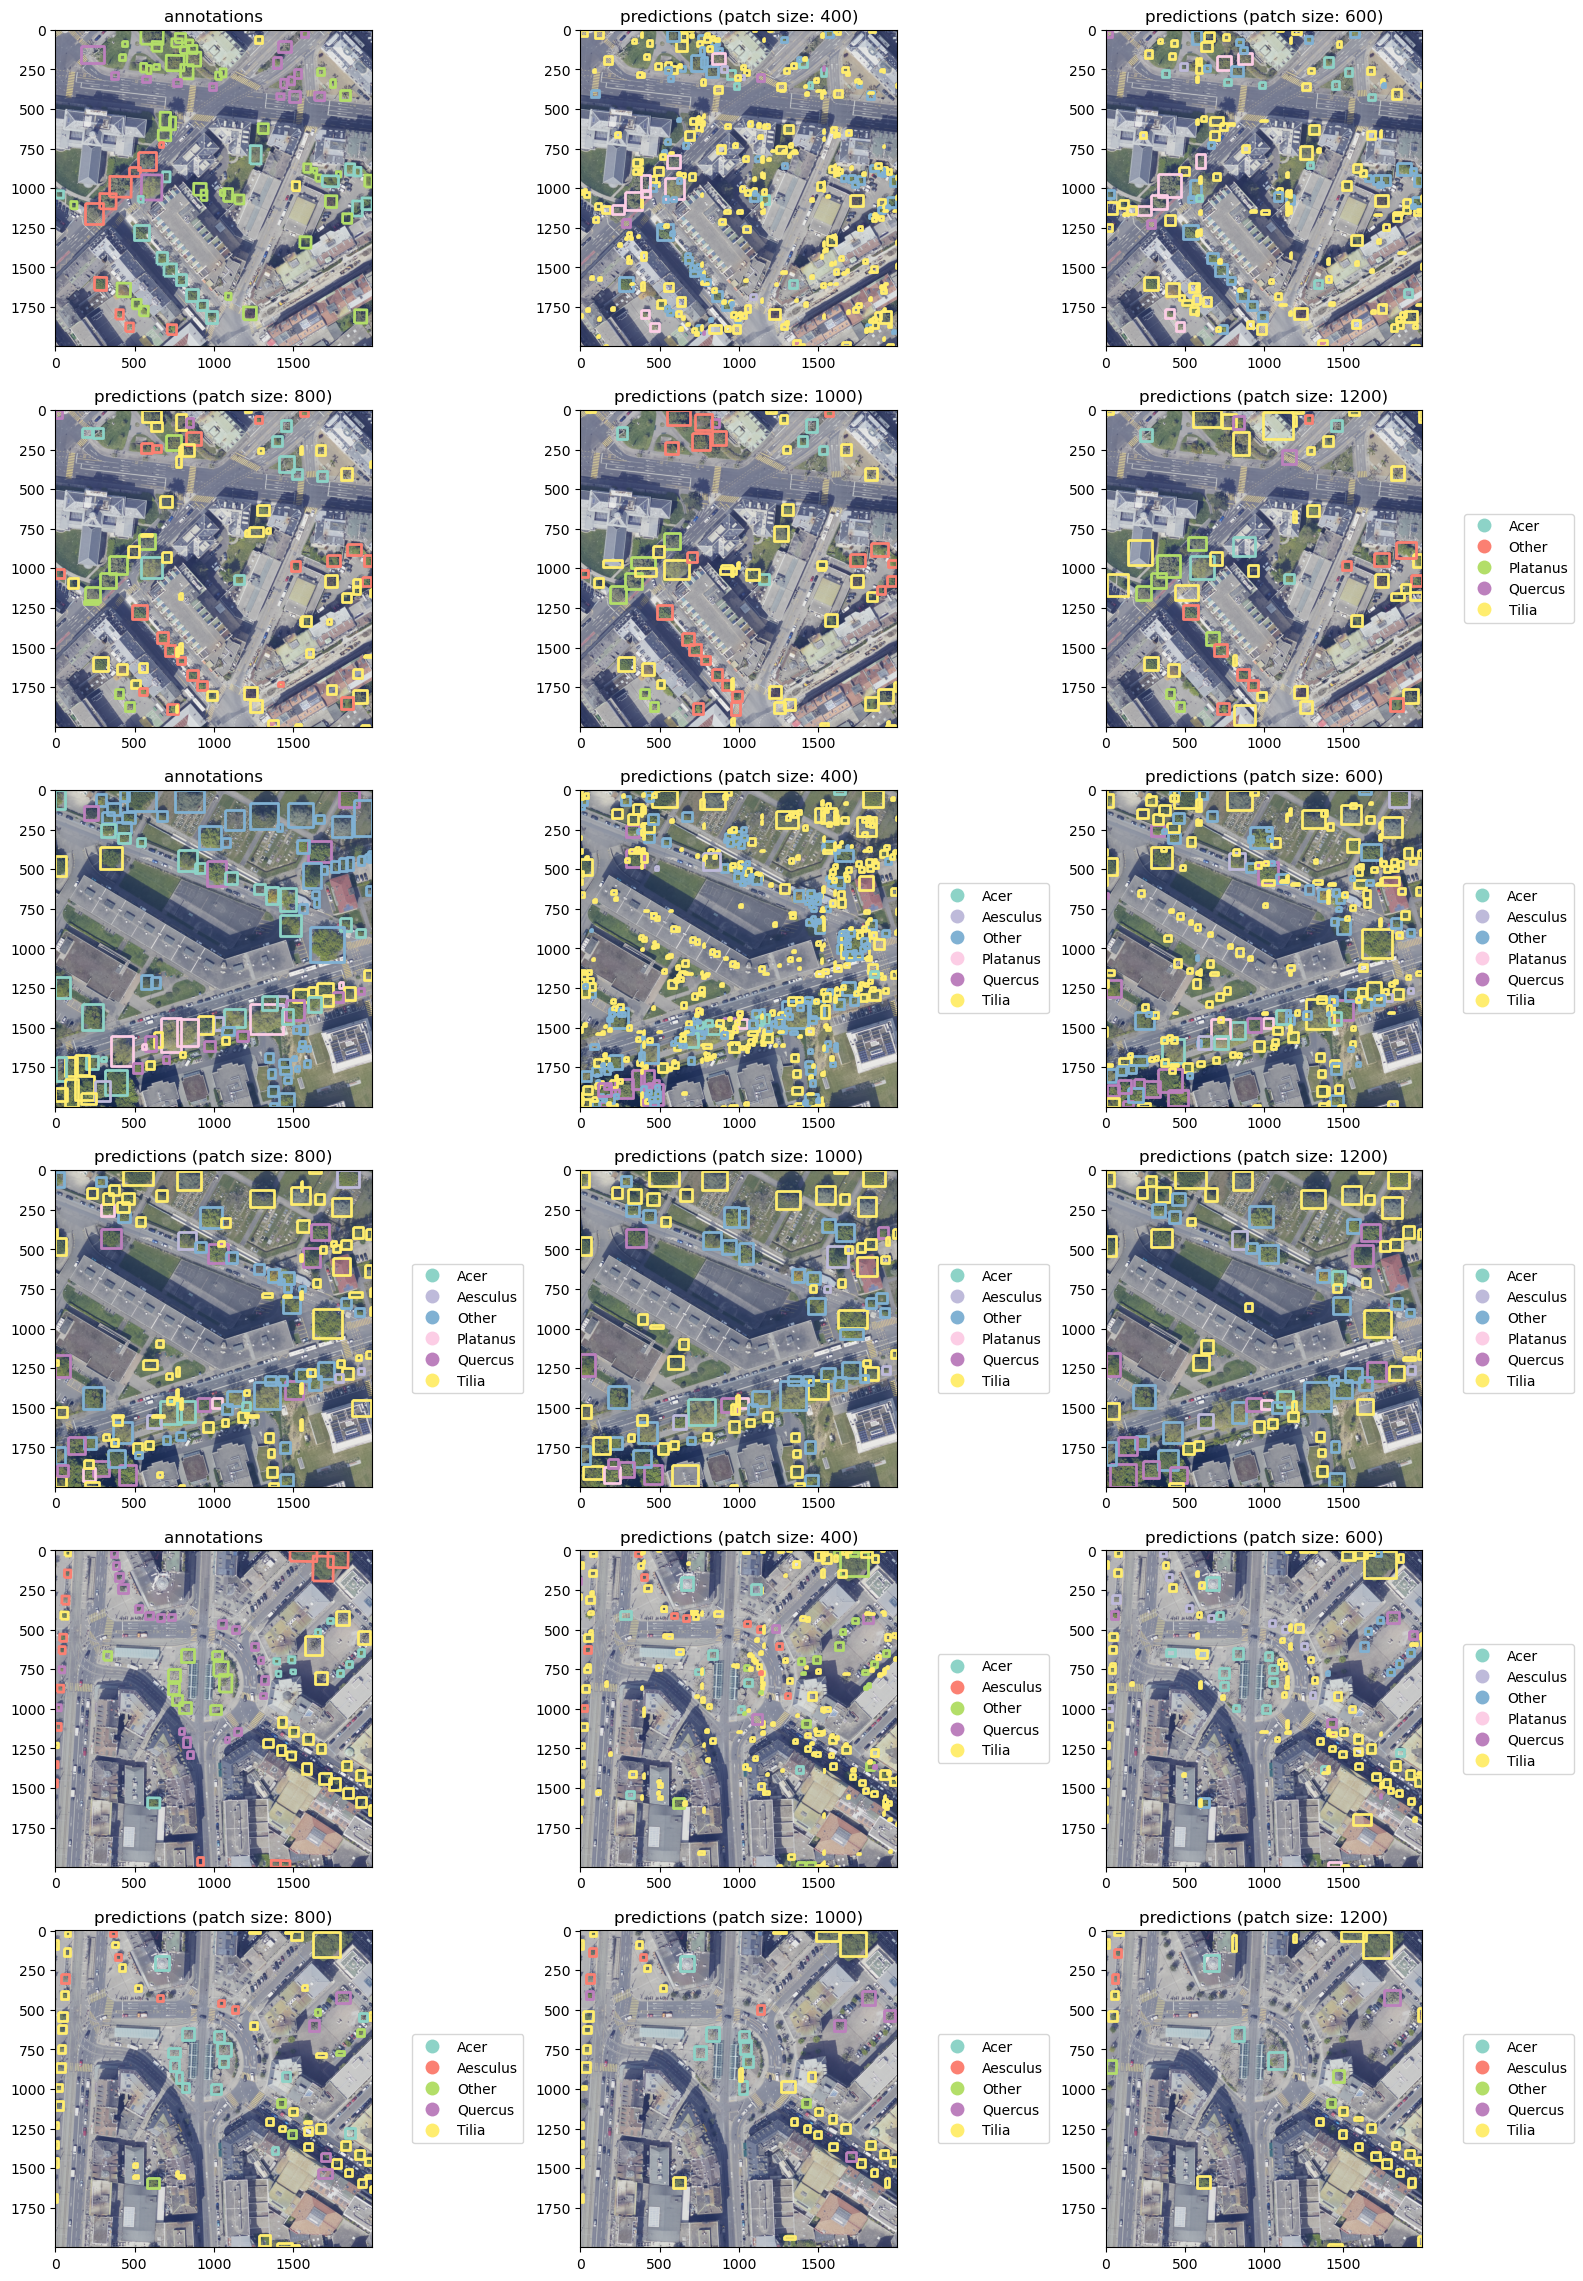

In [ ]:
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    pred_gdf,
    tile_dir,
    plot_annot_kwargs=plot_kwargs,
    plot_pred_kwargs=plot_kwargs,
)

Let us now compute the recall, precision and F1 metrics at each patch size, for the tree crown bounding boxes and species classification:

In [ ]:
box_eval_df, class_eval_df = deepforest_utils.multiscale_eval_df(
    pred_gdf, annot_gdf, tile_dir, iou_threshold=iou_threshold, compute_f1=True
)
box_eval_df

IoU  box_recall  box_precision  patch_size        F1
0  0.493168    0.896057       0.233583         400  0.370568
1  0.542077    0.874552       0.474609         600  0.615302
2  0.473849    0.741935       0.706485         800  0.723776
3  0.500676    0.641577       0.799107        1000  0.711730
4  0.520156    0.498208       0.830303        1200  0.622748

While the precision increases monotonically with the patch size, it does so at the expense of recall. This occurs because less tree crowns are being predicted, however a higher proportion of them are matched to a ground truth (hence the higher precision). The best F1 score is obtained for the patch size of 800 px.

To keep the evaluation of the species classification simple, we will only plot the F1 metric for each species and patch size:

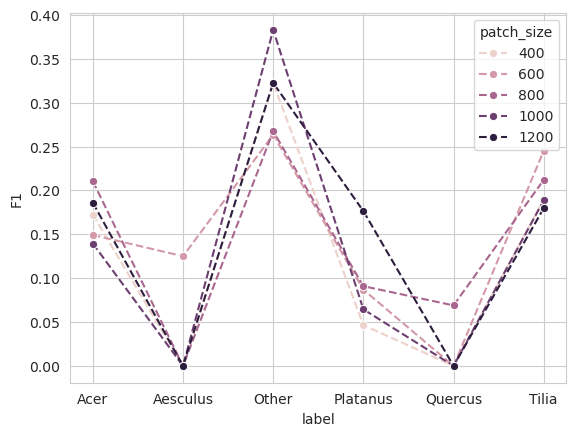

In [ ]:
with sns.axes_style("whitegrid"):
    sns.lineplot(
        class_eval_df, x="label", y="F1", hue="patch_size", linestyle="--", marker="o"
    )

As we can see, the F1 scores are generaly low - most likely due to the (very) limited training data used. **Note that this is merely a draft repository to set up the workflow, therefore expect further annotations and improved results shortly.**

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.